# **Armenian Job Market Analysis**

**Course:** Algorithms and Programming Languages

**Students:** Vahe Sardaryan, Milena Mayilyan, Artyom Mkrtchyan, Mane Mazmandyan

**Professor:** Varazdat Avetisyan (PhD)


> **December 2025**


# **Introduction**

**Project Overview**

This project presents a comprehensive analysis of the Armenian Job Market through advanced data science methodologies applied to two major employment platforms: Job.am and Staff.am. The study aims to uncover structural patterns, trends, and predictive insights within Armenia's labor market using machine learning techniques.

**Project Objectives**

The primary goals of this research are to:
1. Collect comprehensive job market data from Armenian employment platforms through automated web scraping
2. Clean and standardize heterogeneous job posting information into structured datasets
3. Analyze market trends including salary distributions, geographic patterns, industry demands, and competition levels
4. Develop machine learning models for:

> **Clustering:** Identifying natural groupings of similar job postings
> **Classification:** Predicting job categories and employment types
> **Regression:** Forecasting applicant volume based on job characteristics

5. Generate actionable insights for job seekers, employers, and platform operators

**Motivation and Significance**

Understanding labor market dynamics is crucial for:

- Job seekers to identify opportunities matching their qualifications and salary expectations
- Employers to optimize job postings and attract suitable candidates
- Policy makers to understand employment trends and workforce development needs
- Platform operators to enhance recommendation systems and user experience
- The Armenian job market presents unique characteristics that warrant specialized analysis, including language considerations, regional employment patterns, and industry-specific dynamics.

**Methodology Overview**

This project follows a systematic data science workflow:

**Stage 1-2: Data Scrapping and Cleaning**

Web scraping from Job.am and Staff.am platforms
Data validation, missing value handling, and outlier detection
Standardization of text fields and numerical features

**Stage 3: Data Preprocessing**

Feature engineering (salary normalization, experience encoding, location categorization)
Creation of analytical variables (competition levels, salary categories)
Data encoding and scaling for machine learning readiness

**Stage 4-5: Exploratory Data Analysis**

Descriptive statistics and distribution analysis
Correlation analysis between job attributes
Hypothesis testing for salary differences and market segmentation
Comprehensive data visualization

**Stages 6-8: Machine Learning Modeling**

**Clustering Analysis:** K-Means and Hierarchical Clustering to identify job market segments
**Classification Models:** Logistic Regression and Random Forest for employment type prediction
**Regression Models:** Linear and Random Forest Regression for applicant volume forecasting
Model evaluation, comparison, and selection based on performance metrics

**Technical Stack**
- Programming: Python 3.x
- Data Collection: BeautifulSoup, Requests
- Data Processing: Pandas, NumPy
- Visualization: Matplotlib, Seaborn
- Machine Learning: Scikit-learn
- Statistical Analysis: SciPy
- Environment: Google Colaboratory

**Dataset Characteristics**
The analysis encompasses:

**Job.am:** ~900+ job postings
**Staff.am:** ~1200+ job postings
**Features:** Job titles, company names, locations, salaries, experience requirements, employment types, industries, applicant counts

**Time Period:** December 2025

**Project Structure**

This notebook is organized into 11 comprehensive stages, each building upon previous work to progressively transform raw web data into actionable business intelligence:

**Base Stage:** Environment setup and library imports
**Stage 1:** Web scraping and data collection
**Stage 2:** Data cleaning and validation
**Stage 3:** Feature engineering and preprocessing
**Stage 4:** Exploratory data analysis
**Stage 5:** Data visualization
**Stage 6.1:** Clustering model training
**Stage 6.2:** Clustering model selection
Stage 7.1: Classification model training
Stage 7.2: Classification model selection
**Stage 8.1 and 8.2:** Regression modeling and evaluation

**Expected Contributions**

This research provides:

Empirical insights into Armenian job market structure and trends

Predictive models for job recommendation and market forecasting

Methodological framework for ongoing labor market analysis

Open-source implementation reproducible for future studies

# **Base stage: Importing Libraries**

In [ ]:
import re
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# **1st Stage: Data Scraping - Job.am**

Extract detailed job listings directly from the **Job.am** website.  
This stage sets up scraping tools and authentication, defines helper functions to parse pages, logs into the site, and systematically collects key details, such as **job titles, company names, locations, salaries, experience requirements**, across multiple job pages to build a structured raw dataset.

Setup of Login Credentials and Basic Configuration

In [ ]:
BASE = "https://job.am"
LIST_PATH = "/en/jobs"
HEADERS = {"User-Agent": "Mozilla/5.0"}
PAUSE = 0.5

MY_EMAIL = "sardariannn05@gmail.com"
MY_PASSWORD = "Test123!"

print("Login credentials and configurations set!")

Login credentials and configurations set!


Define Helper Functions

These are small pieces of code we'll use for main scrapping code to make mor understandable for me and for the reviewer

**Function 1: Get soup from a URL**
This function downloads and parses a webpage into a BeautifulSoup object.

In [ ]:
def get_soup_session(sess, url):
    r = sess.get(url, timeout=25)
    r.raise_for_status()
    return BeautifulSoup(r.text, "lxml")

**Function 2: Get text from a tag or return empty string**
This function safely extracts text from an HTML element.



In [ ]:
def text_or_empty(node):
    if node:
        return node.get_text(strip=True)
    else:
        return ""

**Function 3: Get info value by label (like "Location", "Industry", etc.)**

This finds info boxes on the job page.

For example, if we ask for "Location", it finds the box that says "Location: Yerevan" and returns "Yerevan"

In [ ]:
def get_info_value(soup, label_en):

    for box in soup.select(".info-publish .info-address"):
        spans = box.find_all("span")
        if not spans:
            continue

        label = spans[0].get_text(strip=True).rstrip(":")

        if label.lower() == label_en.lower():
            return text_or_empty(box.select_one(".txt-bold"))

    return ""

**Function 4: Currency symbols and names**
This dictionary maps currency symbols to their codes

In [ ]:
CURR_MAP = {
    "֏": "AMD",
    "$": "USD",
    "€": "EUR",
    "₽": "RUB",
}

def normalize_currency(raw):
    raw = raw.strip().lower()

    for symbol, code in CURR_MAP.items():
        if symbol.lower() in raw:
            return code

    return ""

**Function 5: Parse salary into separate pieces**

This breaks down salary like "Monthly 500,000-700,000 ֏" into:
  - period: "Monthly"
  - min: "500000"
  - max: "700000"
  - currency: "AMD"

In [ ]:
def parse_salary(soup):

    sal_box = None
    for box in soup.select(".info-publish .info-address"):
        lab = box.find("span")
        if lab and lab.get_text(strip=True).rstrip(":").lower() == "salary":
            sal_box = box
            break

    if not sal_box:
        return "", "", "", ""

    bold = sal_box.select_one(".txt-bold")
    if not bold:
        return "", "", "", ""

    period = text_or_empty(bold.select_one(".text-lowercase"))

    raw = " ".join(bold.stripped_strings)

    num_part = raw.replace(period, "", 1).strip()

    currency = normalize_currency(raw)

    nums = re.findall(r"[\d,\.]+", num_part)
    if not nums:
        return period, "", "", currency

    if "-" in num_part:

        parts = num_part.split("-")
        nmin = re.findall(r"[\d,\.]+", parts[0])[-1]
        nmax = re.findall(r"[\d,\.]+", parts[-1])[0]
    else:
        nmin = nums[0]
        nmax = nums[0]

    def clean_number(x):
        if x:
            return x.replace(",", "").replace(" ", "")
        else:
            return x

    return period, clean_number(nmin), clean_number(nmax), currency

**Function 6: Parse applicants count**

This finds how many people applied to the job.
  - "4 applications" -> returns 4
  - "1 application" -> returns 1
  - "newly posted" -> returns 0

In [ ]:
def parse_applicants_count(soup):
    for row in soup.select(".info-publish .info-address"):
        txt = " ".join(row.stripped_strings).lower()

        if "log in to see the number" in txt:
            continue

        if "newly posted" in txt:
            return 0

        m = re.search(r"\b(\d[\d,]*)\s+(application|applications)\b", txt)
        if m:
            return int(m.group(1).replace(",", ""))

    return None

**Function 7: Collect job links from a page**
This function collects all job post links from a given Job.am page (desktop version only).

It downloads the page, filters out duplicate/mobile job cards, extracts each job link, converts it into a full URL, and returns a list of unique links.

In [ ]:
def collect_desktop_job_links(sess, page_url):

    r = sess.get(page_url)
    soup = BeautifulSoup(r.text, "lxml")

    container = soup.select_one(".jam-jobs")

    if container is None:
        return []

    desktop_cards = container.select("div.jobs-card.d-md-block")

    filtered_cards = []

    for c in desktop_cards:
        card_classes = c.get("class")

        if card_classes is None:
            filtered_cards.append(c)

        else:
            if "jobs-card-mob" not in card_classes:
                filtered_cards.append(c)

    hrefs = []

    for card in filtered_cards:
        a_tag = card.select_one("a.jttl")

        if a_tag is not None:
            href = a_tag.get("href")

            if href is not None:
                full_url = urljoin(BASE, href)

                hrefs.append(full_url)

    unique_hrefs = list(dict.fromkeys(hrefs))

    return unique_hrefs

Login to Job.am

Logs into Job.am using set account credentials.

It opens the login page, extracts the hidden verification token, sends the set email and password securely with the token, and verifies if the login was successful by checking the redirected page.


In [ ]:
print("Logging in to Job.am")

# Create session
sess = requests.Session()
sess.headers.update(HEADERS)

# Go to login page
login_url = urljoin(BASE, "/en/Account/login")
r = sess.get(login_url, timeout=25)
r.raise_for_status()
soup = BeautifulSoup(r.text, "lxml")

# Get form token
form = soup.select_one('form[action="/en/Account/Login"]')
token_el = form.select_one('input[name="__RequestVerificationToken"]')
token = token_el["value"] if token_el else ""

# Prepare login data
payload = {
    "__RequestVerificationToken": token,
    "Email": MY_EMAIL,
    "Password": MY_PASSWORD,
    "RememberMe": "true",
    "ReturnUrl": ""
}

headers = dict(HEADERS, **{"Referer": login_url})
post_url = urljoin(BASE, "/en/Account/Login")

# Send login request
r2 = sess.post(post_url, data=payload, headers=headers, allow_redirects=True, timeout=25)
r2.raise_for_status()

# Check if login worked
if "/Account/Login" in r2.url or "Sign in" in r2.text:
    print("Login failed — check your login/pass.")
    raise RuntimeError("Login failed")
else:
    print("Logged in Job.am!")

Logging in to Job.am
Logged in Job.am!


**Scrape Job Listings**

Crawls Job.am listings page by page:

1) Build the page URL (?p=page), collect all desktop job links on that page.
2) If no links are found, stop (we reached the end).
3) For each job link, open the job page and extract fields:
  - title, company, location, employment type, schedule, experience, industry
  - salary (period/min/max/currency), applicants count, job URL
4) Append each job as a dict to `rows`.
5) Sleep briefly between requests to be polite and avoid bot detection.
6) Increment `page` and repeat until finished.


In [ ]:
rows = []
page = 1

while True:
    list_url = f"{BASE}{LIST_PATH}?p={page}"

    job_links = collect_desktop_job_links(sess, list_url)

    if not job_links:
        print(f"No more jobs on page {page}")
        break

    print(f"- Page {page}: Found {len(job_links)} jobs")

    for job_url in job_links:
        try:
            s = get_soup_session(sess, job_url)

            job_name = text_or_empty(s.select_one("h1.us-name"))
            company_name = text_or_empty(s.select_one("h3 .subscribes-title"))
            location = get_info_value(s, "Location")
            employment_type = get_info_value(s, "Employment type")
            work_experience = get_info_value(s, "Work experience")
            industry = get_info_value(s, "Industry")

            sal_period, sal_min, sal_max, sal_curr = parse_salary(s)

            applicants = parse_applicants_count(s)

            rows.append({
                "Job name": job_name,
                "Company name": company_name,
                "Location": location,
                "Employment type": employment_type,
                "Work experience": work_experience,
                "Industry": industry,
                "Salary period": sal_period,
                "Salary min": sal_min,
                "Salary max": sal_max,
                "Salary currency": sal_curr,
                "Applicants count": applicants,
                "Job URL": job_url
            })

            time.sleep(PAUSE)

        except Exception as e:
            print(f"- [skip] {job_url} — {e}")
            time.sleep(PAUSE)

    page += 1
    time.sleep(PAUSE)

print("Scraping complete!")

- Page 1: Found 80 jobs


KeyboardInterrupt: 

Create DataFrame, View Results and Save to CSV




In [ ]:
df = pd.DataFrame(rows)

print(f"Total jobs scraped: {len(df)}")

df.to_csv('scraped_jobs.csv', index=False)

print("Data saved to 'scraped_jobs.csv'")

df.head(10)

# **2nd Stage: Data Cleaning | Job.am and Staff.am**

Focuses on refining and standardizing the raw job data collected in the first stage.  


This step handles missing values (filling them with “Not Specified” or `NaN` where appropriate), converts salary fields into numeric formats, detects and flags potential salary outliers, and standardizes key text fields such as **Location** and **Company Name**.  


The goal is to ensure the dataset is accurate, consistent, and ready for further processing and analysis.

Copying the actual data

In [ ]:
job_am_scrapped_jobs = 'https://docs.google.com/spreadsheets/d/16hg-uefTHhnSLoTvUFUy_xiXheZeXtFkcaDQUHr5ssM/export?format=csv'
staffam_scrapped_jobs = 'https://docs.google.com/spreadsheets/d/16AOKEDatDd0u2z-TdlrU0m-ghWFdHNC1_LzKYSHU-lE/export?format=csv'

jobam_df = pd.read_csv(job_am_scrapped_jobs)
staffam_df = pd.read_csv(staffam_scrapped_jobs)

jobam_df_clean = jobam_df.copy()
staffam_df_clean = staffam_df.copy()

print(f"Job.am dataset size: {len(jobam_df_clean)} jobs")
print(f"Staff.am dataset size: {len(staffam_df_clean)} jobs")

Job.am dataset size: 948 jobs
Staff.am dataset size: 1218 jobs


Check missing values

Checks every column for missing data.

Counts both NaN values and empty strings ("").

Prints how many are missing in each column and the percentage of missing entries.

In [ ]:
def clean_dataset(df_clean, dataset_name):

    original_size = len(df_clean)

    # 1. Checking Missing Values
    print(f"Checking Missing Values for {dataset_name}")

    all_columns = [
        'Job name', 'Company name', 'Location', 'Employment type',
        'Work experience', 'Industry',
        'Salary period', 'Salary min', 'Salary max', 'Salary currency',
        'Applicants count', 'Job URL'
    ]

    for column_name in all_columns:
        if column_name not in df_clean.columns:
            continue

        nan_count = df_clean[column_name].isnull().sum()

        empty_string_count = 0
        if df_clean[column_name].dtype == 'object':
            empty_string_count = (df_clean[column_name] == "").sum()

        total_missing = nan_count + empty_string_count
        percent_missing = (total_missing / len(df_clean)) * 100

        if total_missing > 0:
            print(f"{column_name}: {total_missing} missing ({percent_missing:.1f}%)")

    print()

    # 2. Checking Critical Fields
    print(f"Checking Critical Fields for {dataset_name}")

    jobs_without_name = (df_clean['Job name'].isna()) | (df_clean['Job name'] == "")
    jobs_without_company = (df_clean['Company name'].isna()) | (df_clean['Company name'] == "")

    print(f"Jobs missing job name: {jobs_without_name.sum()}")
    print(f"Jobs missing company name: {jobs_without_company.sum()}")

    if jobs_without_name.sum() > 0 or jobs_without_company.sum() > 0:
        bad_rows = jobs_without_name | jobs_without_company
        print(f"Removing {bad_rows.sum()} jobs")
        df_clean = df_clean[~bad_rows].copy()

    print()

    # Fixing Text Fields
    print(f"3. Fixing Text Fields for {dataset_name}")

    text_fields = ['Location', 'Employment type',
                   'Work experience', 'Industry']

    for field in text_fields:
        if field not in df_clean.columns:
            continue

        df_clean[field] = df_clean[field].replace("", "Not Specified")
        df_clean[field] = df_clean[field].fillna("Not Specified")

        not_specified_count = (df_clean[field] == "Not Specified").sum()
        print(f"{field}: {not_specified_count} set to 'Not Specified'")

    print()

    # Fixing Salary Fields
    print(f"4. Fixing Salary Fields for {dataset_name}")

    salary_fields = ['Salary period', 'Salary min', 'Salary max', 'Salary currency']

    for field in salary_fields:
        if field in df_clean.columns:
            df_clean[field] = df_clean[field].replace("", np.nan)

    # Convert to numeric
    df_clean['Salary min'] = pd.to_numeric(df_clean['Salary min'], errors='coerce')
    df_clean['Salary max'] = pd.to_numeric(df_clean['Salary max'], errors='coerce')

    # Flag salary info
    df_clean['Has Salary Info'] = df_clean['Salary min'].notna()

    # Calculate average
    df_clean['Salary avg'] = (df_clean['Salary min'] + df_clean['Salary max']) / 2

    jobs_with_salary = df_clean['Has Salary Info'].sum()
    percent_with_salary = (jobs_with_salary / len(df_clean)) * 100

    print(f"Jobs with salary info: {jobs_with_salary} ({percent_with_salary:.1f}%)")
    print()

    # Fixing Applicant Counts
    print(f"5. Fixing Applicant Counts for {dataset_name}")

    if 'Applicants count' in df_clean.columns:
        missing_applicants = df_clean['Applicants count'].isna().sum()
        df_clean['Applicants count'] = df_clean['Applicants count'].fillna(0)
        print(f"Set {missing_applicants} missing values to 0 (newly posted jobs)")

    print()

    # Identifying Salary Outliers
    print(f"Identifying Salary Outliers for {dataset_name}")

    amd_salaries = df_clean[df_clean['Salary currency'] == 'AMD']['Salary avg'].dropna()

    if len(amd_salaries) > 0:
        Q1 = amd_salaries.quantile(0.25)
        Q3 = amd_salaries.quantile(0.75)
        IQR = Q3 - Q1

        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR

        is_outlier = (df_clean['Salary currency'] == 'AMD') & \
                     ((df_clean['Salary avg'] < lower_boundary) |
                      (df_clean['Salary avg'] > upper_boundary))
        outliers = df_clean[is_outlier]

        print(f"Salary range (AMD): {amd_salaries.min():,.0f} - {amd_salaries.max():,.0f}")
        print(f"Median salary (AMD): {amd_salaries.median():,.0f}")
        print(f"Outliers found: {len(outliers)} ({len(outliers)/len(amd_salaries)*100:.1f}%)")

        if len(outliers) > 0:
            print("\nTop 5 highest salaries:")
            top_5 = outliers.nlargest(5, 'Salary avg')

            for _, row in top_5.iterrows():
                job_name = row['Job name']
                salary = row['Salary avg']
                print(f"  - {job_name}: {salary:,.0f} AMD")

    print()

    # Cleaning Text Data
    print(f"7. Cleaning Text Data for {dataset_name}")

    df_clean['Location'] = df_clean['Location'].str.strip()
    df_clean['Location'] = df_clean['Location'].str.title()

    df_clean['Job name'] = df_clean['Job name'].str.strip()
    df_clean['Company name'] = df_clean['Company name'].str.strip()
    df_clean['Employment type'] = df_clean['Employment type'].str.strip()

    print("Text data cleaned (stripped whitespace, standardized capitalization)")
    print()

    # Checking for Bad Data
    print(f"8, Checking for Bad Data in {dataset_name}")

    negative_salaries = (df_clean['Salary avg'] < 0).sum()

    if negative_salaries > 0:
        print(f"Found {negative_salaries} jobs with negative salary - removing")
        df_clean = df_clean[df_clean['Salary avg'] >= 0].copy()
    else:
        print("All salaries are positive ✓")

    if 'Applicants count' in df_clean.columns:
        negative_applicants = (df_clean['Applicants count'] < 0).sum()

        if negative_applicants > 0:
            print(f"Found {negative_applicants} with negative applicants - fixing to 0")
            df_clean.loc[df_clean['Applicants count'] < 0, 'Applicants count'] = 0
        else:
            print("All applicant counts are valid ✓")

    print()

    # Summary Statistics
    print(f"Summary Statistics for {dataset_name}")

    print(f"Dataset size:")
    print(f"  - Jobs before cleaning: {original_size} jobs")
    print(f"  - Jobs after cleaning: {len(df_clean)} jobs")
    print(f"  - Jobs removed: {original_size - len(df_clean)} jobs ({((original_size - len(df_clean))/original_size*100):.1f}%)")
    print()

    total = len(df_clean)
    with_location = (df_clean['Location'] != 'Not Specified').sum()
    with_salary = df_clean['Has Salary Info'].sum()

    if 'Applicants count' in df_clean.columns:
        with_applicants = (df_clean['Applicants count'] > 0).sum()
    else:
        with_applicants = 0

    print(f"Data completeness:")
    print(f"- Jobs with location info: {with_location:,} ({with_location/total*100:.1f}%)")
    print(f"- Jobs with salary info: {with_salary:,} ({with_salary/total*100:.1f}%)")
    if 'Applicants count' in df_clean.columns:
        print(f"- Jobs with applicant data: {with_applicants:,} ({with_applicants/total*100:.1f}%)")

    return df_clean

In [ ]:
jobam_df_clean = clean_dataset(jobam_df_clean, "Job.am")

Checking Missing Values for Job.am
Work experience: 59 missing (6.2%)
Salary period: 607 missing (64.0%)
Salary min: 607 missing (64.0%)
Salary max: 607 missing (64.0%)
Salary currency: 607 missing (64.0%)
Applicants count: 43 missing (4.5%)

Checking Critical Fields for Job.am
Jobs missing job name: 0
Jobs missing company name: 0

3. Fixing Text Fields for Job.am
Location: 0 set to 'Not Specified'
Employment type: 0 set to 'Not Specified'
Work experience: 59 set to 'Not Specified'
Industry: 0 set to 'Not Specified'

4. Fixing Salary Fields for Job.am
Jobs with salary info: 341 (36.0%)

5. Fixing Applicant Counts for Job.am
Set 43 missing values to 0 (newly posted jobs)

Identifying Salary Outliers for Job.am
Salary range (AMD): 125 - 2,150,000
Median salary (AMD): 215,000
Outliers found: 20 (6.0%)

Top 5 highest salaries:
  - Real estate agent: 2,150,000 AMD
  - Առաջնային շուկայի անշարժ գույքի գործակալ: 2,150,000 AMD
  - Կահույքագործ: 925,000 AMD
  - Կահույքագործ: 625,000 AMD
  - Կոսմ

In [ ]:
staffam_df_clean = clean_dataset(staffam_df_clean, "Staff.am")

Checking Missing Values for Staff.am
Salary period: 1055 missing (86.6%)
Salary min: 1056 missing (86.7%)
Salary max: 1056 missing (86.7%)
Salary currency: 1055 missing (86.6%)

Checking Critical Fields for Staff.am
Jobs missing job name: 0
Jobs missing company name: 0

3. Fixing Text Fields for Staff.am
Location: 0 set to 'Not Specified'
Employment type: 0 set to 'Not Specified'
Work experience: 0 set to 'Not Specified'
Industry: 0 set to 'Not Specified'

4. Fixing Salary Fields for Staff.am
Jobs with salary info: 162 (13.3%)

5. Fixing Applicant Counts for Staff.am
Set 0 missing values to 0 (newly posted jobs)

Identifying Salary Outliers for Staff.am
Salary range (AMD): 77,500 - 2,250,000
Median salary (AMD): 275,000
Outliers found: 13 (9.1%)

Top 5 highest salaries:
  - Անշարժ գույքի վաճառքի և վարձակալության մասնագետ: 2,250,000 AMD
  - Realtor: 2,150,000 AMD
  - Finance Manager: 900,000 AMD
  - Աուդիտի, էթիկայի և որակի հսկողության կոմիտեների գործունեության ապահովման բաժնի ավագ աուդ

Save clean data to CSV

In [ ]:
dfs_to_save = {
    "clean_jobam_scraped_jobs.csv": jobam_df_clean,
    "clean_staffam_scraped_jobs.csv": staffam_df_clean,
}

for filename, df_obj in dfs_to_save.items():
    df_obj.to_csv(filename, index=False)
    print(f"Saved {filename} ({len(df_obj)} jobs)")

Saved clean_jobam_scraped_jobs.csv (948 jobs)
Saved clean_staffam_scraped_jobs.csv (1218 jobs)


In [ ]:
jobam_df_clean.head(5)

,Job name,Company name,Location,Employment type,Work experience,Industry,Salary period,Salary min,Salary max,Salary currency,Applicants count,Job URL,Has Salary Info,Salary avg
0,Պահանջվում Է վարորդ առաքիչ դեղերի մեծածախ կազմ...,Pharmproekt LLC,"Erebuni, Yerevan",Part Time,"Not required, Junior, Mid level, Senior","Medical, Health, Logistics, Transportation",Monthly,160000.0,160000.0,AMD,1.0,https://job.am/en/job/pahanjvum-e-varord-araqi...,True,160000.0
1,Սպասարկող-գանձապահ,BADEN,Yerevan,Full Time,"Junior, Mid level","Sales, Business Development, Customer Support,...",Monthly,150000.0,170000.0,AMD,58.0,https://job.am/en/job/spasarkogh-gandzapah-68283,True,160000.0
2,Կոսմետոլոգ-էսթետիստ,Անթերիս Էսթետիկ Բժշկության Կենտրոն,Yerevan,Full Time,"Mid level, Senior","Medical, Health",Monthly,300000.0,900000.0,AMD,1.0,https://job.am/en/job/kosmetolog-estetist-68233,True,600000.0
3,Խորհրդատու-վաճառող (Պտղնի մասնաճյուղում),Im Aygin,Abovyan,Full Time,"Not required, Junior, Mid level, Senior","Sales, Business Development, Customer Support,...",Monthly,170000.0,220000.0,AMD,38.0,https://job.am/en/job/xorhrdatu-vacharogh-ptgh...,True,195000.0
4,Վարորդ-առաքիչ,FRAG,Yerevan,Full Time,"Not required, Junior, Mid level","Logistics, Transportation",Monthly,200000.0,220000.0,AMD,8.0,https://job.am/en/job/varord-araqich-69027,True,210000.0


In [ ]:
staffam_df_clean.head(5)

,Job name,Company name,Location,Employment type,Work experience,Industry,Salary period,Salary min,Salary max,Salary currency,Applicants count,Job URL,Has Salary Info,Salary avg
0,Middle IT specialist,Globbing,Yerevan,Full time,Mid level,IT Support/Technician,NaN,NaN,NaN,NaN,327,https://staff.am/en/jobs/globbing/middle-it-sp...,False,NaN
1,русскоговорящий/ англоговорящий гид-водитель,Armenia Holiday,Yerevan,Full time,Mid level,Tourism/Hospitality/HoReCa,NaN,NaN,NaN,NaN,277,https://staff.am/en/jobs/armenia-holiday/russk...,False,NaN
2,Assistant director,Lomano,Yerevan,Full time,Not defined,Administrative/office-work,NaN,NaN,NaN,NaN,255,https://staff.am/en/jobs/lomano/assistant-dire...,False,NaN
3,Accountant,Prodigi,Yerevan,Full time,Not defined,Accounting/Bookkeeping/Cash register,Monthly,180000.0,210000.0,AMD,254,https://staff.am/en/jobs/prodigi-llc/accountan...,True,195000.0
4,Outbound Sales Representative (Remote with Ini...,Hundred CJSC,Yerevan,Full time,Mid level,Sales/service management,NaN,NaN,NaN,NaN,253,https://staff.am/en/jobs/hundred-cjsc/outbound...,False,NaN


# **3rd Stage: Data Preprocessing | Job.am and Staff.am**

Prepares the cleaned data for detailed analysis by creating new analytical features and transforming values into usable formats.


This stage includes engineering features for **salary**, **location**, **experience**, **industry**, encoding categorical data into numeric form, normalizing numerical columns for consistency, and selecting only the most relevant features.  


It concludes by generating specialized datasets for focused analyses such as salary trends, competition, and regional insights.

In [ ]:
jobam_df = pd.read_csv('clean_jobam_scraped_jobs.csv')
staffam_df = pd.read_csv('clean_staffam_scraped_jobs.csv')

jobam_processed = jobam_df.copy()
staffam_processed = staffam_df.copy()

print(f"Job.am cleaned dataset: {len(jobam_processed)} jobs")
print(f"Staff.am cleaned dataset: {len(staffam_processed)} jobs")

Job.am cleaned dataset: 948 jobs
Staff.am cleaned dataset: 1218 jobs


Salary Analysis Features

A) Calculate salary range width (how negotiable is the salary?)

In [ ]:
jobam_processed['Salary_Range_Width'] = jobam_processed['Salary max'] - jobam_processed['Salary min']
staffam_processed['Salary_Range_Width'] = staffam_processed['Salary max'] - staffam_processed['Salary min']

B) Is salary negotiable? (range > 0 means yes)

In [ ]:
jobam_processed['Salary_Negotiable'] = (jobam_processed['Salary_Range_Width'] > 0).astype(int)
staffam_processed['Salary_Negotiable'] = (staffam_processed['Salary_Range_Width'] > 0).astype(int)

C) Salary categories for AMD jobs (most common currency)

In [ ]:
def categorize_salary(row):
    if pd.isna(row['Salary avg']) or row['Salary currency'] != 'AMD':
        return "Not_Specified"
    salary = row['Salary avg']
    if salary < 150000:
        return "Under_150K"
    elif salary < 250000:
        return "150K_250K"
    elif salary < 400000:
        return "250K_400K"
    elif salary < 600000:
        return "400K_600K"
    else:
        return "Over_600K"

In [ ]:
jobam_processed['Salary_Category'] = jobam_processed.apply(categorize_salary, axis=1)
staffam_processed['Salary_Category'] = staffam_processed.apply(categorize_salary, axis=1)

In [ ]:
print(f"Job.am - Negotiable salaries: {jobam_processed['Salary_Negotiable'].sum()}")
print(f"Staff.am - Negotiable salaries: {staffam_processed['Salary_Negotiable'].sum()}")

Job.am - Negotiable salaries: 176
Staff.am - Negotiable salaries: 103


Location analysis features

A) Main location categories

Yerevan, Other cities, Remote

In [ ]:
jobam_processed['Is_Yerevan'] = jobam_processed['Location'].str.contains('Yerevan', case=False, na=False).astype(int)
staffam_processed['Is_Yerevan'] = staffam_processed['Location'].str.contains('Yerevan', case=False, na=False).astype(int)

jobam_processed['Is_Remote'] = jobam_processed['Location'].str.contains('Remote', case=False, na=False).astype(int)
staffam_processed['Is_Remote'] = staffam_processed['Location'].str.contains('Remote', case=False, na=False).astype(int)

B) Extract Yerevan districts

In [ ]:
yerevan_districts = ['Kentron', 'Shengavit', 'Arabkir', 'Erebuni', 'Kanaker-Zeytun',
                     'Ajapnyak', 'Malatia-Sebastia', 'Nor Nork', 'Davtashen', 'Avan',
                     'Nork-Marash', 'Nubarashen']

def extract_district(location):
    if pd.isna(location) or 'Yerevan' not in str(location):
        return "Not_Yerevan"
    for district in yerevan_districts:
        if district in location:
            return district
    return "Yerevan_Other"

jobam_processed['Yerevan_District'] = jobam_processed['Location'].apply(extract_district)
staffam_processed['Yerevan_District'] = staffam_processed['Location'].apply(extract_district)

C) Major cities outside Yerevan

In [ ]:
def categorize_city(location):
    if pd.isna(location):
        return "Not_Specified"
    if "Remote" in str(location):
        return "Remote"
    elif "Yerevan" in str(location):
        return "Yerevan"
    else:
        return "Other_City"

jobam_processed['City_Category'] = jobam_processed['Location'].apply(categorize_city)
staffam_processed['City_Category'] = staffam_processed['Location'].apply(categorize_city)

Summary

In [ ]:
print(f"Job.am:")
print(f"- Jobs in Yerevan: {jobam_processed['Is_Yerevan'].sum()}")
print(f"- Remote jobs: {jobam_processed['Is_Remote'].sum()}")
print(f"- Yerevan districts identified: {jobam_processed['Yerevan_District'].nunique() - 1}")  # -1 for "Not_Yerevan"

print(f"\nStaff.am:")
print(f"- Jobs in Yerevan: {staffam_processed['Is_Yerevan'].sum()}")
print(f"- Remote jobs: {staffam_processed['Is_Remote'].sum()}")
print(f"- Yerevan districts identified: {staffam_processed['Yerevan_District'].nunique() - 1}\n")  # -1 for "Not_Yerevan"


Job.am:
- Jobs in Yerevan: 843
- Remote jobs: 4
- Yerevan districts identified: 12

Staff.am:
- Jobs in Yerevan: 1079
- Remote jobs: 31
- Yerevan districts identified: 1



Experience level features

A) Binary flags for each experience level (1 = accepts this level, 0 = doesn't)

In [ ]:
jobam_processed['Exp_NoExperience'] = jobam_processed['Work experience'].str.contains(
    'No experience|Not required|Without experience', case=False, na=False
).astype(int)

jobam_processed['Exp_Junior'] = jobam_processed['Work experience'].str.contains(
    'Junior', case=False, na=False
).astype(int)

jobam_processed['Exp_MidLevel'] = jobam_processed['Work experience'].str.contains(
    'Mid level|Middle|Mid-level', case=False, na=False
).astype(int)

jobam_processed['Exp_Senior'] = jobam_processed['Work experience'].str.contains(
    'Senior', case=False, na=False
).astype(int)

In [ ]:
staffam_processed['Exp_NoExperience'] = staffam_processed['Work experience'].str.contains(
    'No experience|Not required|Without experience|Student|Not defined', case=False, na=False
).astype(int)

staffam_processed['Exp_Junior'] = staffam_processed['Work experience'].str.contains(
    'Junior', case=False, na=False
).astype(int)

staffam_processed['Exp_MidLevel'] = staffam_processed['Work experience'].str.contains(
    'Mid level|Middle|Mid-level', case=False, na=False
).astype(int)

staffam_processed['Exp_Senior'] = staffam_processed['Work experience'].str.contains(
    'Senior|C level', case=False, na=False
).astype(int)

B) Minimum experience level required (simplified)

In [ ]:
def get_min_exp_level(exp):
    if pd.isna(exp) or exp == "Not Specified":
        return "Not_Specified"
    exp_lower = str(exp).lower()
    if 'no experience' in exp_lower or 'not required' in exp_lower or 'student' in exp_lower or 'not defined' in exp_lower:
        return "No_Experience"
    elif 'junior' in exp_lower:
        return "Junior"
    elif 'mid level' in exp_lower or 'middle' in exp_lower:
        return "Mid_Level"
    elif 'senior' in exp_lower or 'c' in exp_lower:
        return "Senior"
    else:
        return "Not_Specified"

jobam_processed['Min_Experience_Level'] = jobam_processed['Work experience'].apply(get_min_exp_level)
staffam_processed['Min_Experience_Level'] = staffam_processed['Work experience'].apply(get_min_exp_level)

In [ ]:
print(f"Job.am - No exp: {jobam_processed['Exp_NoExperience'].sum()}, Junior: {jobam_processed['Exp_Junior'].sum()}, Mid: {jobam_processed['Exp_MidLevel'].sum()}, Senior: {jobam_processed['Exp_Senior'].sum()}")
print(f"Staff.am - No exp: {staffam_processed['Exp_NoExperience'].sum()}, Junior: {staffam_processed['Exp_Junior'].sum()}, Mid: {staffam_processed['Exp_MidLevel'].sum()}, Senior: {staffam_processed['Exp_Senior'].sum()}\n")

Job.am - No exp: 186, Junior: 282, Mid: 523, Senior: 384
Staff.am - No exp: 246, Junior: 123, Mid: 533, Senior: 316



Employment terms categorization

In [ ]:
employment_patterns = {
    'Emp_FullTime': 'Full time|Full-time|Ամբողջ դրույք',
    'Emp_PartTime': 'Part time|Part-time|Կես դրույք',
    'Emp_Flexible': 'Flexible|Ճկուն',
    'Emp_Contract': 'Contract|Fixed term contract|Պայմանագրային',
    'Emp_Temporary': 'Temporary|Seasonal|Ժամանակավոր',
    'Emp_Internship': 'Internship|Intern|Training|Պրակտիկա',
    'Emp_Remote': 'Remote|Հեռավար',
    'Emp_Tender': 'Tender|Մրցույթ',
    'Emp_Other': 'Other|Այլ'
}

# Apply to both Job.am and Staff.am
for col_name, pattern in employment_patterns.items():
    jobam_processed[col_name] = jobam_processed['Employment type'].str.contains(
        pattern, case=False, na=False
    ).astype(int)

    staffam_processed[col_name] = staffam_processed['Employment type'].str.contains(
        pattern, case=False, na=False
    ).astype(int)

In [ ]:
print(f"Job.am:")
print(f"  - Full-time: {jobam_processed['Emp_FullTime'].sum()}")
print(f"  - Part-time: {jobam_processed['Emp_PartTime'].sum()}")
print(f"  - Flexible: {jobam_processed['Emp_Flexible'].sum()}")
print(f"  - Contract: {jobam_processed['Emp_Contract'].sum()}")
print(f"  - Temporary: {jobam_processed['Emp_Temporary'].sum()}")
print(f"  - Internship: {jobam_processed['Emp_Internship'].sum()}")
print(f"  - Remote: {jobam_processed['Emp_Remote'].sum()}")
print(f"  - Tender: {jobam_processed['Emp_Tender'].sum()}")
print(f"  - Other: {jobam_processed['Emp_Other'].sum()}")

print(f"\nStaff.am:")
print(f"  - Full-time: {staffam_processed['Emp_FullTime'].sum()}")
print(f"  - Part-time: {staffam_processed['Emp_PartTime'].sum()}")
print(f"  - Flexible: {staffam_processed['Emp_Flexible'].sum()}")
print(f"  - Contract: {staffam_processed['Emp_Contract'].sum()}")
print(f"  - Temporary: {staffam_processed['Emp_Temporary'].sum()}")
print(f"  - Internship: {staffam_processed['Emp_Internship'].sum()}")
print(f"  - Remote: {staffam_processed['Emp_Remote'].sum()}")
print(f"  - Tender: {staffam_processed['Emp_Tender'].sum()}")
print(f"  - Other: {staffam_processed['Emp_Other'].sum()}")

Job.am:
  - Full-time: 894
  - Part-time: 49
  - Flexible: 55
  - Contract: 14
  - Temporary: 1
  - Internship: 1
  - Remote: 0
  - Tender: 0
  - Other: 0

Staff.am:
  - Full-time: 1098
  - Part-time: 17
  - Flexible: 39
  - Contract: 7
  - Temporary: 0
  - Internship: 2
  - Remote: 31
  - Tender: 0
  - Other: 24


Industry categorization

In [ ]:
def categorize_industry(industry):
    """Groups industries into broad categories"""
    if pd.isna(industry) or industry == "Not Specified":
        return "Other"

    ind = str(industry).lower()

    # Tech & IT
    if any(x in ind for x in ['software', 'it ', 'information tech', 'devops', 'data scien',
                               'data engineer', 'qa', 'quality assurance', 'ui/ux', 'network admin',
                               'system admin', 'it support', 'it security', 'hardware']):
        return "Tech_IT"

    # Finance & Banking
    if any(x in ind for x in ['banking', 'finance', 'accounting', 'bookkeeping', 'audit',
                               'insurance', 'credit']):
        return "Finance_Banking"

    # Sales & Marketing
    if any(x in ind for x in ['sales', 'marketing', 'advertising', 'business development',
                               'merchandising']):
        return "Sales_Marketing"

    # Management & Admin
    if any(x in ind for x in ['management', 'administrative', 'hr', 'human resource',
                               'executive', 'project management', 'product management',
                               'office', 'clerical']):
        return "Management_Admin"

    # Customer Service
    if any(x in ind for x in ['customer', 'support', 'service', 'client care']):
        return "Customer_Service"

    # Education & Training
    if any(x in ind for x in ['education', 'training', 'instruction', 'foreign language']):
        return "Education"

    # Healthcare
    if any(x in ind for x in ['health', 'medical', 'pharmaceutical']):
        return "Healthcare"

    # Hospitality & Tourism
    if any(x in ind for x in ['tourism', 'hospitality', 'hotel', 'horeca', 'restaurant',
                               'food service']):
        return "Hospitality_Tourism"

    # Logistics & Procurement
    if any(x in ind for x in ['logistics', 'procurement', 'courier', 'transportation',
                               'import', 'export', 'supply chain']):
        return "Logistics_Procurement"

    # Legal
    if 'legal' in ind or 'law' in ind:
        return "Legal"

    # Construction & Engineering
    if any(x in ind for x in ['construction', 'engineering', 'mechanical', 'architecture']):
        return "Construction_Engineering"

    # Production & Manufacturing
    if any(x in ind for x in ['production', 'manufacturing', 'operations']):
        return "Production"

    # Creative & Design
    if any(x in ind for x in ['design', 'art', 'creative', 'graphic', 'content',
                               'motion', 'copywriting', 'beauty', 'fashion']):
        return "Creative_Design"

    # Entertainment & Media
    if any(x in ind for x in ['entertainment', 'tv', 'radio', 'journalism', 'pr',
                               'communications', 'media']):
        return "Entertainment_Media"

    # Security
    if 'security' in ind or 'protective' in ind:
        return "Security"

    # Real Estate
    if 'real estate' in ind:
        return "Real_Estate"

    # NGO & Nonprofit
    if 'ngo' in ind or 'nonprofit' in ind or 'non-profit' in ind:
        return "NGO_Nonprofit"

    return "Other"

jobam_processed['Industry_Category'] = jobam_processed['Industry'].apply(categorize_industry)
staffam_processed['Industry_Category'] = staffam_processed['Industry'].apply(categorize_industry)

In [ ]:
print("Job.am - Top 5 industries:")
for cat, count in jobam_processed['Industry_Category'].value_counts().head().items():
    print(f"  {cat}: {count}")

print("\nStaff.am - Top 5 industries:")
for cat, count in staffam_processed['Industry_Category'].value_counts().head().items():
    print(f"  {cat}: {count}")
print()

Job.am - Top 5 industries:
  Sales_Marketing: 310
  Management_Admin: 137
  Finance_Banking: 116
  Customer_Service: 79
  Logistics_Procurement: 74

Staff.am - Top 5 industries:
  Finance_Banking: 321
  Sales_Marketing: 238
  Tech_IT: 182
  Management_Admin: 167
  Other: 81



Competition and demand features

A) Competition level (based on applicant count)

In [ ]:
def categorize_competition(count):
    if pd.isna(count) or count == 0:
        return "Newly_Posted"
    elif count <= 10:
        return "Low"
    elif count <= 30:
        return "Medium"
    else:
        return "High"

if 'Applicants count' in jobam_processed.columns:
    jobam_processed['Competition_Level'] = jobam_processed['Applicants count'].apply(categorize_competition)
    jobam_processed['Competition_Low'] = (jobam_processed['Competition_Level'] == 'Low').astype(int)
    jobam_processed['Competition_Medium'] = (jobam_processed['Competition_Level'] == 'Medium').astype(int)
    jobam_processed['Competition_High'] = (jobam_processed['Competition_Level'] == 'High').astype(int)
    print(f"Job.am - Low: {jobam_processed['Competition_Low'].sum()}, Medium: {jobam_processed['Competition_Medium'].sum()}, High: {jobam_processed['Competition_High'].sum()}")

if 'Applicants count' in staffam_processed.columns:
    staffam_processed['Competition_Level'] = staffam_processed['Applicants count'].apply(categorize_competition)
    staffam_processed['Competition_Low'] = (staffam_processed['Competition_Level'] == 'Low').astype(int)
    staffam_processed['Competition_Medium'] = (staffam_processed['Competition_Level'] == 'Medium').astype(int)
    staffam_processed['Competition_High'] = (staffam_processed['Competition_Level'] == 'High').astype(int)
    print(f"Staff.am - Low: {staffam_processed['Competition_Low'].sum()}, Medium: {staffam_processed['Competition_Medium'].sum()}, High: {staffam_processed['Competition_High'].sum()}")

Job.am - Low: 166, Medium: 299, High: 438
Staff.am - Low: 473, Medium: 250, High: 486


Salary normalisation

Convert all salaries to monthly equivalents for fair comparison
    
- Hourly > Monthly (160 hours: 8h/day × 20 days)
- Daily > Monthly (20 working days)
- Weekly > Monthly (4.33 weeks)
- Monthly (no change)
- Yearly > Monthly (÷ 12)

In [ ]:
def normalize_salary_to_monthly(row):
    salary = row.get('Salary avg')
    period = row.get('Salary period')

    if pd.isna(salary) or pd.isna(period) or period == "":
        return np.nan

    period = period.lower().strip()

    if 'hour' in period:
        return salary * 160  # 8 hours/day × 20 days
    if 'day' in period or 'daily' in period:
        return salary * 20  # 20 working days
    if 'week' in period:
        return salary * 4.33  # Average weeks per month
    if 'month' in period:
        return salary
    if 'year' in period or 'annual' in period:
        return salary / 12  # Convert to monthly

    return salary

# Apply to Job.am
jobam_processed['Salary avg'] = jobam_processed.apply(normalize_salary_to_monthly, axis=1)

print("Job.am - Salary Periods:")
if 'Salary period' in jobam_processed.columns:
    for period, count in jobam_processed['Salary period'].value_counts().items():
        if period:
            print(f"  - {period}: {count} jobs")
print(f"  Jobs with normalized salary: {jobam_processed['Salary avg'].notna().sum()}")

# Apply to Staff.am
staffam_processed['Salary avg'] = staffam_processed.apply(normalize_salary_to_monthly, axis=1)

print("\nStaff.am - Salary Periods:")
if 'Salary period' in staffam_processed.columns:
    for period, count in staffam_processed['Salary period'].value_counts().items():
        if period:
            print(f"  - {period}: {count} jobs")
print(f"  Jobs with normalized salary: {staffam_processed['Salary avg'].notna().sum()}\n")

Job.am - Salary Periods:
  - Monthly: 332 jobs
  - Daily: 8 jobs
  - Hourly: 1 jobs
  Jobs with normalized salary: 341

Staff.am - Salary Periods:
  - Monthly: 162 jobs
  - Hourly: 1 jobs
  Jobs with normalized salary: 161



Data encoding (Categories > Numbers)



A) Label Encoding: For ordered data (has ranking)

Experience levels: No experience < Junior < Mid level < Senior

In [ ]:
experience_order = {
    'Not_Specified': -1,
    'No_Experience': 0,
    'Junior': 1,
    'Mid_Level': 2,
    'Senior': 3
}

jobam_processed['Experience_Level_Encoded'] = jobam_processed['Min_Experience_Level'].map(experience_order)
staffam_processed['Experience_Level_Encoded'] = staffam_processed['Min_Experience_Level'].map(experience_order)

print("Encoding: Not_Specified=-1, No_Experience=0, Junior=1, Mid_Level=2, Senior=3")
print(f"Job.am encoded: {jobam_processed['Experience_Level_Encoded'].notna().sum()} jobs")
print(f"Staff.am encoded: {staffam_processed['Experience_Level_Encoded'].notna().sum()} jobs\n")

Encoding: Not_Specified=-1, No_Experience=0, Junior=1, Mid_Level=2, Senior=3
Job.am encoded: 948 jobs
Staff.am encoded: 1218 jobs



B) One-Hot Encoding - For unordered categories (no ranking)

Creates separate columns for each category (dummy variables)

In [ ]:
# Industry categories
industry_dummies_job = pd.get_dummies(jobam_processed['Industry_Category'], prefix='Ind')
jobam_processed = pd.concat([jobam_processed, industry_dummies_job], axis=1)

industry_dummies_staff = pd.get_dummies(staffam_processed['Industry_Category'], prefix='Ind')
staffam_processed = pd.concat([staffam_processed, industry_dummies_staff], axis=1)

# City categories
city_dummies_job = pd.get_dummies(jobam_processed['City_Category'], prefix='City')
jobam_processed = pd.concat([jobam_processed, city_dummies_job], axis=1)

city_dummies_staff = pd.get_dummies(staffam_processed['City_Category'], prefix='City')
staffam_processed = pd.concat([staffam_processed, city_dummies_staff], axis=1)

# Salary categories
salary_dummies_job = pd.get_dummies(jobam_processed['Salary_Category'], prefix='Sal')
jobam_processed = pd.concat([jobam_processed, salary_dummies_job], axis=1)

salary_dummies_staff = pd.get_dummies(staffam_processed['Salary_Category'], prefix='Sal')
staffam_processed = pd.concat([staffam_processed, salary_dummies_staff], axis=1)

Printing the summary

In [ ]:
print(f"Job.am - Industry: {len(industry_dummies_job.columns)}, City: {len(city_dummies_job.columns)}, Salary: {len(salary_dummies_job.columns)} dummy columns")
print(f"Staff.am - Industry: {len(industry_dummies_staff.columns)}, City: {len(city_dummies_staff.columns)}, Salary: {len(salary_dummies_staff.columns)} dummy columns\n")

Job.am - Industry: 16, City: 3, Salary: 6 dummy columns
Staff.am - Industry: 16, City: 3, Salary: 6 dummy columns



Data transformation (Normalize Numbers)

In [ ]:
numerical_cols = ['Salary avg', 'Applicants count', 'Salary_Range_Width']

Method 1: Standardization (mean=0, std=1) - for analysis

In [ ]:
print("Standardization (mean=0, std=1):")
for col in numerical_cols:
    # Job.am
    if col in jobam_processed.columns:
        valid_data = jobam_processed[col].notna()
        if valid_data.sum() > 0:
            scaler = StandardScaler()
            jobam_processed.loc[valid_data, f'{col}_Standardized'] = scaler.fit_transform(
                jobam_processed.loc[valid_data, [col]]
            )

    # Staff.am
    if col in staffam_processed.columns:
        valid_data = staffam_processed[col].notna()
        if valid_data.sum() > 0:
            scaler = StandardScaler()
            staffam_processed.loc[valid_data, f'{col}_Standardized'] = scaler.fit_transform(
                staffam_processed.loc[valid_data, [col]]
            )

print(f"Standardized {len(numerical_cols)} features for both databases")

Standardization (mean=0, std=1):
Standardized 3 features for both databases


Method 2: Min-Max Scaling (0 to 1 range)

In [ ]:
print("Min-Max Scaling (0 to 1):")
for col in numerical_cols:
    # Job.am
    if col in jobam_processed.columns:
        valid_data = jobam_processed[col].notna()
        if valid_data.sum() > 0:
            scaler = MinMaxScaler()
            jobam_processed.loc[valid_data, f'{col}_Scaled'] = scaler.fit_transform(
                jobam_processed.loc[valid_data, [col]]
            )

    # Staff.am
    if col in staffam_processed.columns:
        valid_data = staffam_processed[col].notna()
        if valid_data.sum() > 0:
            scaler = MinMaxScaler()
            staffam_processed.loc[valid_data, f'{col}_Scaled'] = scaler.fit_transform(
                staffam_processed.loc[valid_data, [col]]
            )

print(f"Scaled {len(numerical_cols)} features for both databases\n")

Min-Max Scaling (0 to 1):
Scaled 3 features for both databases



Save to CSV the processed jobs.

In [ ]:
jobam_processed.to_csv('jobam_processed.csv', index=False)
staffam_processed.to_csv('staffam_processed.csv', index=False)

print(f"✓ Job.am: {len(jobam_processed)} jobs, {len(jobam_processed.columns)} features")
print(f"✓ Staff.am: {len(staffam_processed)} jobs, {len(staffam_processed.columns)} features")

✓ Job.am: 948 jobs, 72 features
✓ Staff.am: 1218 jobs, 72 features


# **4th Stage: Exploratory Data Analysis (EDA)**

**Descriptive Statistics:** Summarizes the dataset using metrics like mean, median, mode, standard deviation, and frequency distributions, offering a clear overview of numerical and categorical features.

**Distribution Analysis:** Visualizes how variables (e.g., salaries, applicants) are spread, revealing trends, skews, and outliers.

**Correlation Analysis:** Measures how numerical features relate to one another, identifying strong or weak associations through correlation coefficients and heatmaps.

**Hypothesis Testing:** Validates insights statistically—for example, comparing salaries across cities or salary differences by industry.

Set visualization style

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

In [ ]:
jobam_processed = pd.read_csv('jobam_processed.csv')
staffam_processed = pd.read_csv('staffam_processed.csv')

# Add platform identifier
jobam_processed['Platform'] = 'Job.am'
staffam_processed['Platform'] = 'Staff.am'

# Combine datasets for comparative analysis
df_combined = pd.concat([jobam_processed, staffam_processed], ignore_index=True)

**Descriptive Statistics**

**Descriptive Statistics:** Overall dataset summary




In [ ]:
print(f"Job.am: {len(jobam_processed):,} jobs")
print(f"Staff.am: {len(staffam_processed):,} jobs")
print(f"Combined: {len(df_combined):,} jobs")
print(f"Total unique companies: {df_combined['Company name'].nunique():,}")
print(f"Total industries covered: {df_combined['Industry_Category'].nunique()}\n")

Job.am: 948 jobs
Staff.am: 1,218 jobs
Combined: 2,166 jobs
Total unique companies: 979
Total industries covered: 17



**Descriptive Statistics:** Numerical features summary

Salary statistics

In [ ]:
for platform_name, df in [('Job.am', jobam_processed), ('Staff.am', staffam_processed)]:
    salary_amd = df[df['Salary currency'] == 'AMD']['Salary avg'].dropna()

    if len(salary_amd) > 0:
        print(f"\n{platform_name}:")
        print(f"  - Jobs with salary data: {len(salary_amd):,}")
        print(f"  - Mean: {salary_amd.mean():,.0f} AMD")
        print(f"  - Median: {salary_amd.median():,.0f} AMD")
        print(f"  - Std Dev: {salary_amd.std():,.0f} AMD")
        print(f"  - Min: {salary_amd.min():,.0f} AMD")
        print(f"  - Max: {salary_amd.max():,.0f} AMD")
        print(f"  - 25th percentile: {salary_amd.quantile(0.25):,.0f} AMD")
        print(f"  - 75th percentile: {salary_amd.quantile(0.75):,.0f} AMD")

        # Find jobs with max and min salaries
        max_salary_row = df[df['Salary avg'] == salary_amd.max()]
        min_salary_row = df[df['Salary avg'] == salary_amd.min()]

        if not max_salary_row.empty:
            job_max = max_salary_row.iloc[0]['Job name']
            company_max = max_salary_row.iloc[0]['Company name']
            print(f"  - Highest salary job: '{job_max}' at {company_max} ({salary_amd.max():,.0f} AMD)")

        if not min_salary_row.empty:
            job_min = min_salary_row.iloc[0]['Job name']
            company_min = min_salary_row.iloc[0]['Company name']
            print(f"  - Lowest salary job: '{job_min}' at {company_min} ({salary_amd.min():,.0f} AMD)")


Job.am:
  - Jobs with salary data: 336
  - Mean: 258,879 AMD
  - Median: 220,000 AMD
  - Std Dev: 183,474 AMD
  - Min: 125 AMD
  - Max: 2,150,000 AMD
  - 25th percentile: 180,000 AMD
  - 75th percentile: 300,000 AMD
  - Highest salary job: 'Real estate agent' at Calibri Group (2,150,000 AMD)
  - Lowest salary job: 'Content Creation / Brend Manager' at Sixty (125 AMD)

Staff.am:
  - Jobs with salary data: 143
  - Mean: 323,600 AMD
  - Median: 275,000 AMD
  - Std Dev: 267,494 AMD
  - Min: 77,500 AMD
  - Max: 2,250,000 AMD
  - 25th percentile: 200,000 AMD
  - 75th percentile: 337,500 AMD
  - Highest salary job: 'Անշարժ գույքի վաճառքի և վարձակալության մասնագետ' at Ռեզիդենտ անշարժ գույքի գործակալություն (2,250,000 AMD)
  - Lowest salary job: 'Sales Manager' at Okbaby Armenia (77,500 AMD)


Applicants statistics

In [ ]:
for platform_name, df in [('Job.am', jobam_processed), ('Staff.am', staffam_processed)]:
    applicants = df['Applicants count'].dropna()

    if len(applicants) > 0:
        print(f"\n{platform_name}:")
        print(f"  - Jobs with applicant data: {len(applicants):,}")
        print(f"  - Mean: {applicants.mean():.1f} applicants")
        print(f"  - Median: {applicants.median():.1f} applicants")
        print(f"  - Std Dev: {applicants.std():.1f}")
        print(f"  - Min: {applicants.min():.0f}")
        print(f"  - Max: {applicants.max():.0f}")



Job.am:
  - Jobs with applicant data: 948
  - Mean: 42.7 applicants
  - Median: 28.0 applicants
  - Std Dev: 49.2
  - Min: 0
  - Max: 347

Staff.am:
  - Jobs with applicant data: 1,218
  - Mean: 40.9 applicants
  - Median: 16.0 applicants
  - Std Dev: 52.0
  - Min: 0
  - Max: 327


**Descriptive Statistics:** Categorical features summary

Location distribution

In [ ]:
for platform_name, df in [('Job.am', jobam_processed), ('Staff.am', staffam_processed)]:
    print(f"\n{platform_name}:")
    location_counts = df['City_Category'].value_counts()
    for location, count in location_counts.head(5).items():
        print(f"  - {location}: {count:,} jobs ({count/len(df)*100:.1f}%)")


Job.am:
  - Yerevan: 843 jobs (88.9%)
  - Other_City: 101 jobs (10.7%)
  - Remote: 4 jobs (0.4%)

Staff.am:
  - Yerevan: 1,079 jobs (88.6%)
  - Other_City: 108 jobs (8.9%)
  - Remote: 31 jobs (2.5%)


Top industries

In [ ]:
for platform_name, df in [('Job.am', jobam_processed), ('Staff.am', staffam_processed)]:
    print(f"\n{platform_name}:")
    industry_counts = df['Industry_Category'].value_counts()
    for industry, count in industry_counts.head(5).items():
        print(f"  - {industry}: {count:,} jobs ({count/len(df)*100:.1f}%)")


Job.am:
  - Sales_Marketing: 310 jobs (32.7%)
  - Management_Admin: 137 jobs (14.5%)
  - Finance_Banking: 116 jobs (12.2%)
  - Customer_Service: 79 jobs (8.3%)
  - Logistics_Procurement: 74 jobs (7.8%)

Staff.am:
  - Finance_Banking: 321 jobs (26.4%)
  - Sales_Marketing: 238 jobs (19.5%)
  - Tech_IT: 182 jobs (14.9%)
  - Management_Admin: 167 jobs (13.7%)
  - Other: 81 jobs (6.7%)


Experience level distribution

In [ ]:
for platform_name, df in [('Job.am', jobam_processed), ('Staff.am', staffam_processed)]:
    print(f"\n{platform_name}:")
    exp_counts = df['Min_Experience_Level'].value_counts()
    for exp, count in exp_counts.head(5).items():
        print(f"  - {exp}: {count:,} jobs ({count/len(df)*100:.1f}%)")


Job.am:
  - Mid_Level: 335 jobs (35.3%)
  - Senior: 189 jobs (19.9%)
  - No_Experience: 186 jobs (19.6%)
  - Junior: 179 jobs (18.9%)
  - Not_Specified: 59 jobs (6.2%)

Staff.am:
  - Mid_Level: 533 jobs (43.8%)
  - Senior: 316 jobs (25.9%)
  - No_Experience: 246 jobs (20.2%)
  - Junior: 123 jobs (10.1%)


**Distribution analysis**

**Distribution analysis**: Salary Distribution


Job.am:
  - Skewness: 6.81 (Right-skewed: many lower salaries)
  - Kurtosis: 65.49 (Heavier tails: more outliers)

Staff.am:
  - Skewness: 5.06 (Right-skewed: many lower salaries)
  - Kurtosis: 31.95 (Heavier tails: more outliers)


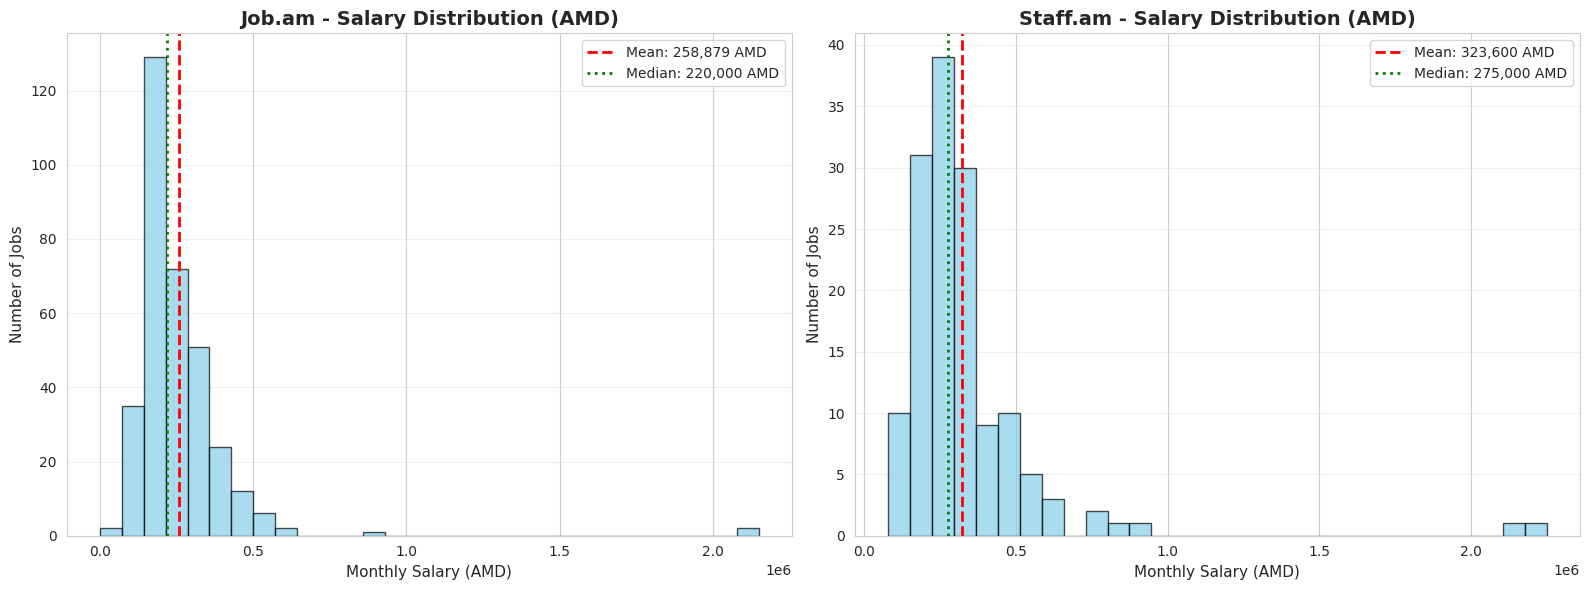

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (platform_name, df) in enumerate([('Job.am', jobam_processed), ('Staff.am', staffam_processed)]):
    salary_amd = df[df['Salary currency'] == 'AMD']['Salary avg'].dropna()

    if len(salary_amd) > 0:
        skewness = stats.skew(salary_amd)
        kurtosis_val = stats.kurtosis(salary_amd)

        print(f"\n{platform_name}:")
        print(f"  - Skewness: {skewness:.2f}", end="")
        if skewness > 0.5:
            print(" (Right-skewed: many lower salaries)")
        elif skewness < -0.5:
            print(" (Left-skewed: many higher salaries)")
        else:
            print(" (Fairly symmetric)")

        print(f"  - Kurtosis: {kurtosis_val:.2f}", end="")
        if kurtosis_val > 0:
            print(" (Heavier tails: more outliers)")
        else:
            print(" (Lighter tails: fewer outliers)")

        # Plot histogram
        axes[idx].hist(salary_amd, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        axes[idx].axvline(salary_amd.mean(), color='red', linestyle='--', linewidth=2,
                    label=f"Mean: {salary_amd.mean():,.0f} AMD")
        axes[idx].axvline(salary_amd.median(), color='green', linestyle=':', linewidth=2,
                    label=f"Median: {salary_amd.median():,.0f} AMD")
        axes[idx].set_title(f'{platform_name} - Salary Distribution (AMD)', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Monthly Salary (AMD)', fontsize=11)
        axes[idx].set_ylabel('Number of Jobs', fontsize=11)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


**Distribution analysis:** Applicants Distribution


Job.am:
  - Skewness: 2.72 (Right-skewed: most jobs have few applicants)
  - Low competition (≤10): 211 jobs (22.3%)
  - Medium competition (11-30): 299 jobs (31.5%)
  - High competition (30+): 438 jobs (46.2%)

Staff.am:
  - Skewness: 1.95 (Right-skewed: most jobs have few applicants)
  - Low competition (≤10): 482 jobs (39.6%)
  - Medium competition (11-30): 250 jobs (20.5%)
  - High competition (30+): 486 jobs (39.9%)


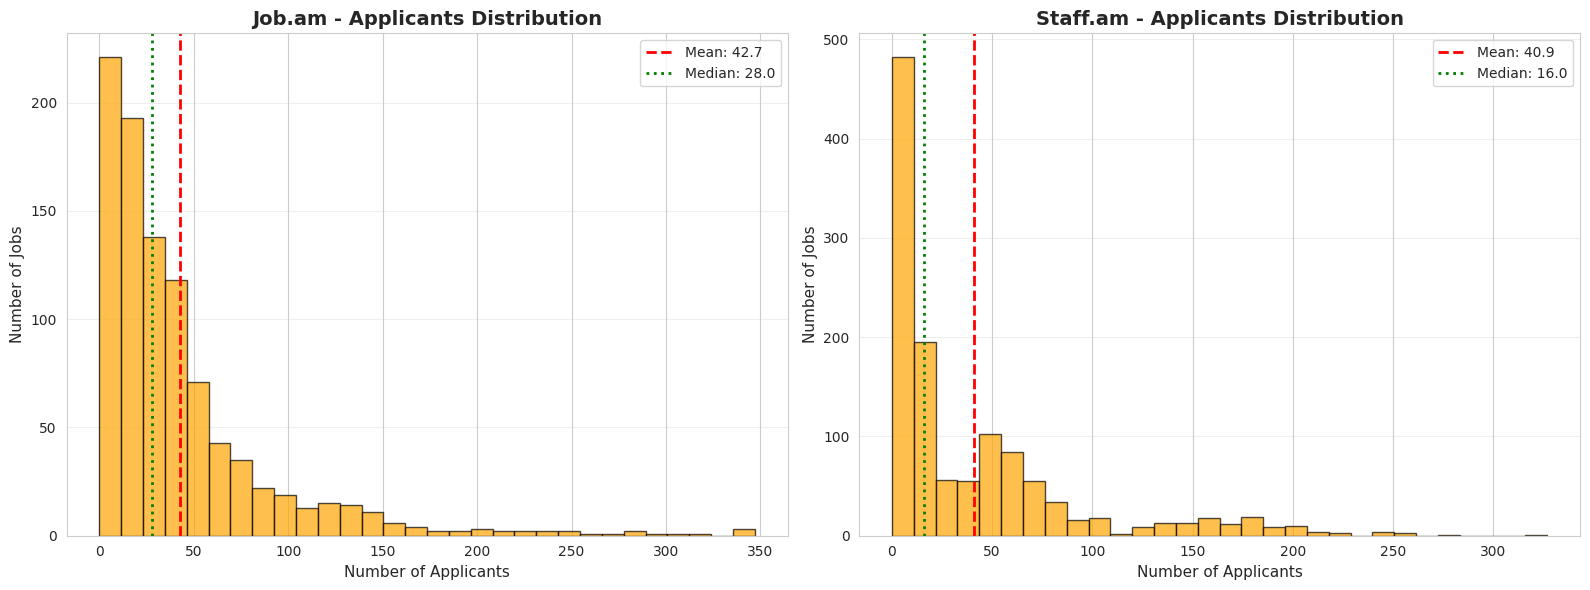

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (platform_name, df) in enumerate([('Job.am', jobam_processed), ('Staff.am', staffam_processed)]):
    applicants = df['Applicants count'].dropna()

    if len(applicants) > 0:
        skewness_app = stats.skew(applicants)

        print(f"\n{platform_name}:")
        print(f"  - Skewness: {skewness_app:.2f}", end="")
        if skewness_app > 0.5:
            print(" (Right-skewed: most jobs have few applicants)")
        else:
            print(" (Fairly symmetric)")

        # Competition breakdown
        low_comp = (applicants <= 10).sum()
        med_comp = ((applicants > 10) & (applicants <= 30)).sum()
        high_comp = (applicants > 30).sum()
        total_jobs = len(applicants)

        print(f"  - Low competition (≤10): {low_comp:,} jobs ({low_comp/total_jobs*100:.1f}%)")
        print(f"  - Medium competition (11-30): {med_comp:,} jobs ({med_comp/total_jobs*100:.1f}%)")
        print(f"  - High competition (30+): {high_comp:,} jobs ({high_comp/total_jobs*100:.1f}%)")

        # Plot histogram
        axes[idx].hist(applicants, bins=30, edgecolor='black', alpha=0.7, color='orange')
        axes[idx].axvline(applicants.mean(), color='red', linestyle='--', linewidth=2,
                    label=f"Mean: {applicants.mean():.1f}")
        axes[idx].axvline(applicants.median(), color='green', linestyle=':', linewidth=2,
                    label=f"Median: {applicants.median():.1f}")
        axes[idx].set_title(f'{platform_name} - Applicants Distribution', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Number of Applicants', fontsize=11)
        axes[idx].set_ylabel('Number of Jobs', fontsize=11)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Correlation analysis**

Choosing numeric data columns and keep the ones who has data


Job.am - Strong Correlations (>|0.3|):
  - Salary avg ↔ Salary_Range_Width: 0.843

Staff.am - Strong Correlations (>|0.3|):
  - Salary avg ↔ Salary_Range_Width: 0.834
  - Is_Yerevan ↔ Is_Remote: -0.756


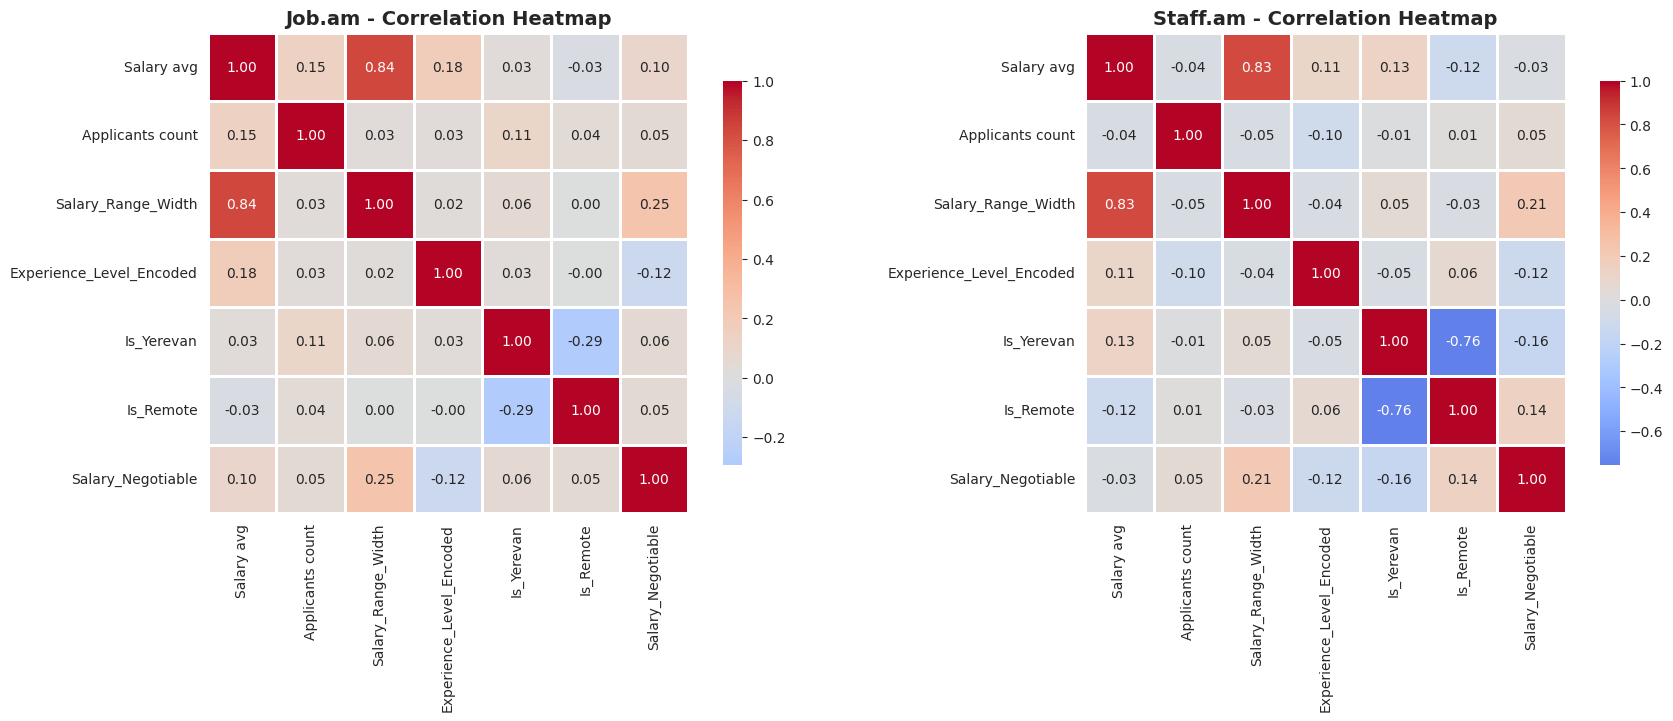

In [ ]:
correlation_features = [
    'Salary avg',
    'Applicants count',
    'Salary_Range_Width',
    'Experience_Level_Encoded',
    'Is_Yerevan',
    'Is_Remote',
    'Salary_Negotiable'
]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, (platform_name, df) in enumerate([('Job.am', jobam_processed), ('Staff.am', staffam_processed)]):
    existing_features = [f for f in correlation_features if f in df.columns]
    correlation_data = df[existing_features].dropna()

    if len(correlation_data) > 0:
        correlation_matrix = correlation_data.corr()

        print(f"\n{platform_name} - Strong Correlations (>|0.3|):")
        num_columns = len(correlation_matrix.columns)
        for i in range(num_columns):
            for j in range(i + 1, num_columns):
                corr_value = correlation_matrix.iloc[i, j]
                if abs(corr_value) > 0.3:
                    col1 = correlation_matrix.columns[i]
                    col2 = correlation_matrix.columns[j]
                    print(f"  - {col1} ↔ {col2}: {corr_value:.3f}")

        # Plot heatmap
        sns.heatmap(
            correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            square=True,
            linewidths=0.8,
            cbar_kws={"shrink": 0.8},
            ax=axes[idx]
        )
        axes[idx].set_title(f'{platform_name} - Correlation Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**Hypothesis testing**

Why these tests?
- 2-sample t-test: compare the mean of two groups
- One-way ANOVA: compare the mean across 3+ groups (industries)



**Hypothesis 1:** Job.am vs Staff.am Salaries (AMD)


In [ ]:
print("\nHypothesis 1: Job.am vs Staff.am Salaries (AMD)")
print("H0: Mean(Job.am) = Mean(Staff.am)")
print("H1: Means are different")

jobam_salaries = jobam_processed[jobam_processed['Salary currency'] == 'AMD']['Salary avg'].dropna()
staffam_salaries = staffam_processed[staffam_processed['Salary currency'] == 'AMD']['Salary avg'].dropna()

if len(jobam_salaries) > 1 and len(staffam_salaries) > 1:
    t_stat, p_value = stats.ttest_ind(jobam_salaries, staffam_salaries)

    print(f"\nResults:")
    print(f"  - Job.am avg salary: {jobam_salaries.mean():,.0f} AMD (n={len(jobam_salaries):,})")
    print(f"  - Staff.am avg salary: {staffam_salaries.mean():,.0f} AMD (n={len(staffam_salaries):,})")
    print(f"  - t-statistic: {t_stat:.3f}")
    print(f"  - p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("REJECT H0: Significant difference (p < 0.05)")
        if jobam_salaries.mean() > staffam_salaries.mean():
            print("Job.am salaries are significantly HIGHER")
        else:
            print("Staff.am salaries are significantly HIGHER")
    else:
        print("FAIL TO REJECT H0: No significant difference (p ≥ 0.05)")



Hypothesis 1: Job.am vs Staff.am Salaries (AMD)
H0: Mean(Job.am) = Mean(Staff.am)
H1: Means are different

Results:
  - Job.am avg salary: 258,879 AMD (n=336)
  - Staff.am avg salary: 323,600 AMD (n=143)
  - t-statistic: -3.058
  - p-value: 0.0024
REJECT H0: Significant difference (p < 0.05)
Staff.am salaries are significantly HIGHER


**Hypothesis 2:** # Yerevan vs Non-Yerevan Salaries (Combined)

In [ ]:
print("Hypothesis 2: Yerevan vs Non-Yerevan Salaries (Combined Data)")
print("H0: Mean(Yerevan) = Mean(Non-Yerevan)")
print("H1: Means are different")

yerevan_salaries = df_combined[
    (df_combined['Is_Yerevan'] == 1) &
    (df_combined['Salary currency'] == 'AMD')
]['Salary avg'].dropna()

non_yerevan_salaries = df_combined[
    (df_combined['Is_Yerevan'] == 0) &
    (df_combined['Salary currency'] == 'AMD')
]['Salary avg'].dropna()

if len(yerevan_salaries) > 1 and len(non_yerevan_salaries) > 1:
    t_stat2, p_value2 = stats.ttest_ind(yerevan_salaries, non_yerevan_salaries)

    print(f"\nResults:")
    print(f"  - Yerevan avg salary: {yerevan_salaries.mean():,.0f} AMD (n={len(yerevan_salaries):,})")
    print(f"  - Non-Yerevan avg salary: {non_yerevan_salaries.mean():,.0f} AMD (n={len(non_yerevan_salaries):,})")
    print(f"  - t-statistic: {t_stat2:.3f}")
    print(f"  - p-value: {p_value2:.4f}")

    if p_value2 < 0.05:
        print("REJECT H0: Significant difference (p < 0.05)")
        if yerevan_salaries.mean() > non_yerevan_salaries.mean():
            print("Yerevan jobs pay significantly MORE")
        else:
            print("Non-Yerevan jobs pay significantly MORE")
    else:
        print("FAIL TO REJECT H0: No significant difference (p ≥ 0.05)")


Hypothesis 2: Yerevan vs Non-Yerevan Salaries (Combined Data)
H0: Mean(Yerevan) = Mean(Non-Yerevan)
H1: Means are different

Results:
  - Yerevan avg salary: 278,406 AMD (n=427)
  - Non-Yerevan avg salary: 276,519 AMD (n=52)
  - t-statistic: 0.060
  - p-value: 0.9522
FAIL TO REJECT H0: No significant difference (p ≥ 0.05)


**Hypothesis 3:** Salary Differences Across Industries (Combined)


In [ ]:
print("Hypothesis 3: Salary Differences Across Industries (Combined)")
print("H0: All industries have the same average salary")
print("H1: At least one industry has a different average salary")

top_industries = df_combined['Industry_Category'].value_counts().head(5).index
industry_salary_groups = []

for industry in top_industries:
    industry_salaries = df_combined[
        (df_combined['Industry_Category'] == industry) &
        (df_combined['Salary currency'] == 'AMD')
    ]['Salary avg'].dropna()

    if len(industry_salaries) > 1:
        industry_salary_groups.append(industry_salaries)
        print(f"  - {industry}: {industry_salaries.mean():,.0f} AMD (n={len(industry_salaries):,})")

if len(industry_salary_groups) >= 2:
    f_stat, p_value3 = stats.f_oneway(*industry_salary_groups)

    print(f"\nANOVA Results:")
    print(f"  - F-statistic: {f_stat:.3f}")
    print(f"  - p-value: {p_value3:.4f}")

    if p_value3 < 0.05:
        print("REJECT H0: Significant differences exist (p < 0.05)")
        print("Industries pay DIFFERENT salaries")
    else:
        print("FAIL TO REJECT H0: No significant differences (p ≥ 0.05)")


Hypothesis 3: Salary Differences Across Industries (Combined)
H0: All industries have the same average salary
H1: At least one industry has a different average salary
  - Sales_Marketing: 286,928 AMD (n=159)
  - Finance_Banking: 300,765 AMD (n=68)
  - Management_Admin: 251,573 AMD (n=86)
  - Tech_IT: 306,250 AMD (n=6)
  - Other: 199,572 AMD (n=25)

ANOVA Results:
  - F-statistic: 1.390
  - p-value: 0.2370
FAIL TO REJECT H0: No significant differences (p ≥ 0.05)


**Hypothesis 4:** Entry-Level vs Experienced Job Competition (Combined)

In [ ]:
print("Hypothesis 4: Entry-Level vs Experienced Job Competition (Combined)")
print("H0: Entry-level jobs have the same applicants as experienced jobs")
print("H1: Different applicant counts")

entry_level = df_combined[df_combined['Exp_NoExperience'] == 1]['Applicants count'].dropna()
experienced = df_combined[df_combined['Exp_NoExperience'] == 0]['Applicants count'].dropna()

if len(entry_level) > 1 and len(experienced) > 1:
    t_stat4, p_value4 = stats.ttest_ind(entry_level, experienced)

    print(f"\nResults:")
    print(f"  - Entry-level avg applicants: {entry_level.mean():.1f} (n={len(entry_level):,})")
    print(f"  - Experienced avg applicants: {experienced.mean():.1f} (n={len(experienced):,})")
    print(f"  - t-statistic: {t_stat4:.3f}")
    print(f"  - p-value: {p_value4:.4f}")

    if p_value4 < 0.05:
        print("REJECT H0: Significant difference (p < 0.05)")
        if entry_level.mean() > experienced.mean():
            print("Entry-level jobs are MORE competitive")
        else:
            print("Experienced jobs are MORE competitive")
    else:
        print("FAIL TO REJECT H0: No significant difference (p ≥ 0.05)")

Hypothesis 4: Entry-Level vs Experienced Job Competition (Combined)
H0: Entry-level jobs have the same applicants as experienced jobs
H1: Different applicant counts

Results:
  - Entry-level avg applicants: 41.5 (n=432)
  - Experienced avg applicants: 41.7 (n=1,734)
  - t-statistic: -0.059
  - p-value: 0.9529
FAIL TO REJECT H0: No significant difference (p ≥ 0.05)


# **5th Stage: Data Visualization**

This step focuses on visualizing data to uncover trends and patterns. Scatter plots show relationships between variables:

- Histograms reveal data distribution and outliers.
- Heat maps display correlations through color intensity.
- Bar plots summarize category counts.
- Box plots compare distributions and highlight outliers.

Together, these visuals make it easier to interpret and communicate insights from the dataset.



**Bar Plots - Showing categories**

**Chart 1:** Top Industries by Platform

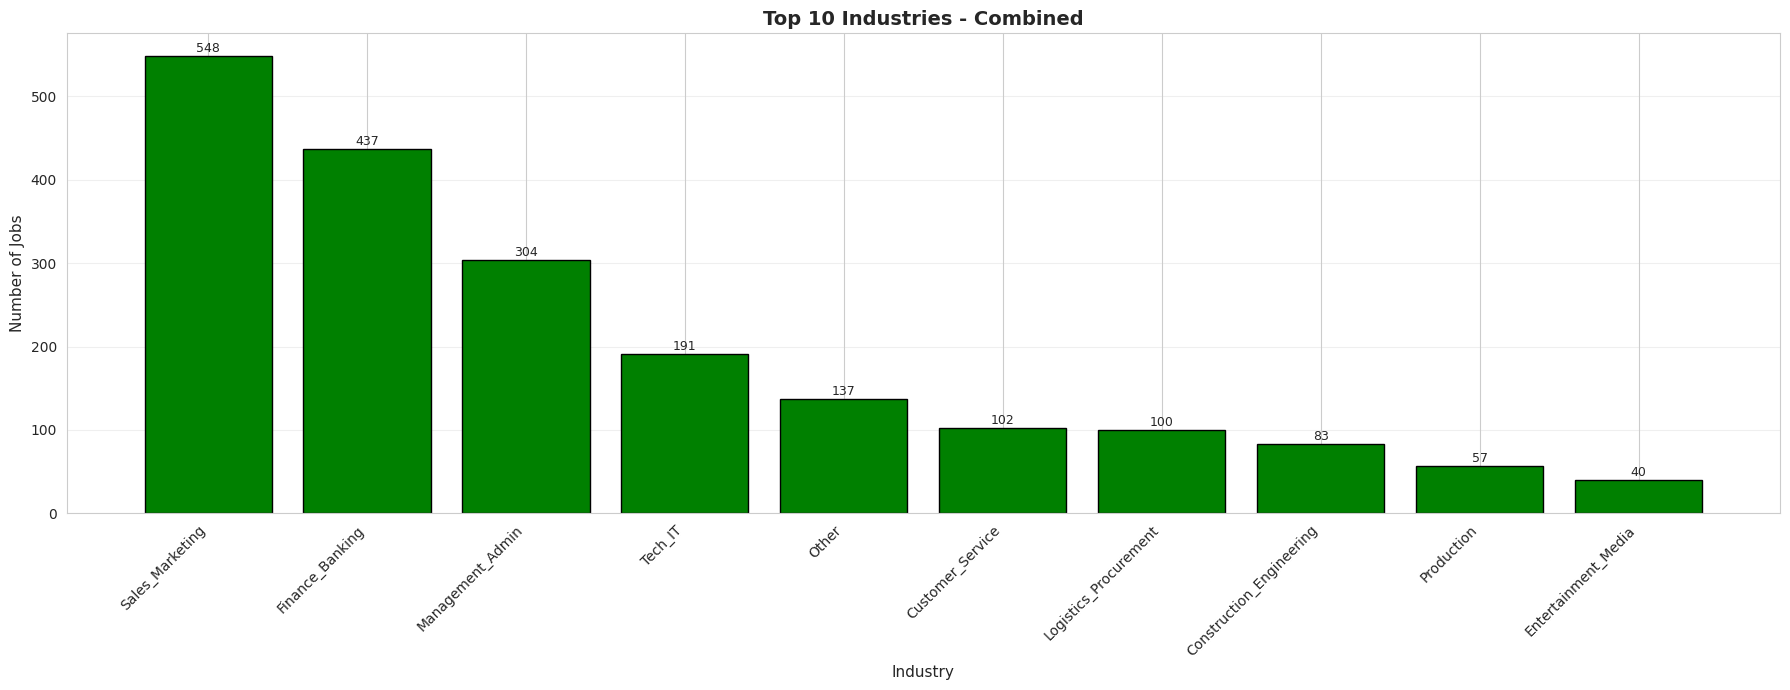

Top industry in combined dataset: Sales_Marketing


In [ ]:
# Assuming df_combined is the combined dataset
industry_counts = df_combined['Industry_Category'].value_counts().head(10)

# Plotting
fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(range(len(industry_counts)), industry_counts.values, color='green', edgecolor='black')
ax.set_title('Top 10 Industries - Combined', fontsize=14, fontweight='bold')
ax.set_xlabel('Industry', fontsize=11)
ax.set_ylabel('Number of Jobs', fontsize=11)
ax.set_xticks(range(len(industry_counts)))
ax.set_xticklabels(industry_counts.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Annotate the bars with the values
for i, value in enumerate(industry_counts.values):
    ax.text(i, value + 5, str(value), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Optionally, print out the top industry
print(f"Top industry in combined dataset: {df_combined['Industry_Category'].value_counts().index[0]}")


**Chart 2:** Yerevan Districts (Combined)

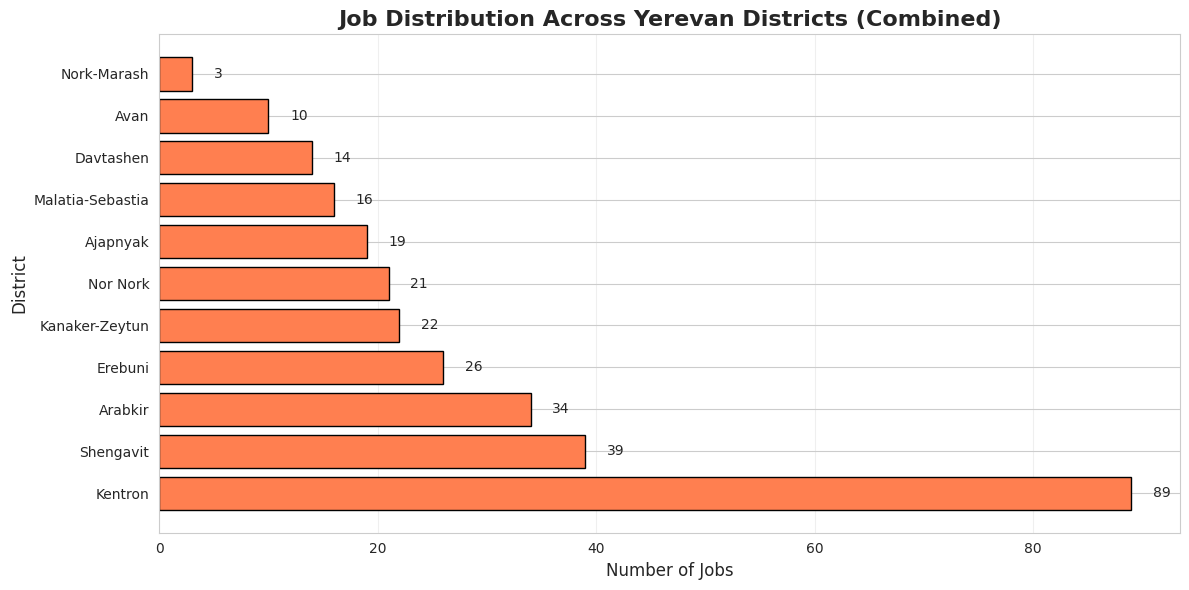

Most jobs in: Kentron district (89 jobs)


In [ ]:
yerevan_jobs = df_combined[df_combined['Is_Yerevan'] == 1]
district_counts = yerevan_jobs['Yerevan_District'].value_counts()
district_counts = district_counts[~district_counts.index.isin(['Not_Yerevan', 'Yerevan_Other'])]

if len(district_counts) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(district_counts)), district_counts.values, color='coral', edgecolor='black')
    plt.title('Job Distribution Across Yerevan Districts (Combined)', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Jobs', fontsize=12)
    plt.ylabel('District', fontsize=12)
    plt.yticks(range(len(district_counts)), district_counts.index)
    plt.grid(axis='x', alpha=0.3)

    for i, value in enumerate(district_counts.values):
        plt.text(value + 2, i, str(value), va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    print(f"Most jobs in: {district_counts.index[0]} district ({district_counts.values[0]} jobs)")

**Chart 3:** Salary Range Distribution (Combined)

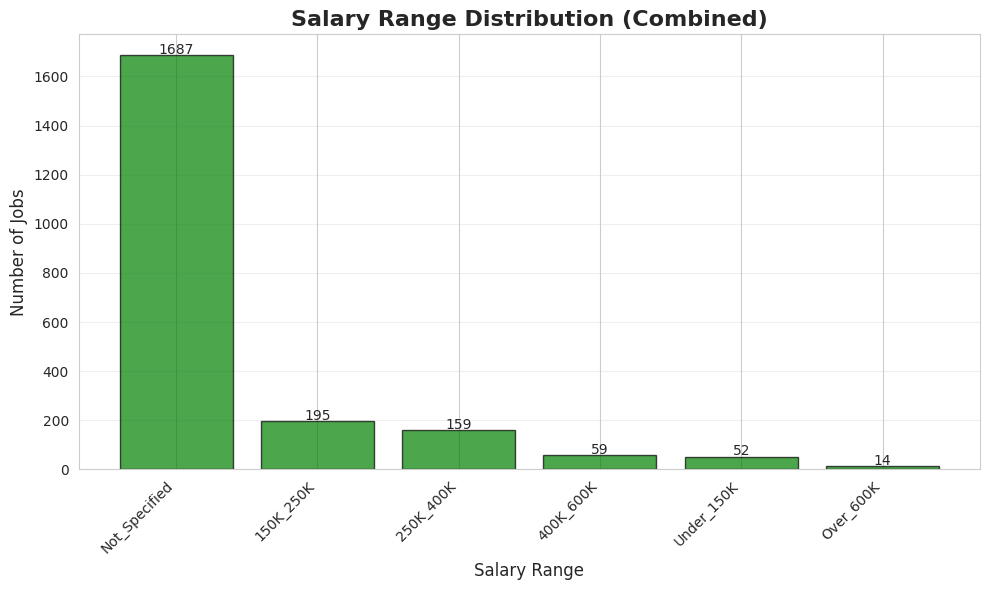

Most common salary range: Not_Specified


In [ ]:
salary_cat_counts = df_combined['Salary_Category'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(range(len(salary_cat_counts)), salary_cat_counts.values, color='green', edgecolor='black', alpha=0.7)
plt.title('Salary Range Distribution (Combined)', fontsize=16, fontweight='bold')
plt.xlabel('Salary Range', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(range(len(salary_cat_counts)), salary_cat_counts.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(salary_cat_counts.values):
    plt.text(i, value + 5, str(value), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Most common salary range: {salary_cat_counts.index[0]}")

**Chart 4:** Jobs by City Category (By Platform)

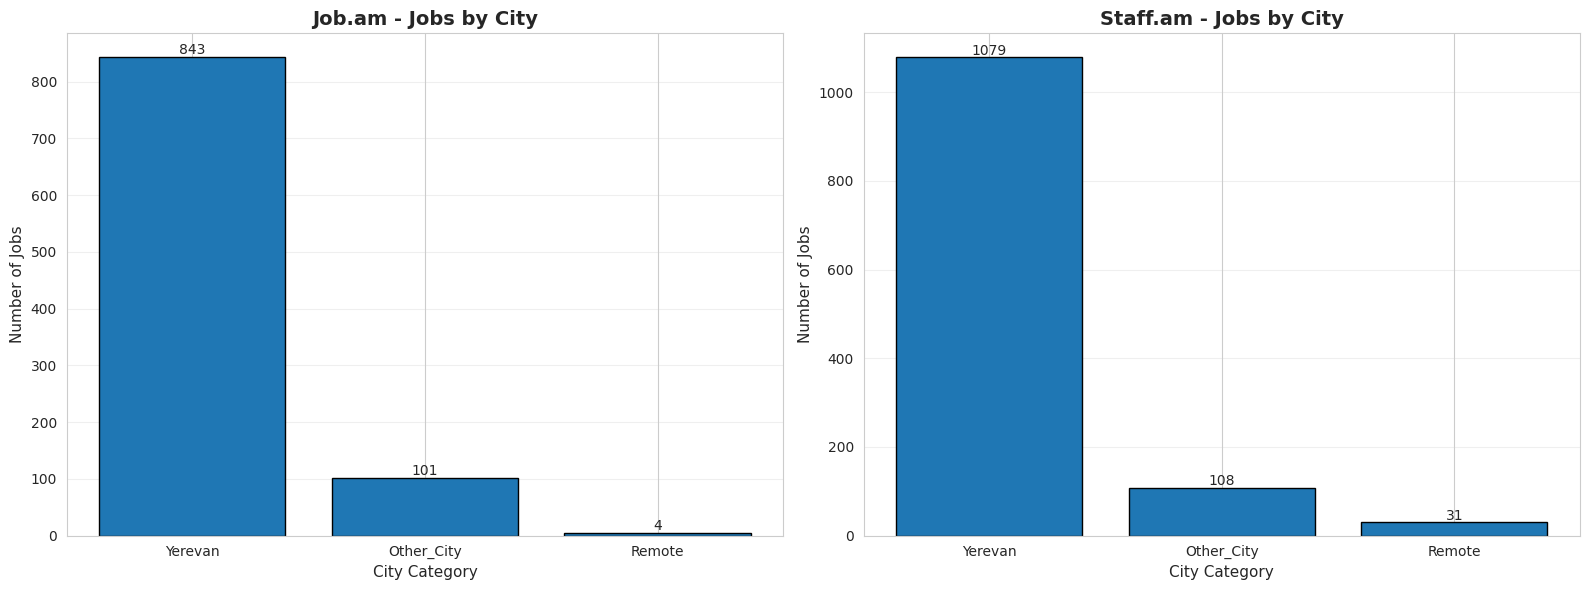

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (platform_name, df) in enumerate([('Job.am', jobam_processed), ('Staff.am', staffam_processed)]):
    city_counts = df['City_Category'].value_counts()

    axes[idx].bar(range(len(city_counts)), city_counts.values, edgecolor='black')
    axes[idx].set_title(f'{platform_name} - Jobs by City', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('City Category', fontsize=11)
    axes[idx].set_ylabel('Number of Jobs', fontsize=11)
    axes[idx].set_xticks(range(len(city_counts)))
    axes[idx].set_xticklabels(city_counts.index, rotation=0)
    axes[idx].grid(axis='y', alpha=0.3)

    for i, value in enumerate(city_counts.values):
        axes[idx].text(i, value + 5, str(value), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

**Chart 5:** Minimum Experience Level Distribution (Combined)

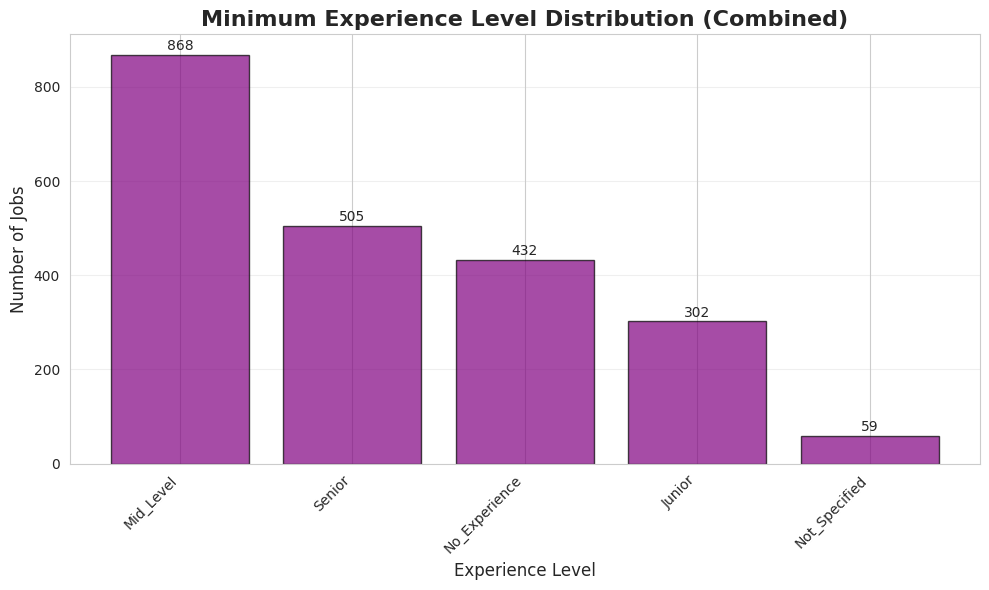

Most common experience level: Mid_Level


In [ ]:
exp_counts = df_combined['Min_Experience_Level'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(range(len(exp_counts)), exp_counts.values, edgecolor='black', color='purple', alpha=0.7)
plt.title('Minimum Experience Level Distribution (Combined)', fontsize=16, fontweight='bold')
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(range(len(exp_counts)), exp_counts.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(exp_counts.values):
    plt.text(i, value + 10, str(value), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Most common experience level: {exp_counts.index[0]}")

**Chart 6:** Employment Type Distribution

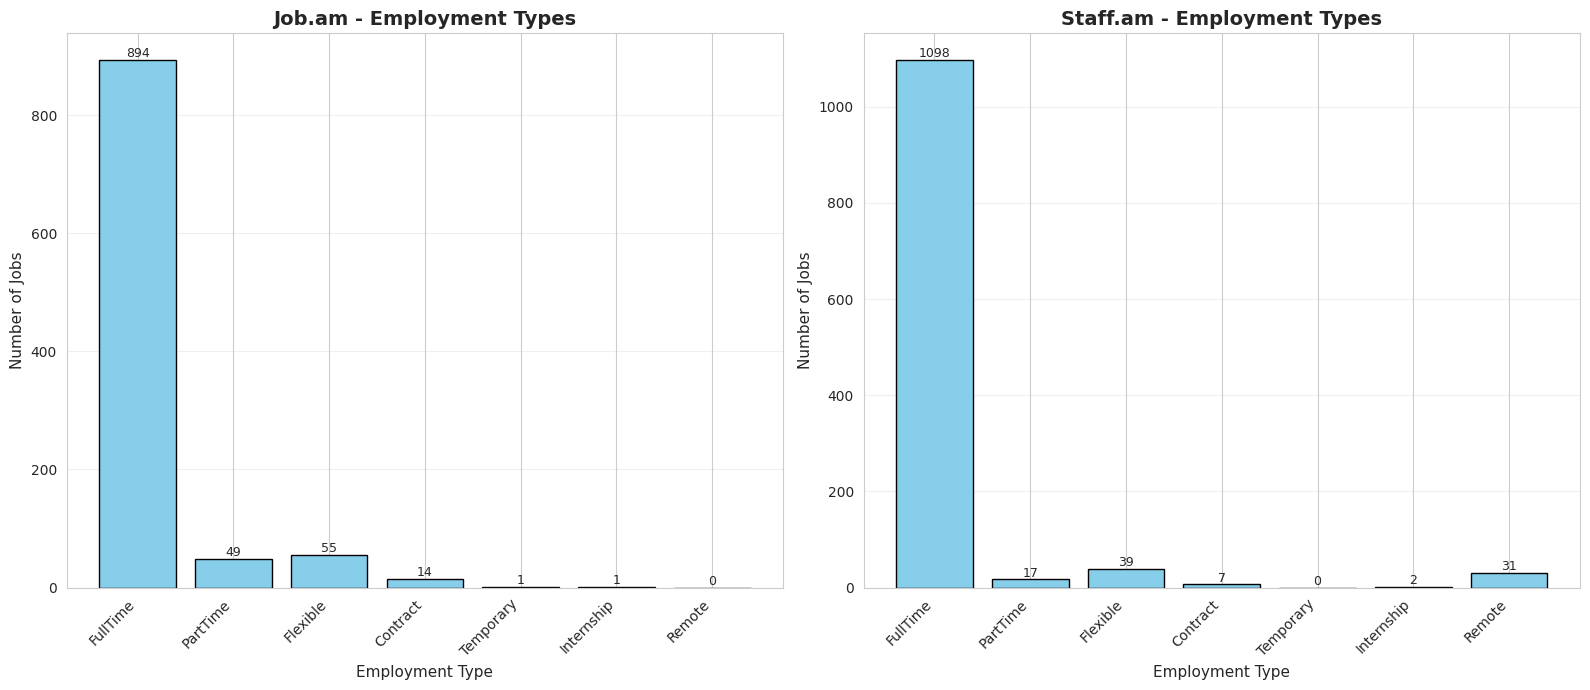

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

employment_types = ['Emp_FullTime', 'Emp_PartTime', 'Emp_Flexible', 'Emp_Contract',
                    'Emp_Temporary', 'Emp_Internship', 'Emp_Remote']

for idx, (platform_name, df) in enumerate([('Job.am', jobam_processed), ('Staff.am', staffam_processed)]):
    emp_counts = {}
    for emp_type in employment_types:
        if emp_type in df.columns:
            emp_counts[emp_type.replace('Emp_', '')] = df[emp_type].sum()

    if emp_counts:
        axes[idx].bar(range(len(emp_counts)), list(emp_counts.values()), edgecolor='black', color='skyblue')
        axes[idx].set_title(f'{platform_name} - Employment Types', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Employment Type', fontsize=11)
        axes[idx].set_ylabel('Number of Jobs', fontsize=11)
        axes[idx].set_xticks(range(len(emp_counts)))
        axes[idx].set_xticklabels(list(emp_counts.keys()), rotation=45, ha='right')
        axes[idx].grid(axis='y', alpha=0.3)

        for i, value in enumerate(emp_counts.values()):
            axes[idx].text(i, value + 5, str(value), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

**Chart 7:** Remote vs Offline Jobs

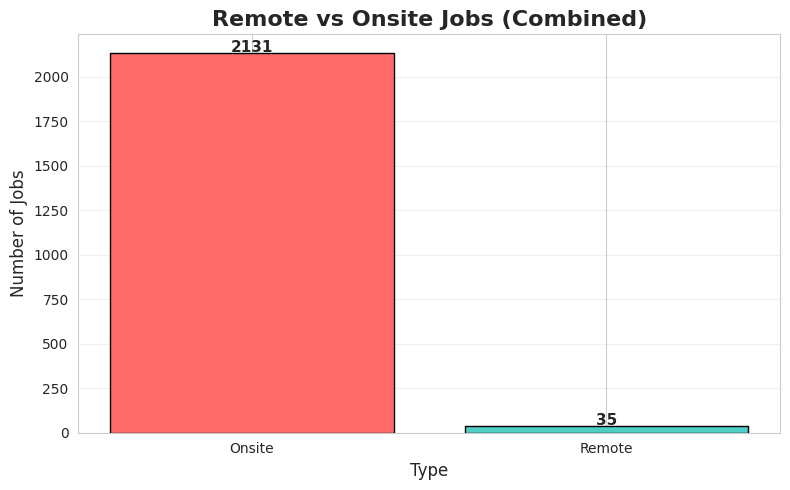

✓ Remote jobs: 35 (1.6%)
✓ Onsite jobs: 2,131 (98.4%)


In [ ]:
remote_counts = df_combined['Is_Remote'].value_counts().sort_index()
labels = ['Onsite', 'Remote']
values = [remote_counts.get(0, 0), remote_counts.get(1, 0)]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, edgecolor='black', color=['#FF6B6B', '#4ECDC4'])
plt.title('Remote vs Onsite Jobs (Combined)', fontsize=16, fontweight='bold')
plt.xlabel('Type', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(values):
    plt.text(i, value + 10, str(value), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

remote_pct = (values[1] / sum(values)) * 100
print(f"✓ Remote jobs: {values[1]:,} ({remote_pct:.1f}%)")
print(f"✓ Onsite jobs: {values[0]:,} ({100-remote_pct:.1f}%)")

**Chart 8:** Top 10 Companies by Job Count

Purpose:
Highlights which companies currently have the most open positions.

Insight:
The tallest bars show the most active recruiters, revealing how concentrated hiring is among top employers

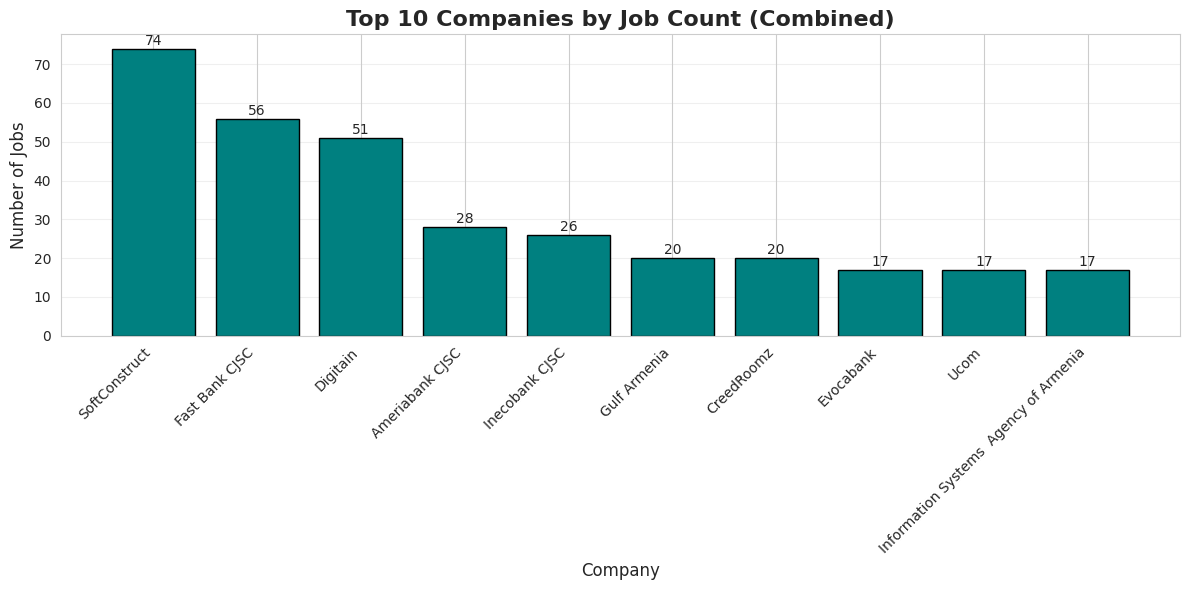

✓ Top hiring company: SoftConstruct (74 jobs)


In [ ]:
company_counts = df_combined['Company name'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.bar(range(len(company_counts)), company_counts.values, edgecolor='black', color='teal')
plt.title('Top 10 Companies by Job Count (Combined)', fontsize=16, fontweight='bold')
plt.xlabel('Company', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(range(len(company_counts)), company_counts.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(company_counts.values):
    plt.text(i, value + 1, str(value), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"✓ Top hiring company: {company_counts.index[0]} ({company_counts.values[0]} jobs)")



**Chart 9:** Average Salary by Experience Level (AMD)

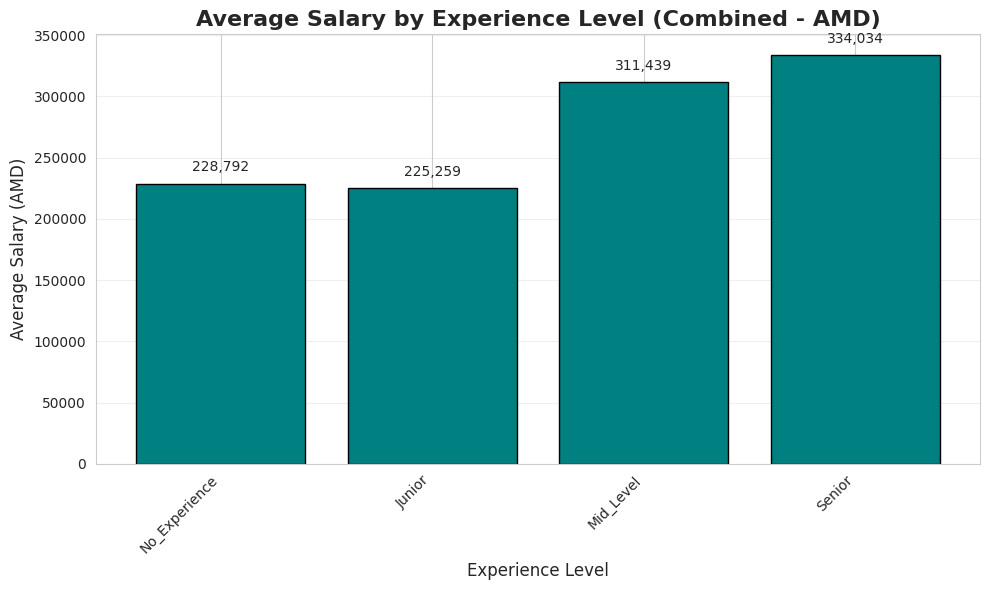

In [ ]:
exp_salary = df_combined[
    (df_combined['Salary currency'] == 'AMD') &
    (df_combined['Min_Experience_Level'] != 'Not_Specified')
].groupby('Min_Experience_Level')['Salary avg'].mean()

exp_order = ['No_Experience', 'Junior', 'Mid_Level', 'Senior']
exp_salary = exp_salary.reindex(exp_order)
exp_salary = exp_salary.dropna()

plt.figure(figsize=(10, 6))
plt.bar(range(len(exp_salary)), exp_salary.values, color='teal', edgecolor='black')
plt.title('Average Salary by Experience Level (Combined - AMD)', fontsize=16, fontweight='bold')
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Average Salary (AMD)', fontsize=12)
plt.xticks(range(len(exp_salary)), exp_salary.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(exp_salary.values):
    plt.text(i, value + 10000, f'{value:,.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

**Chart 10:** Average Applicants per Job by Industry (Top 10)

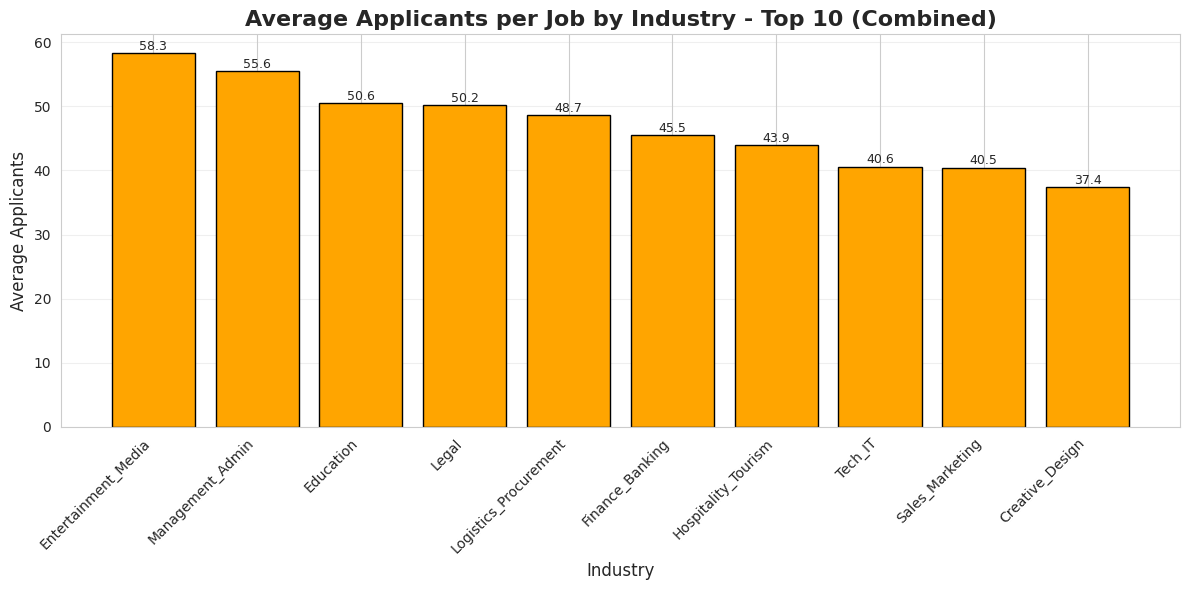

In [ ]:
industry_applicants = df_combined[
    df_combined['Applicants count'] > 0
].groupby('Industry_Category')['Applicants count'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(range(len(industry_applicants)), industry_applicants.values, color='orange', edgecolor='black')
plt.title('Average Applicants per Job by Industry - Top 10 (Combined)', fontsize=16, fontweight='bold')
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Average Applicants', fontsize=12)
plt.xticks(range(len(industry_applicants)), industry_applicants.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(industry_applicants.values):
    plt.text(i, value + 0.5, f'{value:.1f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

**Chart 11:** Average Salary by Yerevan District (AMD)

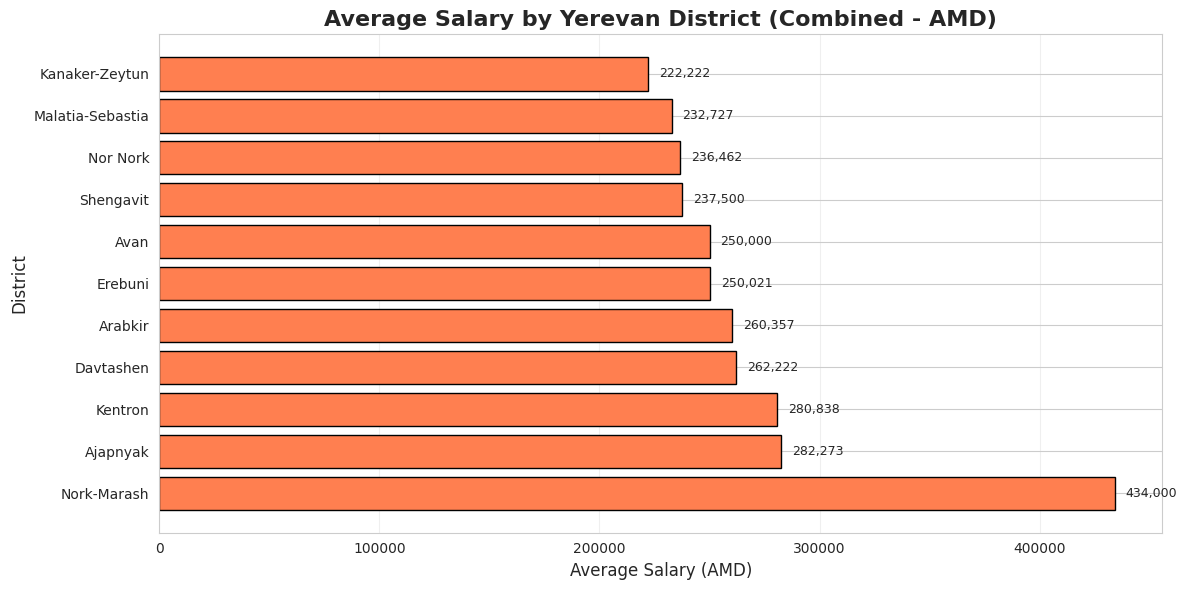

In [ ]:
district_salary = df_combined[
    (df_combined['Salary currency'] == 'AMD') &
    (~df_combined['Yerevan_District'].isin(['Not_Yerevan', 'Yerevan_Other']))
].groupby('Yerevan_District')['Salary avg'].mean().sort_values(ascending=False)

if len(district_salary) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(district_salary)), district_salary.values, color='coral', edgecolor='black')
    plt.title('Average Salary by Yerevan District (Combined - AMD)', fontsize=16, fontweight='bold')
    plt.xlabel('Average Salary (AMD)', fontsize=12)
    plt.ylabel('District', fontsize=12)
    plt.yticks(range(len(district_salary)), district_salary.index)
    plt.grid(axis='x', alpha=0.3)

    for i, value in enumerate(district_salary.values):
        plt.text(value + 5000, i, f'{value:,.0f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

**Chart 12:** Average Salary by Yerevan District (Combined - AMD)

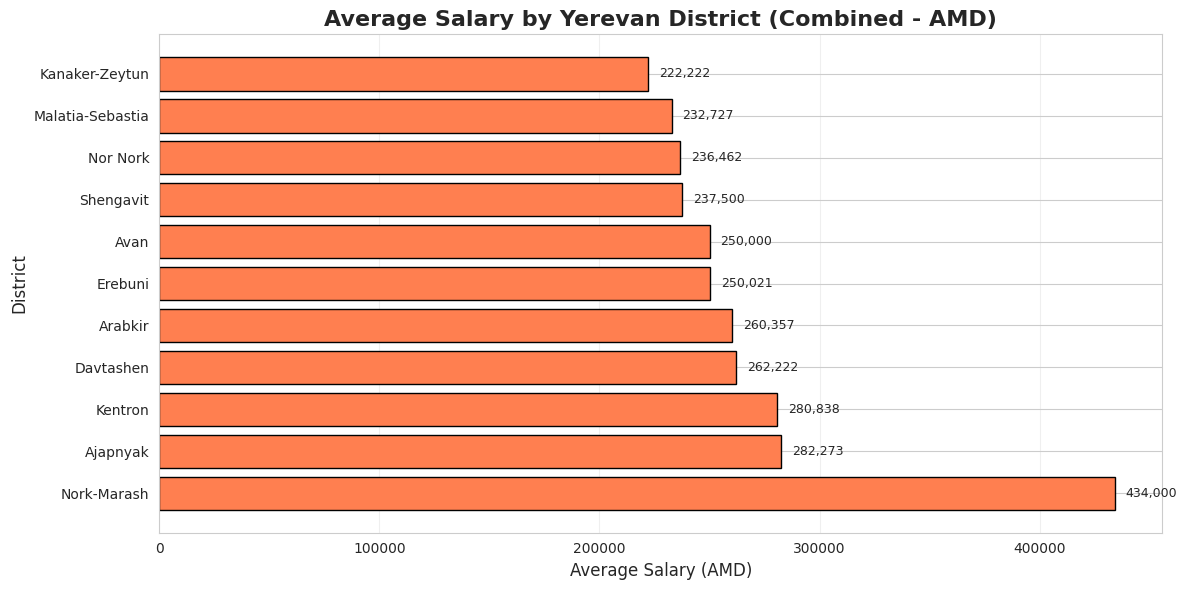

In [ ]:
district_salary = df_combined[
    (df_combined['Salary currency'] == 'AMD') &
    (~df_combined['Yerevan_District'].isin(['Not_Yerevan', 'Yerevan_Other']))
].groupby('Yerevan_District')['Salary avg'].mean().sort_values(ascending=False)

if len(district_salary) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(district_salary)), district_salary.values, color='coral', edgecolor='black')
    plt.title('Average Salary by Yerevan District (Combined - AMD)', fontsize=16, fontweight='bold')
    plt.xlabel('Average Salary (AMD)', fontsize=12)
    plt.ylabel('District', fontsize=12)
    plt.yticks(range(len(district_salary)), district_salary.index)
    plt.grid(axis='x', alpha=0.3)

    for i, value in enumerate(district_salary.values):
        plt.text(value + 5000, i, f'{value:,.0f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

**Chart 13:** verage Competition by Experience Level (Combined)

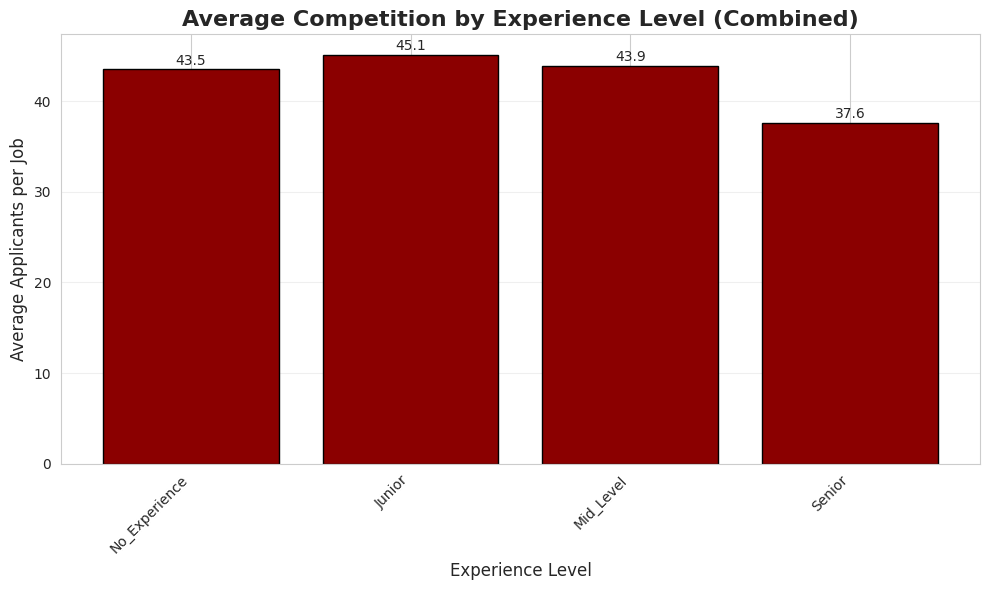

In [ ]:
exp_competition = df_combined[
    (df_combined['Applicants count'] > 0) &
    (df_combined['Min_Experience_Level'] != 'Not_Specified')
].groupby('Min_Experience_Level')['Applicants count'].mean()

exp_competition = exp_competition.reindex(exp_order)
exp_competition = exp_competition.dropna()

plt.figure(figsize=(10, 6))
plt.bar(range(len(exp_competition)), exp_competition.values, color='darkred', edgecolor='black')
plt.title('Average Competition by Experience Level (Combined)', fontsize=16, fontweight='bold')
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Average Applicants per Job', fontsize=12)
plt.xticks(range(len(exp_competition)), exp_competition.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(exp_competition.values):
    plt.text(i, value + 0.5, f'{value:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

**Chart 14:** Average Salary by Industry (AMD)

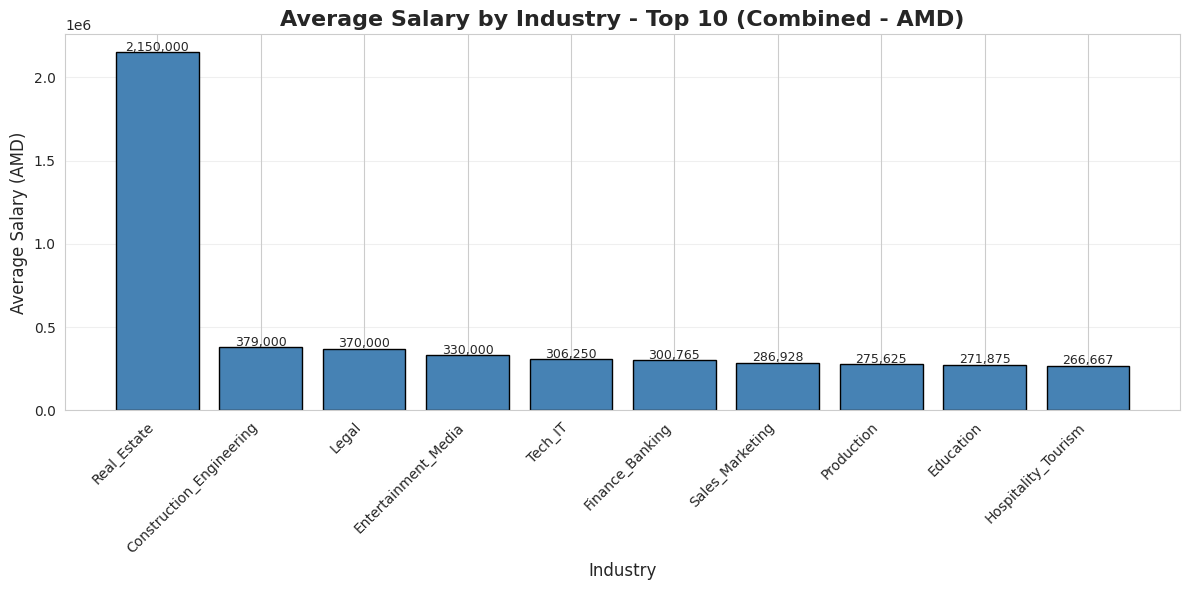

Top paying industry: Real_Estate (2,150,000 AMD)


In [ ]:
industry_salary = df_combined[
    (df_combined['Salary currency'] == 'AMD') &
    (df_combined['Salary avg'].notna()) &
    (df_combined['Industry_Category'] != 'Not_Specified')
].groupby('Industry_Category')['Salary avg'].mean().sort_values(ascending=False).head(10)

if len(industry_salary) > 0:
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(industry_salary)), industry_salary.values, color='steelblue', edgecolor='black')
    plt.title('Average Salary by Industry - Top 10 (Combined - AMD)', fontsize=16, fontweight='bold')
    plt.xlabel('Industry', fontsize=12)
    plt.ylabel('Average Salary (AMD)', fontsize=12)
    plt.xticks(range(len(industry_salary)), industry_salary.index, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    for i, value in enumerate(industry_salary.values):
        plt.text(i, value + 10000, f'{value:,.0f}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print(f"Top paying industry: {industry_salary.index[0]} ({industry_salary.values[0]:,.0f} AMD)")

**Chart 15:** Job Distribution by Platform

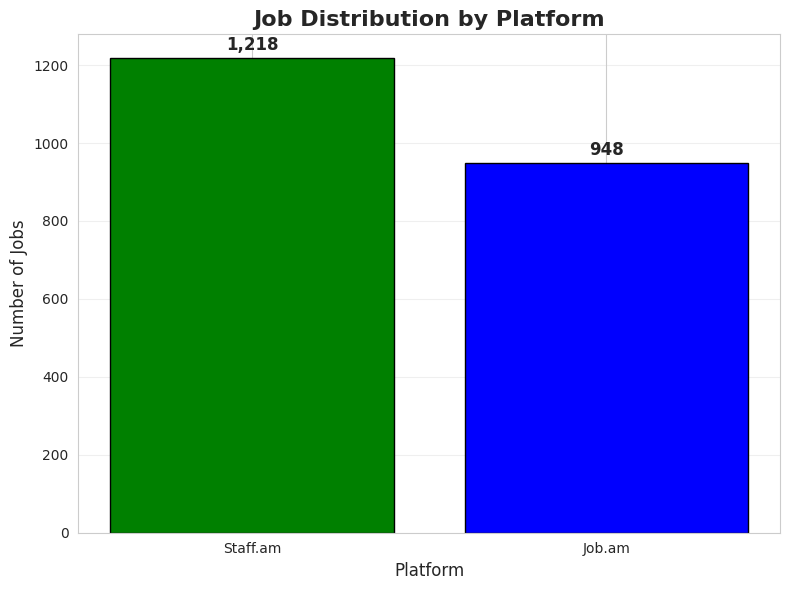

In [ ]:
platform_counts = df_combined['Platform'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(platform_counts.index, platform_counts.values, color=['green', 'blue'], edgecolor='black')
plt.title('Job Distribution by Platform', fontsize=16, fontweight='bold')
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, (platform, value) in enumerate(platform_counts.items()):
    plt.text(i, value + 20, f'{value:,}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Histograms - Distribution analysis**

**Chart 1:** Salary Distribution in Armenia (AMD)

Shows the spread of salaries across all job postings to identify typical pay ranges.

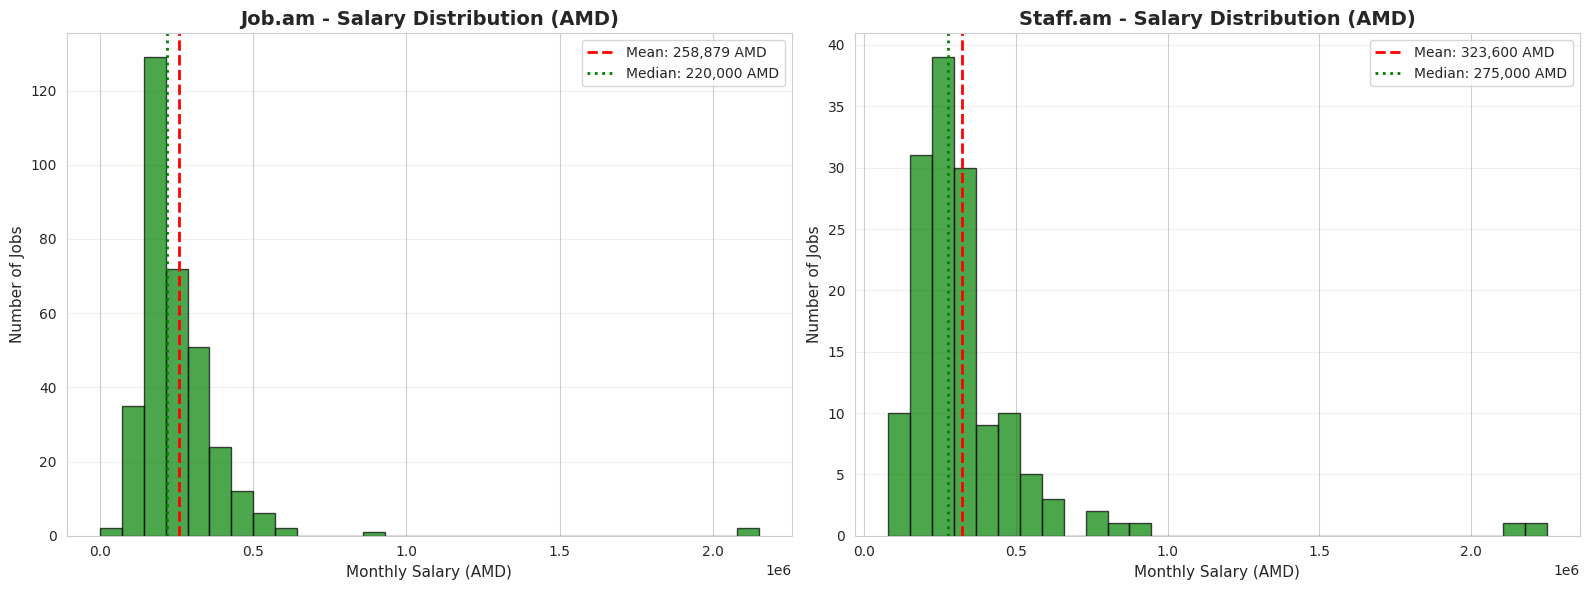

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (platform_name, df) in enumerate([('Job.am', jobam_processed), ('Staff.am', staffam_processed)]):
    salary_amd = df[df['Salary currency'] == 'AMD']['Salary avg'].dropna()

    if len(salary_amd) > 0:
        axes[idx].hist(salary_amd, bins=30, color='green', edgecolor='black', alpha=0.7)
        axes[idx].axvline(salary_amd.mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {salary_amd.mean():,.0f} AMD')
        axes[idx].axvline(salary_amd.median(), color='green', linestyle=':', linewidth=2,
                    label=f'Median: {salary_amd.median():,.0f} AMD')
        axes[idx].set_title(f'{platform_name} - Salary Distribution (AMD)', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Monthly Salary (AMD)', fontsize=11)
        axes[idx].set_ylabel('Number of Jobs', fontsize=11)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Chart 2:** Job Competition Analysis

Shows how many applicants jobs typically receive to gauge competition levels.


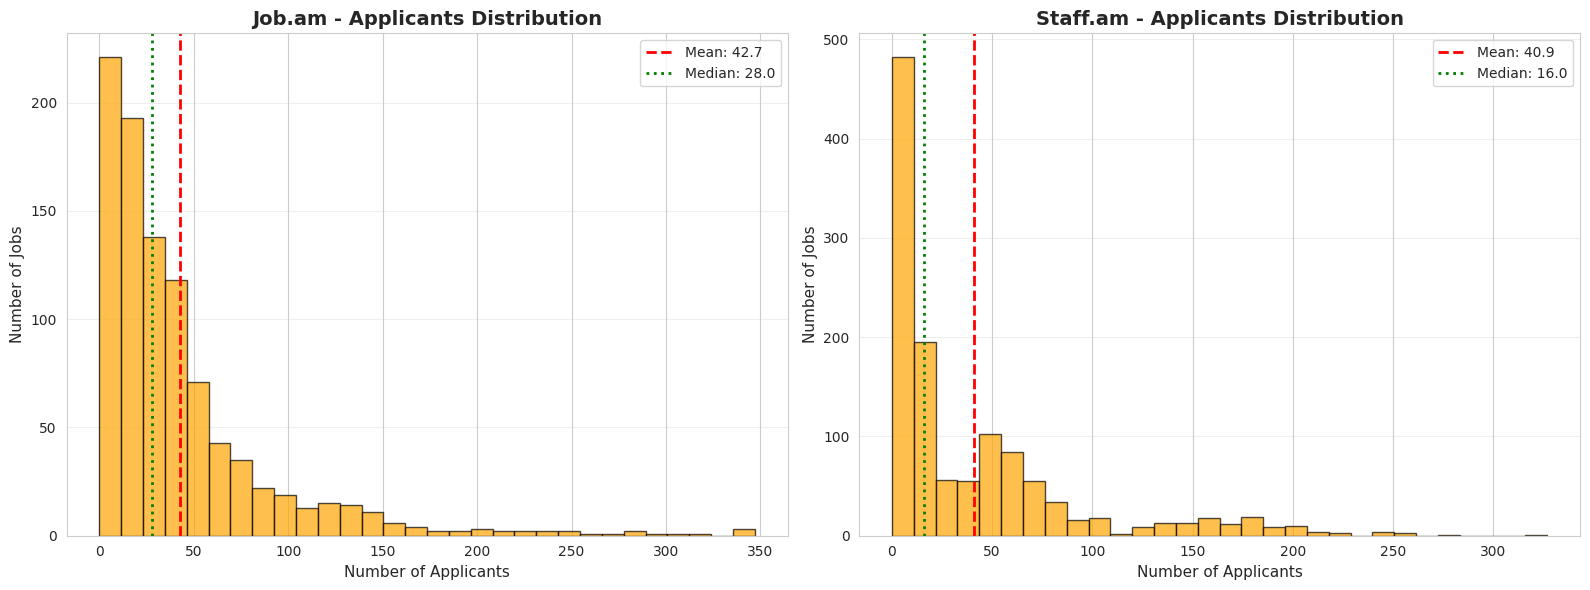

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (platform_name, df) in enumerate([('Job.am', jobam_processed), ('Staff.am', staffam_processed)]):
    applicants = df['Applicants count'].dropna()

    if len(applicants) > 0:
        axes[idx].hist(applicants, bins=30, color='orange', edgecolor='black', alpha=0.7)
        axes[idx].axvline(applicants.mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {applicants.mean():.1f}')
        axes[idx].axvline(applicants.median(), color='green', linestyle=':', linewidth=2,
                    label=f'Median: {applicants.median():.1f}')
        axes[idx].set_title(f'{platform_name} - Applicants Distribution', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Number of Applicants', fontsize=11)
        axes[idx].set_ylabel('Number of Jobs', fontsize=11)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Box plots - Comparing groups**

**Chart 1:** Salary Distribution by Industry

Compares salary ranges across the top 5 industries to identify highest-paying sectors.

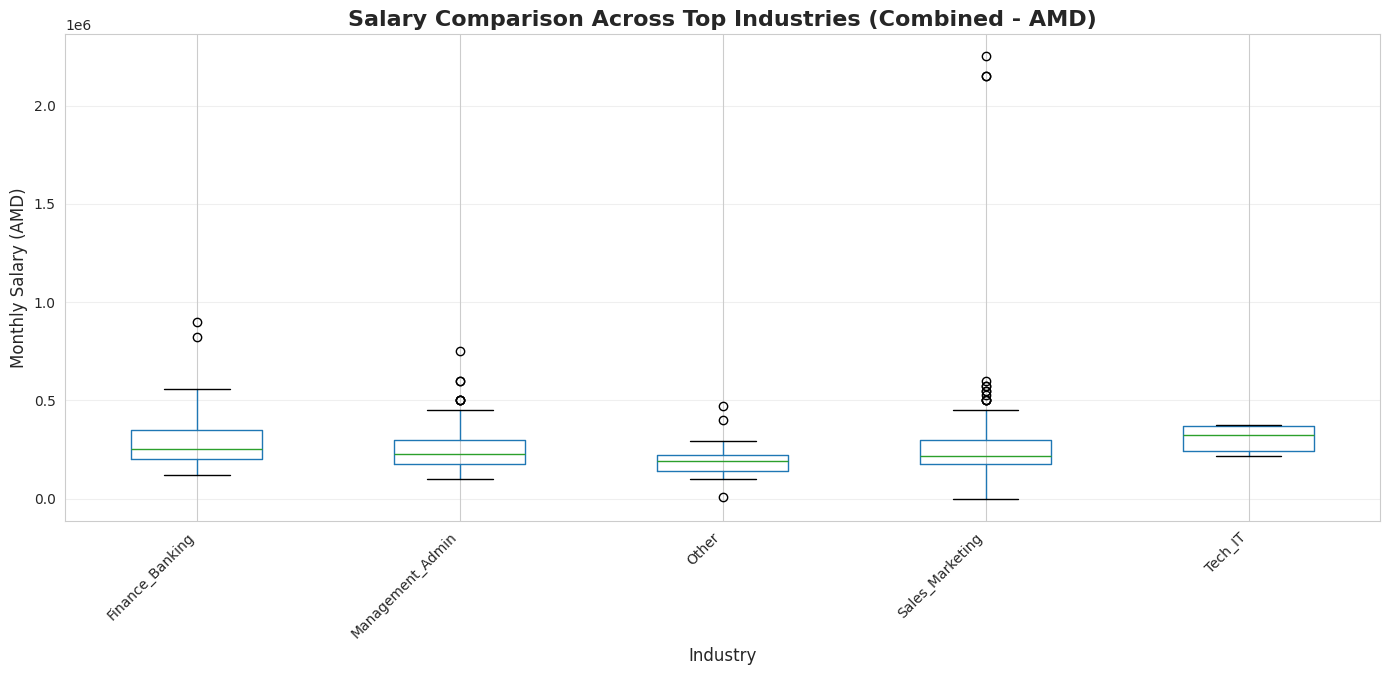

In [ ]:
top_industries = df_combined['Industry_Category'].value_counts().head(5).index
industry_salary_data = df_combined[
    (df_combined['Industry_Category'].isin(top_industries)) &
    (df_combined['Salary currency'] == 'AMD')
]

if len(industry_salary_data) > 0:
    plt.figure(figsize=(14, 7))
    industry_salary_data.boxplot(column='Salary avg', by='Industry_Category', ax=plt.gca())
    plt.title('Salary Comparison Across Top Industries (Combined - AMD)', fontsize=16, fontweight='bold')
    plt.suptitle('')
    plt.xlabel('Industry', fontsize=12)
    plt.ylabel('Monthly Salary (AMD)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

**Chart 2:** Competition Analysis by Experience Level

Shows how applicant numbers vary across experience requirements.

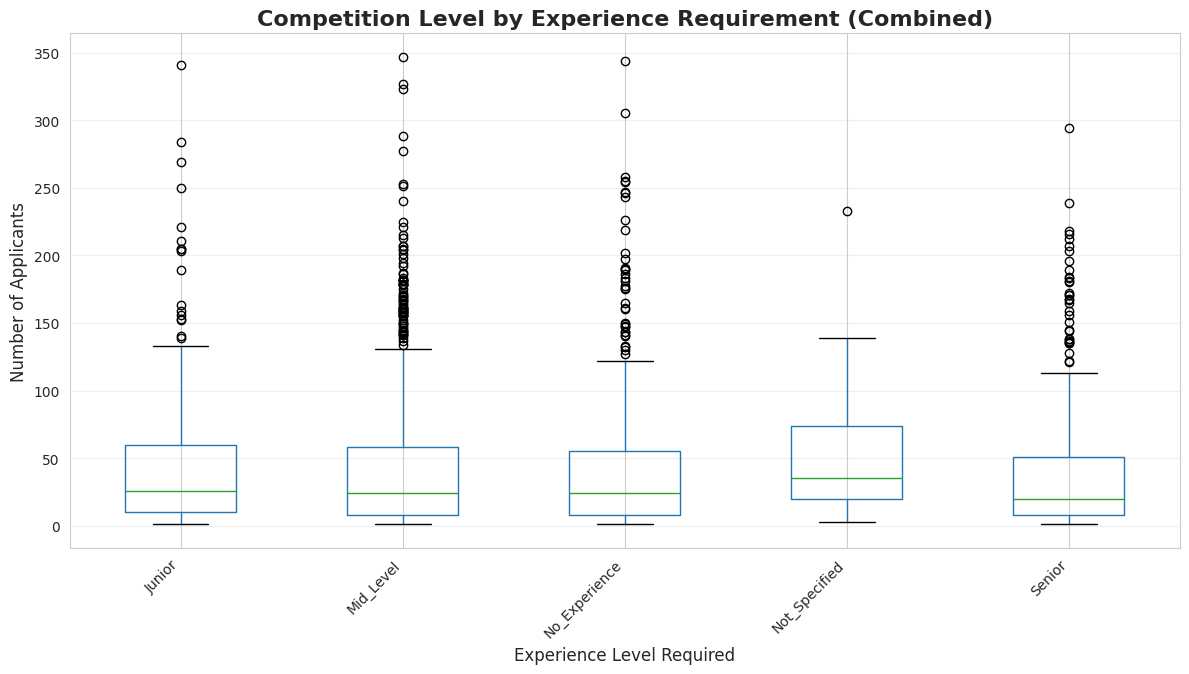

In [ ]:
exp_applicant_data = df_combined[df_combined['Applicants count'] > 0]

if len(exp_applicant_data) > 0:
    plt.figure(figsize=(12, 7))
    exp_applicant_data.boxplot(column='Applicants count', by='Min_Experience_Level', ax=plt.gca())
    plt.title('Competition Level by Experience Requirement (Combined)', fontsize=16, fontweight='bold')
    plt.suptitle('')
    plt.xlabel('Experience Level Required', fontsize=12)
    plt.ylabel('Number of Applicants', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

**Chart 3:** Salary Distribution by Platform (AMD)

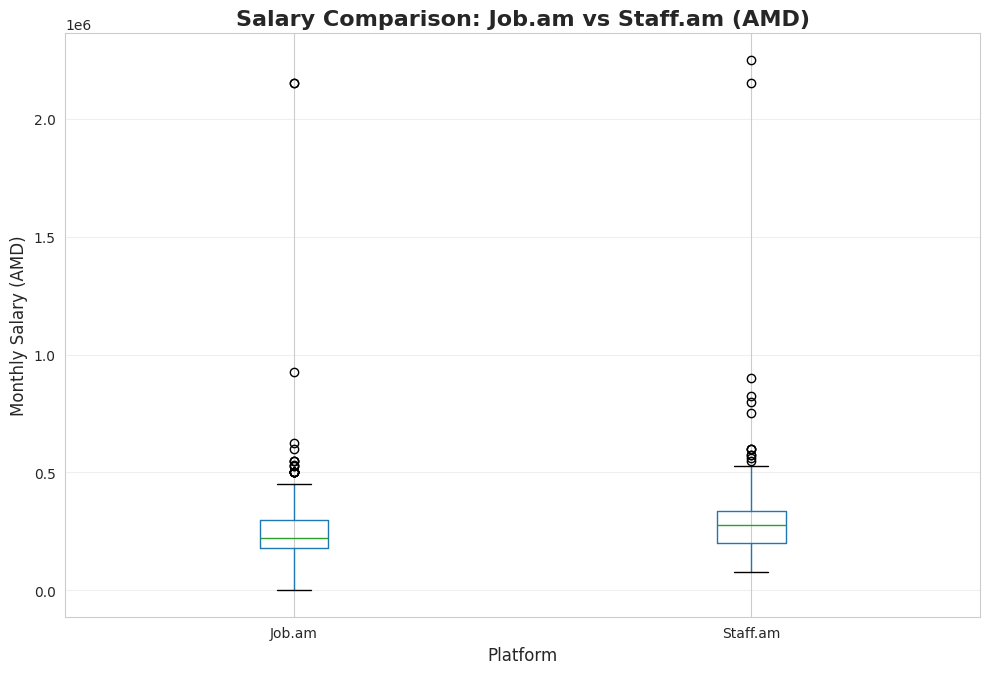

In [ ]:
platform_salary_data = df_combined[df_combined['Salary currency'] == 'AMD']

if len(platform_salary_data) > 0:
    plt.figure(figsize=(10, 7))
    platform_salary_data.boxplot(column='Salary avg', by='Platform', ax=plt.gca())
    plt.title('Salary Comparison: Job.am vs Staff.am (AMD)', fontsize=16, fontweight='bold')
    plt.suptitle('')
    plt.xlabel('Platform', fontsize=12)
    plt.ylabel('Monthly Salary (AMD)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

**Scatter plots - Showing relationships**

**Chart 1:** Salary vs Applicants (By Platform)

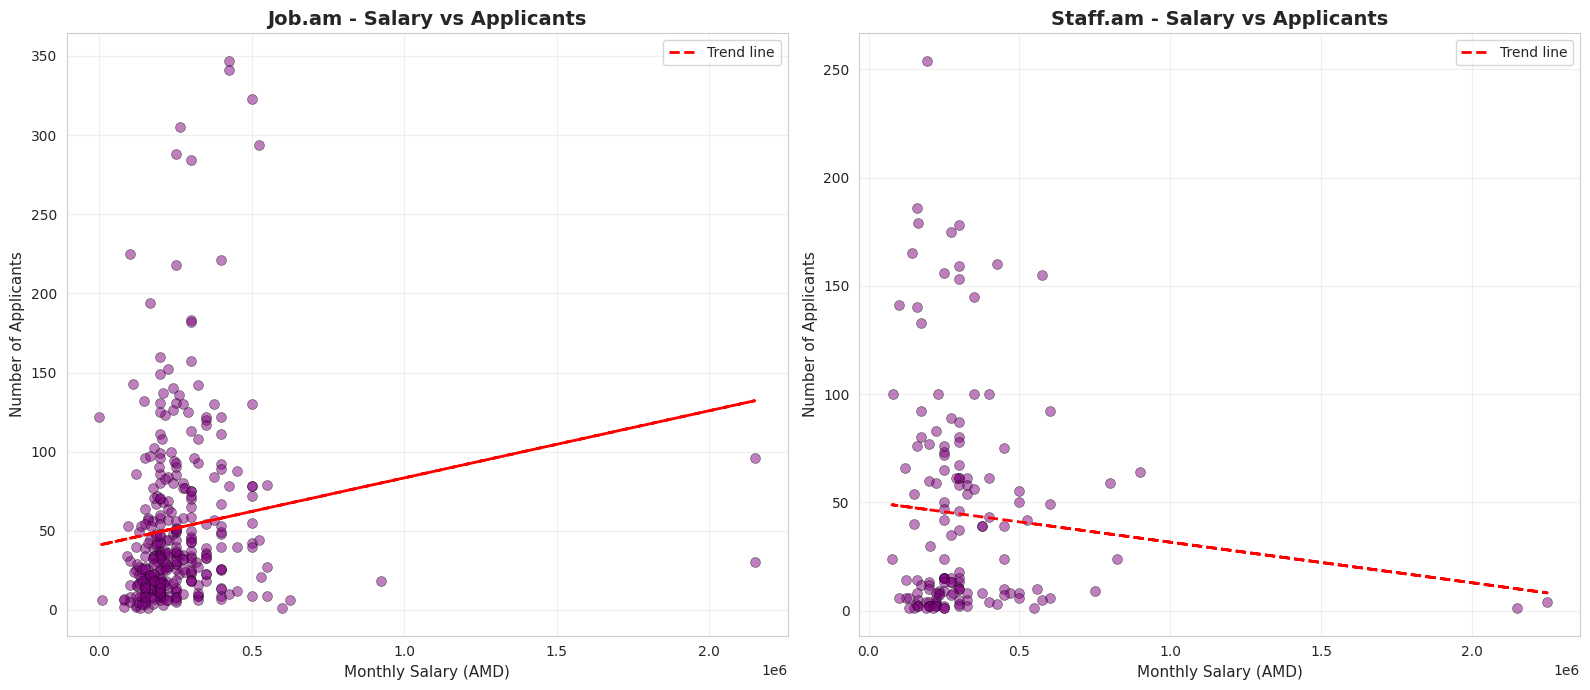

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, (platform_name, df) in enumerate([('Job.am', jobam_processed), ('Staff.am', staffam_processed)]):
    scatter_data = df[
        (df['Salary currency'] == 'AMD') &
        (df['Applicants count'] > 0)
    ][['Salary avg', 'Applicants count']].dropna()

    if len(scatter_data) > 1:
        axes[idx].scatter(scatter_data['Salary avg'], scatter_data['Applicants count'],
                    alpha=0.5, s=50, color='purple', edgecolor='black', linewidth=0.5)

        # Trend line
        z = np.polyfit(scatter_data['Salary avg'], scatter_data['Applicants count'], 1)
        p = np.poly1d(z)
        axes[idx].plot(scatter_data['Salary avg'], p(scatter_data['Salary avg']),
                 "r--", linewidth=2, label='Trend line')

        axes[idx].set_title(f'{platform_name} - Salary vs Applicants', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Monthly Salary (AMD)', fontsize=11)
        axes[idx].set_ylabel('Number of Applicants', fontsize=11)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Chart 22:** Salary vs Applicants (Combined with Platform Colors)

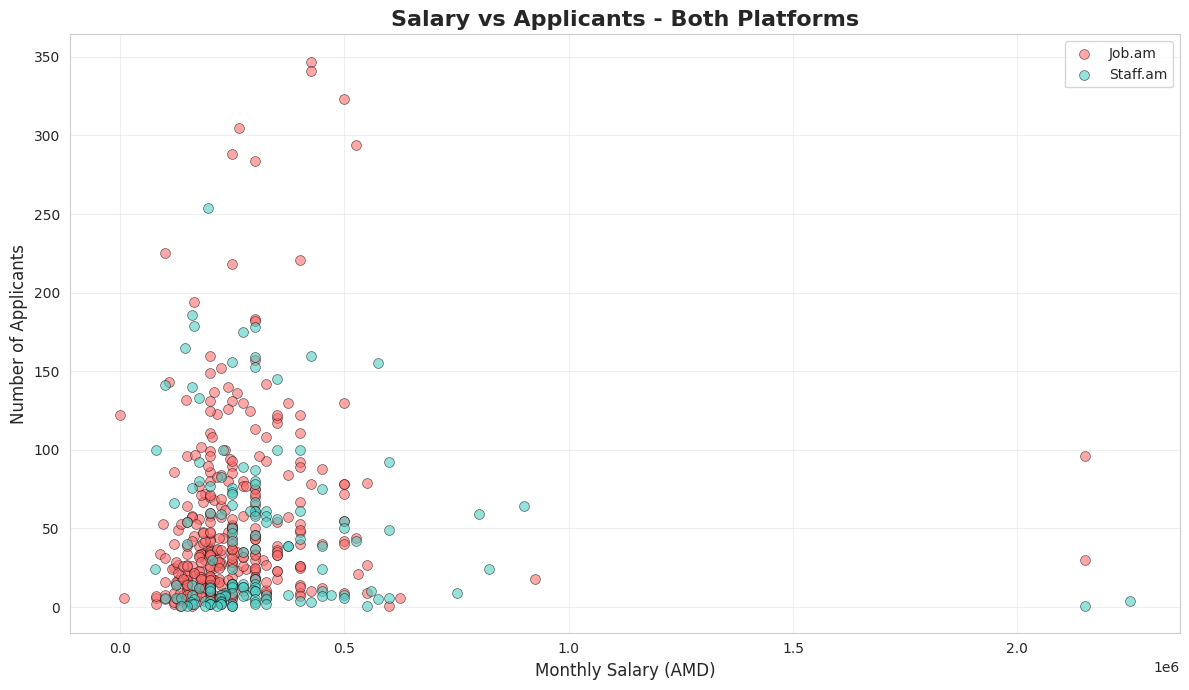

In [ ]:
scatter_combined = df_combined[
    (df_combined['Salary currency'] == 'AMD') &
    (df_combined['Applicants count'] > 0)
][['Salary avg', 'Applicants count', 'Platform']].dropna()

if len(scatter_combined) > 1:
    plt.figure(figsize=(12, 7))

    for platform, color in [('Job.am', '#FF6B6B'), ('Staff.am', '#4ECDC4')]:
        platform_data = scatter_combined[scatter_combined['Platform'] == platform]
        plt.scatter(platform_data['Salary avg'], platform_data['Applicants count'],
                   alpha=0.6, s=50, color=color, edgecolor='black', linewidth=0.5, label=platform)

    plt.title('Salary vs Applicants - Both Platforms', fontsize=16, fontweight='bold')
    plt.xlabel('Monthly Salary (AMD)', fontsize=12)
    plt.ylabel('Number of Applicants', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
df.head()

,Job name,Company name,Location,Employment type,Work experience,Industry,Salary period,Salary min,Salary max,Salary currency,...,Sal_Not_Specified,Sal_Over_600K,Sal_Under_150K,Salary avg_Standardized,Applicants count_Standardized,Salary_Range_Width_Standardized,Salary avg_Scaled,Applicants count_Scaled,Salary_Range_Width_Scaled,Platform
0,Middle IT specialist,Globbing,Yerevan,Full time,Mid level,IT Support/Technician,NaN,NaN,NaN,NaN,...,True,False,False,NaN,5.504771,NaN,NaN,1.000000,NaN,Staff.am
1,русскоговорящий/ англоговорящий гид-водитель,Armenia Holiday,Yerevan,Full time,Mid level,Tourism/Hospitality/HoReCa,NaN,NaN,NaN,NaN,...,True,False,False,NaN,4.542887,NaN,NaN,0.847095,NaN,Staff.am
2,Assistant director,Lomano,Yerevan,Full time,Not defined,Administrative/office-work,NaN,NaN,NaN,NaN,...,True,False,False,NaN,4.119658,NaN,NaN,0.779817,NaN,Staff.am
3,Accountant,Prodigi,Yerevan,Full time,Not defined,Accounting/Bookkeeping/Cash register,Monthly,180000.0,210000.0,AMD,...,False,False,False,-0.344119,4.100421,-0.21308,0.086514,0.776758,0.008108,Staff.am
4,Outbound Sales Representative (Remote with Ini...,Hundred CJSC,Yerevan,Full time,Mid level,Sales/service management,NaN,NaN,NaN,NaN,...,True,False,False,NaN,4.081183,NaN,NaN,0.773700,NaN,Staff.am


# **6.1th Stage: ML Models Training: Clustering**

This stage focuses on building and evaluating clustering models using the prepared dataset. Three clustering algorithms — K-Means and Hierarchical Clustering — were applied to identify natural groupings in the data. Model parameters, such as the number of clusters or distance metrics, were optimized to improve clustering quality. Cluster performance was evaluated using metrics like silhouette score, Calinski-Harabasz index, and Davies-Bouldin index.

Cell 1: Import Libraries and Load Data

In [ ]:
# Import necessary libraries for clustering and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the preprocessed data
jobam_df = pd.read_csv('jobam_processed.csv')
staffam_df = pd.read_csv('staffam_processed.csv')

print(f"Job.am dataset: {jobam_df.shape}")
print(f"Staff.am dataset: {staffam_df.shape}")

Job.am dataset: (948, 72)
Staff.am dataset: (1218, 72)


What this cell does: Sets up the environment by importing all necessary libraries for clustering analysis, data manipulation, and visualization. Loads the preprocessed datasets from both job platforms.

Cell 2: Feature Selection for Clustering

In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# Load the preprocessed data (datasets are already cleaned & scaled)
jobam_df = pd.read_csv('jobam_processed.csv')
staffam_df = pd.read_csv('staffam_processed.csv')


def select_clustering_features(df, dataset_name):
    """
    Select relevant numerical and encoded features for clustering.
    Assumes preprocessing (scaling, encoding) is already completed.
    """
    df_copy = df.copy()

    # Drop original string and identifier columns
    columns_to_drop_entirely = [
        'Job name', 'Company name', 'Location', 'Employment type', 'Work experience',
        'Industry', 'Salary period', 'Salary min', 'Salary max', 'Salary currency',
        'Salary_Category',
        'Min_Experience_Level',
        'Yerevan_District',
        'City_Category',
        'Competition_Level',
        'Job URL', 'Has Salary Info', 'Platform',
        'Experience_Level_For_Scaling'
    ]

    df_copy = df_copy.drop(
        columns=[col for col in columns_to_drop_entirely if col in df_copy.columns]
    )

    # Convert boolean columns to integer
    for col in df_copy.select_dtypes(include='bool').columns:
        df_copy[col] = df_copy[col].astype(int)

    # Final feature list
    final_feature_names = []

    # Scaled numerical features from previous stages
    final_feature_names.extend([
        'Salary avg_Standardized',
        'Applicants count_Standardized',
        'Salary_Range_Width_Standardized'
    ])

    # Encoded experience level
    if 'Experience_Level_Encoded' in df_copy.columns:
        final_feature_names.append('Experience_Level_Encoded')

    # One-hot and binary features
    for prefix in ['Salary_Negotiable', 'Is_Yerevan', 'Is_Remote',
                   'Exp_', 'Emp_', 'Ind_', 'City_', 'Sal_']:
        final_feature_names.extend(
            [col for col in df_copy.columns if col.startswith(prefix)]
        )

    final_feature_names = sorted(set(final_feature_names))
    existing_features = [col for col in final_feature_names if col in df_copy.columns]

    feature_matrix = df_copy[existing_features].fillna(0)

    # Safety check: ensure numeric-only matrix
    non_numeric_cols = feature_matrix.select_dtypes(exclude=np.number).columns.tolist()
    if non_numeric_cols:
        print(f"WARNING ({dataset_name}): Non-numeric columns found → coerced")
        feature_matrix = feature_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)

    print(f"{dataset_name} - Selected {len(existing_features)} features")
    print(f"  - Scaled numerical: {len([f for f in existing_features if f.endswith('_Standardized')])}")
    print(f"  - Encoded experience: {'Experience_Level_Encoded' in existing_features}")
    print(f"  - One-hot / binary features: {len(existing_features)}")

    return feature_matrix, existing_features


# Select clustering features
jobam_features, jobam_feature_names = select_clustering_features(jobam_df, "Job.am")
staffam_features, staffam_feature_names = select_clustering_features(staffam_df, "Staff.am")

Job.am - Selected 45 features
  - Scaled numerical: 3
  - Encoded experience: True
  - One-hot / binary features: 45
Staff.am - Selected 45 features
  - Scaled numerical: 3
  - Encoded experience: True
  - One-hot / binary features: 45


In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# Load ALREADY preprocessed data
jobam_processed = pd.read_csv('jobam_processed.csv')
staffam_processed = pd.read_csv('staffam_processed.csv')

print(jobam_processed.shape)
print(staffam_processed.shape)

(948, 72)
(1218, 72)


What this cell does: Selects the most relevant features for clustering analysis including salary information, experience levels, employment types, location data, and industry categories. This creates clean feature matrices ready for clustering algorithms.

Cell 3: Data Splitting (80%-20% Train-Test Split)



In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset(features_df, original_df, test_size=0.2, random_state=42):
    """
    Split dataset into training and testing sets
    """
    # Split the data
    X_train, X_test, idx_train, idx_test = train_test_split(
        features_df, features_df.index,
        test_size=test_size,
        random_state=random_state,
        stratify=None  # We'll use random splitting for unsupervised learning
    )

    # Get original data for interpretation
    train_original = original_df.iloc[idx_train]
    test_original = original_df.iloc[idx_test]

    return X_train, X_test, train_original, test_original, idx_train, idx_test


# Split Job.am data
jobam_X_train, jobam_X_test, jobam_train_orig, jobam_test_orig, jobam_train_idx, jobam_test_idx = split_dataset(
    jobam_features, jobam_df, test_size=0.2, random_state=42
)

# Split Staff.am data
staffam_X_train, staffam_X_test, staffam_train_orig, staffam_test_orig, staffam_train_idx, staffam_test_idx = split_dataset(
    staffam_features, staffam_df, test_size=0.2, random_state=42
)

print("Data Split Summary:")
print(f"Job.am - Train: {jobam_X_train.shape} jobs, Test: {jobam_X_test.shape} jobs")
print(f"Staff.am - Train: {staffam_X_train.shape} jobs, Test: {staffam_X_test.shape} jobs")

Data Split Summary:
Job.am - Train: (758, 45) jobs, Test: (190, 45) jobs
Staff.am - Train: (974, 45) jobs, Test: (244, 45) jobs


What this cell does: Splits both datasets into 80% training and 20% testing sets. This allows us to train clustering models on one portion and evaluate their performance on unseen data.

Cell 4: Optimal Number of Clusters Detection


--- Job.am Training: dtypes of input X before KMeans fit ---
Series([], dtype: object)
--- End dtypes ---



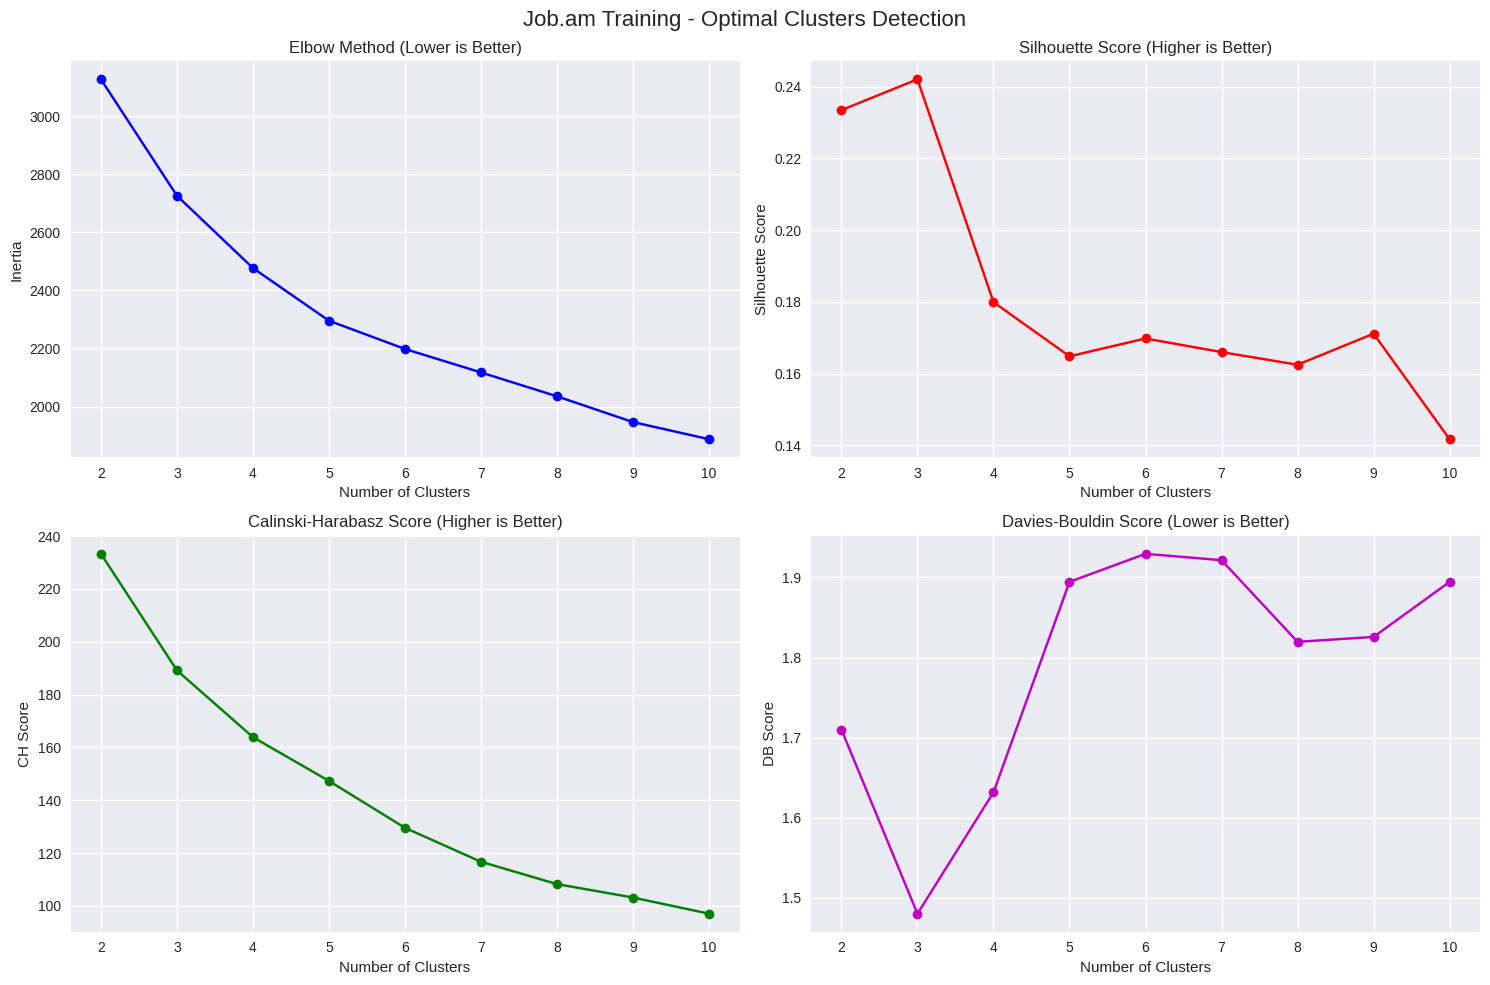

Job.am Training - Optimal clusters:
  Silhouette Score: 3 clusters
  Calinski-Harabasz: 2 clusters
  Davies-Bouldin: 3 clusters

--- Staff.am Training: dtypes of input X before KMeans fit ---
Series([], dtype: object)
--- End dtypes ---



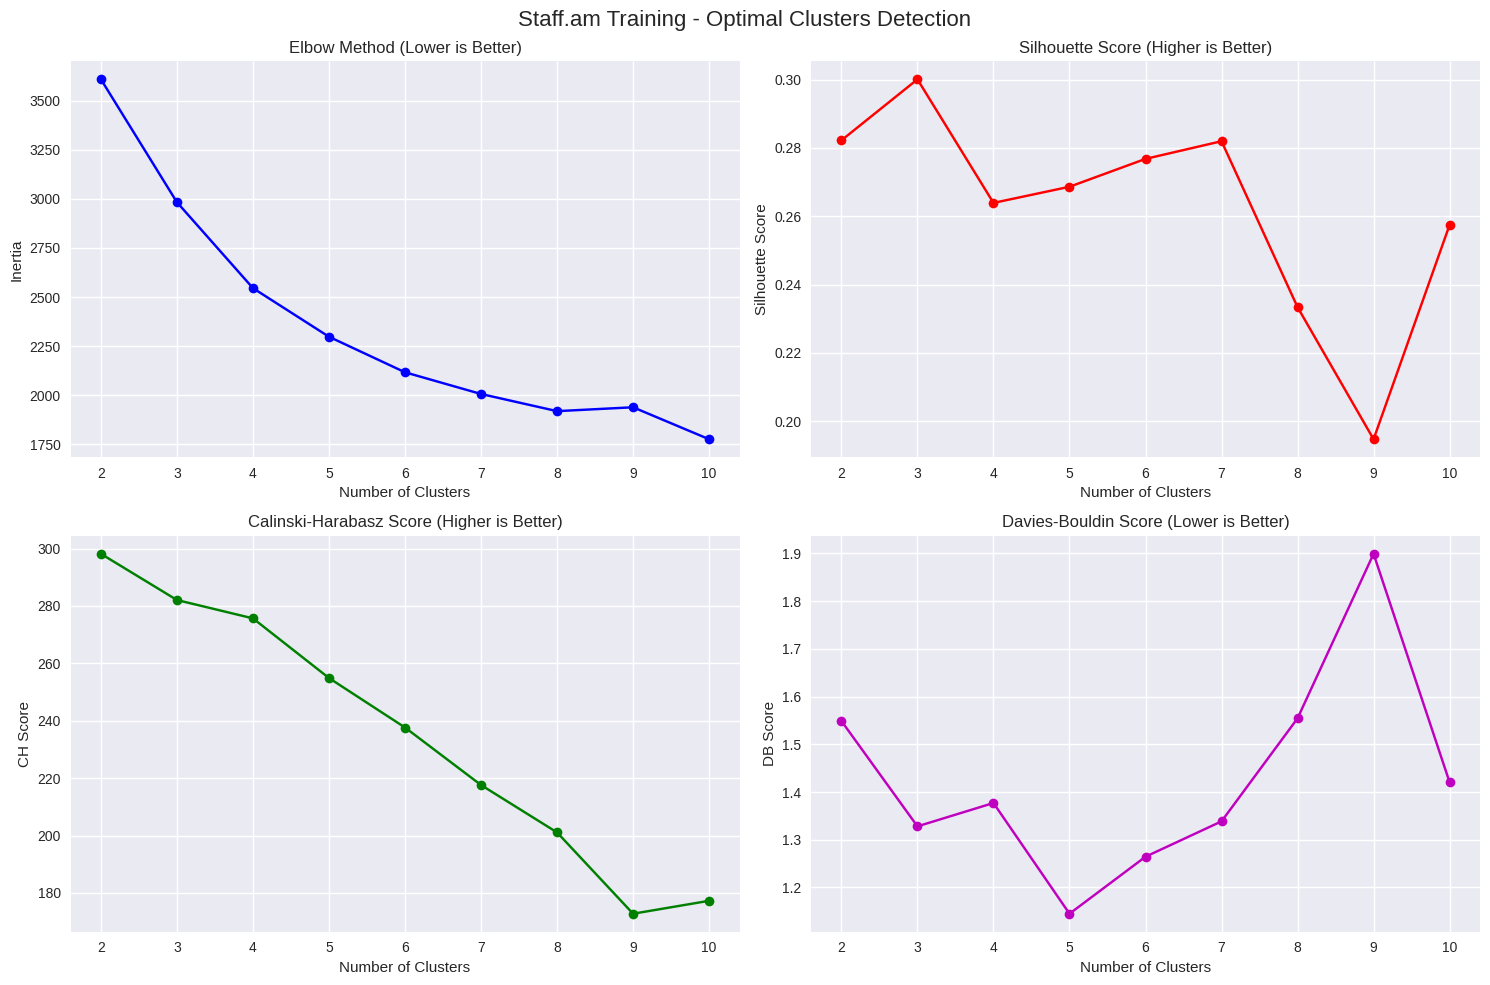

Staff.am Training - Optimal clusters:
  Silhouette Score: 3 clusters
  Calinski-Harabasz: 2 clusters
  Davies-Bouldin: 5 clusters


In [ ]:
import matplotlib.pyplot as plt

def find_optimal_clusters(X, max_clusters=10, dataset_name="Dataset"):
    """
    Use multiple methods to find optimal number of clusters
    """
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []

    K_range = range(2, max_clusters + 1)

    # Debugging step: print dtypes of the input DataFrame
    print(f"\n--- {dataset_name}: dtypes of input X before KMeans fit ---")
    print(X.dtypes[X.dtypes == 'object'])
    print(f"--- End dtypes ---\n")

    # Removed temporary X_numeric coercion block; the fix should be in feature selection.
    # If non-numeric columns are still present here, KMeans will raise an error, which is desired behavior.

    for k in K_range:
        # Fit K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)

        # Calculate metrics
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(X, cluster_labels))
        davies_bouldin_scores.append(davies_bouldin_score(X, cluster_labels))

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{dataset_name} - Optimal Clusters Detection', fontsize=16)

    # Elbow method
    axes[0,0].plot(K_range, inertias, 'bo-')
    axes[0,0].set_title('Elbow Method (Lower is Better)')
    axes[0,0].set_xlabel('Number of Clusters')
    axes[0,0].set_ylabel('Inertia')
    axes[0,0].grid(True)

    # Silhouette score
    axes[0,1].plot(K_range, silhouette_scores, 'ro-')
    axes[0,1].set_title('Silhouette Score (Higher is Better)')
    axes[0,1].set_xlabel('Number of Clusters')
    axes[0,1].set_ylabel('Silhouette Score')
    axes[0,1].grid(True)

    # Calinski-Harabasz score
    axes[1,0].plot(K_range, calinski_scores, 'go-')
    axes[1,0].set_title('Calinski-Harabasz Score (Higher is Better)')
    axes[1,0].set_xlabel('Number of Clusters')
    axes[1,0].set_ylabel('CH Score')
    axes[1,0].grid(True)

    # Davies-Bouldin score
    axes[1,1].plot(K_range, davies_bouldin_scores, 'mo-')
    axes[1,1].set_title('Davies-Bouldin Score (Lower is Better)')
    axes[1,1].set_xlabel('Number of Clusters')
    axes[1,1].set_ylabel('DB Score')
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

    # Find optimal k
    optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
    optimal_k_calinski = K_range[np.argmax(calinski_scores)]
    optimal_k_davies = K_range[np.argmin(davies_bouldin_scores)]

    print(f"{dataset_name} - Optimal clusters:")
    print(f"  Silhouette Score: {optimal_k_silhouette} clusters")
    print(f"  Calinski-Harabasz: {optimal_k_calinski} clusters")
    print(f"  Davies-Bouldin: {optimal_k_davies} clusters")

    return optimal_k_silhouette, silhouette_scores

# Find optimal clusters for both datasets
jobam_optimal_k, jobam_sil_scores = find_optimal_clusters(jobam_X_train, max_clusters=10, dataset_name="Job.am Training")
staffam_optimal_k, staffam_sil_scores = find_optimal_clusters(staffam_X_train, max_clusters=10, dataset_name="Staff.am Training")

What this cell does: Uses multiple clustering validation metrics (Elbow method, Silhouette score, Calinski-Harabasz score, Davies-Bouldin score) to determine the optimal number of clusters for each dataset. This ensures we choose the best cluster configuration.

Cell 5: Train Clustering Models

In [ ]:
def train_clustering_models(X_train, optimal_k, dataset_name):
    """
    Train multiple clustering algorithms and compare performance
    """
    models = {}
    scores = {}

    # -------------------
    # K-Means
    # -------------------
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_train)

    models['KMeans'] = kmeans
    scores['KMeans'] = {
        'silhouette': silhouette_score(X_train, kmeans_labels),
        'calinski_harabasz': calinski_harabasz_score(X_train, kmeans_labels),
        'davies_bouldin': davies_bouldin_score(X_train, kmeans_labels)
    }

    # -------------------
    # Hierarchical
    # -------------------
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
    hier_labels = hierarchical.fit_predict(X_train)

    models['Hierarchical'] = hierarchical
    scores['Hierarchical'] = {
        'silhouette': silhouette_score(X_train, hier_labels),
        'calinski_harabasz': calinski_harabasz_score(X_train, hier_labels),
        'davies_bouldin': davies_bouldin_score(X_train, hier_labels)
    }

    # -------------------
    # DBSCAN
    # -------------------
    dbscan = DBSCAN(eps=0.7, min_samples=5)  # eps can be tuned
    dbscan_labels = dbscan.fit_predict(X_train)

    # DBSCAN may label noise as -1 → need at least 2 clusters
    unique_labels = set(dbscan_labels)
    if len(unique_labels) > 1 and len(unique_labels) - (1 if -1 in unique_labels else 0) > 1:
        scores['DBSCAN'] = {
            'silhouette': silhouette_score(X_train, dbscan_labels),
            'calinski_harabasz': calinski_harabasz_score(X_train, dbscan_labels),
            'davies_bouldin': davies_bouldin_score(X_train, dbscan_labels)
        }
    else:
        scores['DBSCAN'] = {
            'silhouette': np.nan,
            'calinski_harabasz': np.nan,
            'davies_bouldin': np.nan
        }

    models['DBSCAN'] = dbscan

    # -------------------
    # Print results
    # -------------------
    print(f"{dataset_name} - Model Performance:")
    for model_name, score_dict in scores.items():
        print(f"{model_name}:")
        for metric, value in score_dict.items():
            print(f"  {metric}: {value if not np.isnan(value) else 'Not defined'}")

    return models, scores

# Train models for both datasets
jobam_models, jobam_scores = train_clustering_models(jobam_X_train, jobam_optimal_k, "Job.am")
staffam_models, staffam_scores = train_clustering_models(staffam_X_train, staffam_optimal_k, "Staff.am")

Job.am - Model Performance:
KMeans:
  silhouette: 0.24206198491615935
  calinski_harabasz: 189.15282448197632
  davies_bouldin: 1.480168424516833
Hierarchical:
  silhouette: 0.218576354414959
  calinski_harabasz: 160.29615854975782
  davies_bouldin: 1.5796847281254554
DBSCAN:
  silhouette: -0.07363863594893462
  calinski_harabasz: 7.06344156106299
  davies_bouldin: 1.4773289025345924
Staff.am - Model Performance:
KMeans:
  silhouette: 0.3001033224408861
  calinski_harabasz: 282.0600805229221
  davies_bouldin: 1.3280213502562999
Hierarchical:
  silhouette: 0.294952919773584
  calinski_harabasz: 266.94733512751475
  davies_bouldin: 1.3600636935576933
DBSCAN:
  silhouette: 0.21085957244726491
  calinski_harabasz: 22.357398269225687
  davies_bouldin: 1.5202862299659705


What this cell does: Trains different clustering algorithms (K-Means and Hierarchical Clustering) on the training data and evaluates their performance using multiple metrics. This helps identify the best clustering approach for each dataset.

Cell 6: Test Models on Test Sets

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

def test_clustering_models(models, X_test, optimal_k, dataset_name):
    """
    Test clustering models on test set and handle DBSCAN edge cases
    """
    test_scores = {}

    for model_name, model in models.items():

        if model_name == 'KMeans':
            test_labels = model.predict(X_test)

        elif model_name == 'Hierarchical':
            model_test = AgglomerativeClustering(n_clusters=optimal_k)
            test_labels = model_test.fit_predict(X_test)

        elif model_name == 'DBSCAN':
            # Use same parameters as trained model
            model_test = DBSCAN(eps=model.eps, min_samples=model.min_samples)
            test_labels = model_test.fit_predict(X_test)

            # If DBSCAN returned <=1 cluster (all noise or single cluster), force 2 clusters for metric calculation
            unique_labels = set(test_labels)
            if len(unique_labels) <= 1:
                labels = test_labels.copy()
                labels[labels == -1] = 0  # treat noise as cluster 0
                labels = labels + 1       # ensure at least 2 clusters
                test_labels = labels

        # Calculate metrics safely
        try:
            sil = silhouette_score(X_test, test_labels)
        except:
            sil = np.nan
        try:
            ch = calinski_harabasz_score(X_test, test_labels)
        except:
            ch = np.nan
        try:
            db = davies_bouldin_score(X_test, test_labels)
        except:
            db = np.nan

        test_scores[model_name] = {
            'silhouette': sil,
            'calinski_harabasz': ch,
            'davies_bouldin': db
        }

    # Print results
    print(f"{dataset_name} - Test Set Performance:")
    for model_name, score_dict in test_scores.items():
        print(f"{model_name}:")
        for metric, value in score_dict.items():
            print(f"  {metric}: {value if not np.isnan(value) else 'Not defined'}")

    return test_scores

# Run test
jobam_test_scores = test_clustering_models(jobam_models, jobam_X_test, jobam_optimal_k, "Job.am")
staffam_test_scores = test_clustering_models(staffam_models, staffam_X_test, staffam_optimal_k, "Staff.am")

Job.am - Test Set Performance:
KMeans:
  silhouette: 0.21529948683985844
  calinski_harabasz: 30.083315929119955
  davies_bouldin: 1.623681907532055
Hierarchical:
  silhouette: 0.17755173187217252
  calinski_harabasz: 75.50465555724021
  davies_bouldin: 1.4034994422189202
DBSCAN:
  silhouette: -0.15885834631656742
  calinski_harabasz: 2.7902491715014577
  davies_bouldin: 1.97989817866045
Staff.am - Test Set Performance:
KMeans:
  silhouette: 0.29135779622203395
  calinski_harabasz: 71.49550102973156
  davies_bouldin: 1.3434835553369027
Hierarchical:
  silhouette: 0.2839347399367311
  calinski_harabasz: 68.13740010522399
  davies_bouldin: 1.4027918158509698
DBSCAN:
  silhouette: 0.13125376389318244
  calinski_harabasz: 8.21968792236012
  davies_bouldin: 1.467583607545693


What this cell does: Evaluates the trained clustering models on the test sets to measure their generalization performance. This helps assess how well the models perform on unseen data.

Cell 7: Cross-Platform Testing (Cross-Testing)

In [ ]:
print("NOTE: Cross-platform testing is only valid for KMeans.")
print("DBSCAN and Hierarchical are dataset-specific and non-predictive.\n")
def cross_platform_testing(jobam_model, staffam_model, jobam_features, staffam_features):
    """
    Test Job.am model on Staff.am data and vice versa
    """
    print("Cross-Platform Testing:")
    print("=" * 50)

    # Identify all unique features across both datasets
    all_unique_features = list(set(jobam_features.columns) | set(staffam_features.columns))
    print(f"Total unique features across both platforms: {len(all_unique_features)}")

    # Align features for both datasets to have the same columns
    jobam_aligned = jobam_features.reindex(columns=all_unique_features, fill_value=0)
    staffam_aligned = staffam_features.reindex(columns=all_unique_features, fill_value=0)

    # Ensure the order of columns matches the model's expected order (KMeans fit order)
    # Assuming KMeans model stores feature names or expects consistent order.
    # For robustness, we need to ensure the order of columns for prediction matches the order used during fit.
    # Let's use the feature names of the jobam_features as the reference order for common features.
    # This assumes that the 'common_features' was derived from jobam_features first, then staffam_features.
    # More robust: re-fit models with exactly aligned features or inspect model.feature_names_in_.
    # For simplicity and given models are KMeans, assume order of common_features is what KMeans expects.

    print(f"Common features for cross-testing (aligned): {len(all_unique_features)}")

    # Test Job.am model on Staff.am data
    try:
        # Ensure the Staff.am data used for prediction has the same feature order as Job.am's training data.
        # This is critical for sklearn models.
        staffam_for_jobam_model = staffam_aligned[jobam_features.columns] # Reorder staffam_aligned to match jobam_features order
        jobam_on_staffam_labels = jobam_model.predict(staffam_for_jobam_model)
        jobam_on_staffam_silhouette = silhouette_score(staffam_for_jobam_model, jobam_on_staffam_labels)
        print(f"Job.am model on Staff.am data - Silhouette: {jobam_on_staffam_silhouette:.3f}")
    except Exception as e:
        print(f"Error testing Job.am model on Staff.am data: {e}")

    # Test Staff.am model on Job.am data
    try:
        # Ensure the Job.am data used for prediction has the same feature order as Staff.am's training data.
        jobam_for_staffam_model = jobam_aligned[staffam_features.columns] # Reorder jobam_aligned to match staffam_features order
        staffam_on_jobam_labels = staffam_model.predict(jobam_for_staffam_model)
        staffam_on_jobam_silhouette = silhouette_score(jobam_for_staffam_model, staffam_on_jobam_labels)
        print(f"Staff.am model on Job.am data - Silhouette: {staffam_on_jobam_silhouette:.3f}")
    except Exception as e:
        print(f"Error testing Staff.am model on Job.am data: {e}")

    return all_unique_features

# Perform cross-platform testing
common_features = cross_platform_testing(
    jobam_models['KMeans'],
    staffam_models['KMeans'],
    jobam_features,
    staffam_features
)

NOTE: Cross-platform testing is only valid for KMeans.
DBSCAN and Hierarchical are dataset-specific and non-predictive.

Cross-Platform Testing:
Total unique features across both platforms: 46
Common features for cross-testing (aligned): 46
Job.am model on Staff.am data - Silhouette: 0.302
Staff.am model on Job.am data - Silhouette: 0.236


What this cell does: Tests the clustering model trained on one platform's data against the other platform's data. This cross-validation helps determine which model generalizes better across different job platforms.

# **6.2th Stage: Best ML Model Selection**

This stage focuses on selecting the most effective clustering model. The performance of K-Means and Hierarchical Clustering was compared using cluster quality metrics. Parameter adjustments and preprocessing refinements were made iteratively to enhance results. The model achieving the best scores for silhouette, Calinski-Harabasz, and Davies-Bouldin indices was selected as the final clustering solution.

Cell 1: Model Comparison and Best Model Selection

In [ ]:
def compare_and_select_best_model():
    """
    Compare all models and select the best performing one
    """
    print("COMPREHENSIVE MODEL COMPARISON")
    print("=" * 60)

    def compute_avg_scores(train_scores, test_scores):
        avg_scores = {}
        for model_name in train_scores.keys():
            train_sil = train_scores[model_name]['silhouette']
            test_sil = test_scores[model_name]['silhouette']

            if np.isnan(train_sil) or np.isnan(test_sil):
                continue  # Skip invalid models (e.g., DBSCAN with 1 cluster)

            avg_scores[model_name] = (train_sil + test_sil) / 2
        return avg_scores

    jobam_avg_scores = compute_avg_scores(jobam_scores, jobam_test_scores)
    staffam_avg_scores = compute_avg_scores(staffam_scores, staffam_test_scores)

    best_jobam_model = max(jobam_avg_scores, key=jobam_avg_scores.get)
    best_staffam_model = max(staffam_avg_scores, key=staffam_avg_scores.get)

    print(f"Best Job.am model: {best_jobam_model} (Avg Silhouette: {jobam_avg_scores[best_jobam_model]:.3f})")
    print(f"Best Staff.am model: {best_staffam_model} (Avg Silhouette: {staffam_avg_scores[best_staffam_model]:.3f})")

    if jobam_avg_scores[best_jobam_model] > staffam_avg_scores[best_staffam_model]:
        print(f"\n🏆 WINNER: Job.am dataset with {best_jobam_model} clustering")
        return (
            "Job.am",
            jobam_models[best_jobam_model],
            jobam_features,
            jobam_df
        )
    else:
        print(f"\n🏆 WINNER: Staff.am dataset with {best_staffam_model} clustering")
        return (
            "Staff.am",
            staffam_models[best_staffam_model],
            staffam_features,
            staffam_df
        )

best_dataset, best_model, best_features, best_original_data = compare_and_select_best_model()

COMPREHENSIVE MODEL COMPARISON
Best Job.am model: KMeans (Avg Silhouette: 0.229)
Best Staff.am model: KMeans (Avg Silhouette: 0.296)

🏆 WINNER: Staff.am dataset with KMeans clustering


What this cell does: Compares all trained models across both platforms and selects the best performing combination based on average silhouette scores from training and testing. This identifies the most accurate clustering solution.

Cell 2: Visualize Clustering Results

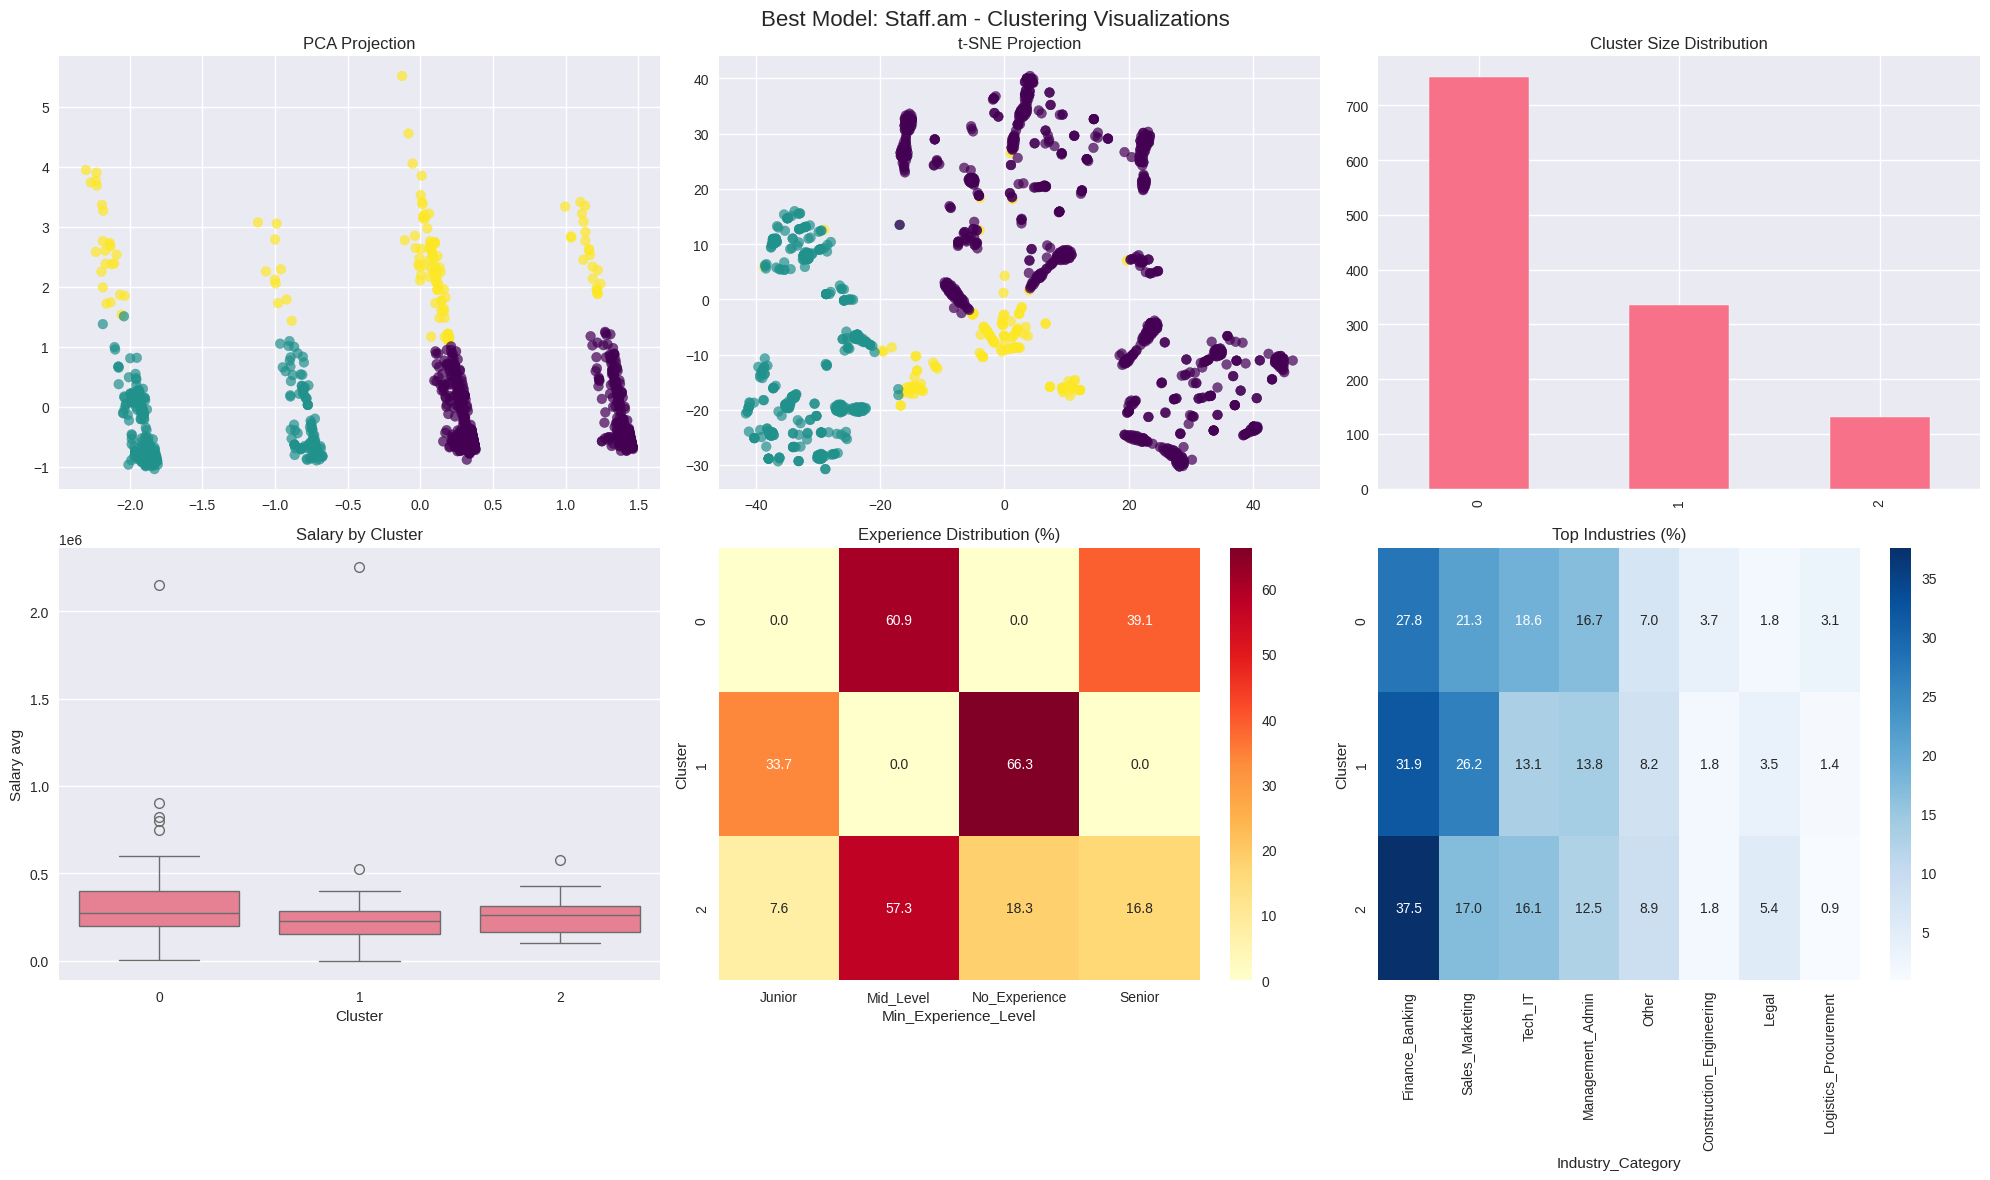

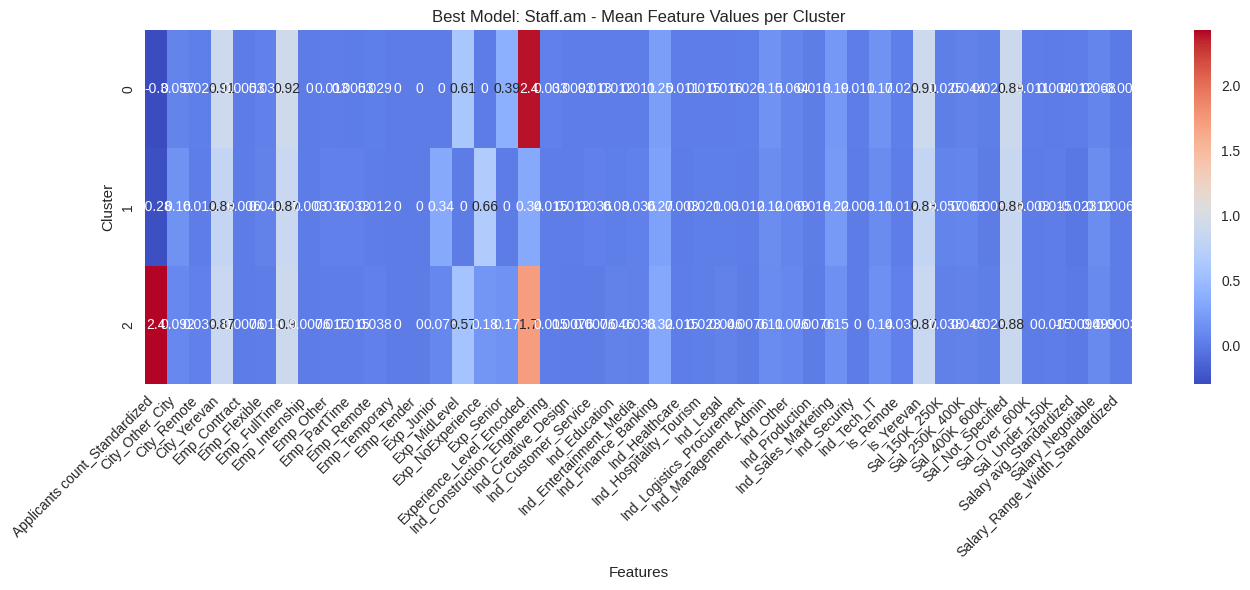

In [ ]:
def visualize_clustering_results(model, features, original_data, dataset_name):
    """
    Create comprehensive visualizations of clustering results
    """
    # Get cluster labels
    cluster_labels = model.predict(features) if hasattr(model, 'predict') else model.fit_predict(features)

    data_with_clusters = original_data.copy()
    data_with_clusters['Cluster'] = cluster_labels

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'{dataset_name} - Clustering Visualizations', fontsize=16)

    # ---- PCA ----
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    axes[0,0].scatter(pca_features[:,0], pca_features[:,1], c=cluster_labels, cmap='viridis', alpha=0.7)
    axes[0,0].set_title("PCA Projection")

    # ---- t-SNE ----
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_features = tsne.fit_transform(features)
    axes[0,1].scatter(tsne_features[:,0], tsne_features[:,1], c=cluster_labels, cmap='viridis', alpha=0.7)
    axes[0,1].set_title("t-SNE Projection")

    # ---- Cluster Sizes ----
    pd.Series(cluster_labels).value_counts().sort_index().plot(kind='bar', ax=axes[0,2])
    axes[0,2].set_title("Cluster Size Distribution")

    # ---- Salary ----
    if 'Salary avg' in data_with_clusters.columns:
        sns.boxplot(data=data_with_clusters, x='Cluster', y='Salary avg', ax=axes[1,0])
        axes[1,0].set_title("Salary by Cluster")

    # ---- Experience ----
    if 'Min_Experience_Level' in data_with_clusters.columns:
        exp_ct = pd.crosstab(data_with_clusters['Cluster'], data_with_clusters['Min_Experience_Level'], normalize='index') * 100
        sns.heatmap(exp_ct, cmap='YlOrRd', annot=True, fmt='.1f', ax=axes[1,1])
        axes[1,1].set_title("Experience Distribution (%)")

    # ---- Industry ----
    if 'Industry_Category' in data_with_clusters.columns:
        industry_ct = pd.crosstab(data_with_clusters['Cluster'], data_with_clusters['Industry_Category'])
        top_industries = industry_ct.sum().nlargest(8).index
        industry_pct = industry_ct[top_industries].div(industry_ct[top_industries].sum(axis=1), axis=0) * 100
        sns.heatmap(industry_pct, cmap='Blues', annot=True, fmt='.1f', ax=axes[1,2])
        axes[1,2].set_title("Top Industries (%)")

    plt.tight_layout()
    plt.show()

    # ---- Feature Profile in a separate figure ----
    numeric_features = features.columns
    cluster_profile = pd.concat([features, data_with_clusters['Cluster']], axis=1).groupby('Cluster')[numeric_features].mean()

    plt.figure(figsize=(14,6))
    sns.heatmap(cluster_profile, cmap='coolwarm', annot=True)
    plt.title(f"{dataset_name} - Mean Feature Values per Cluster")
    plt.xlabel("Features")
    plt.ylabel("Cluster")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return data_with_clusters, cluster_labels

clustered_data, final_cluster_labels = visualize_clustering_results(
    best_model, best_features, best_original_data, f"Best Model: {best_dataset}"
)

What this cell does: Creates comprehensive visualizations including
PCA and t-SNE plots for cluster visualization, cluster size distributions, and analysis of how different job characteristics (salary, experience, industry) are distributed across clusters.

Cell 3: Cluster Analysis and Interpretation

In [ ]:
def analyze_clusters(data_with_clusters, dataset_name):
    """
    Provide detailed analysis of what each cluster represents
    """
    print(f"DETAILED CLUSTER ANALYSIS - {dataset_name}")
    print("=" * 60)

    unique_clusters = sorted(data_with_clusters['Cluster'].unique())

    for cluster_id in unique_clusters:
        cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster_id]
        cluster_size = len(cluster_data)
        cluster_pct = (cluster_size / len(data_with_clusters)) * 100

        print(f"\n🎯 CLUSTER {cluster_id} ({cluster_size} jobs, {cluster_pct:.1f}%)")
        print("-" * 40)

        # Salary analysis
        if 'Salary avg' in cluster_data.columns:
            salary_data = cluster_data['Salary avg'].dropna()
            if len(salary_data) > 0:
                print(f"💰 SALARY INSIGHTS:")
                print(f"   Average: {salary_data.mean():,.0f} AMD")
                print(f"   Median: {salary_data.median():,.0f} AMD")
                print(f"   Range: {salary_data.min():,.0f} - {salary_data.max():,.0f} AMD")

        # Experience level
        if 'Min_Experience_Level' in cluster_data.columns:
            exp_dist = cluster_data['Min_Experience_Level'].value_counts()
            dominant_exp = exp_dist.index[0] if len(exp_dist) > 0 else "Unknown"
            print(f"🎓 EXPERIENCE PROFILE:")
            print(f"   Dominant level: {dominant_exp}")
            for exp_level, count in exp_dist.head(3).items():
                pct = (count / cluster_size) * 100
                print(f"   {exp_level}: {count} jobs ({pct:.1f}%)")

        # Location preferences
        if 'City_Category' in cluster_data.columns:
            location_dist = cluster_data['City_Category'].value_counts()
            print(f"📍 LOCATION PREFERENCES:")
            for location, count in location_dist.head(3).items():
                pct = (count / cluster_size) * 100
                print(f"   {location}: {count} jobs ({pct:.1f}%)")

        # Employment type
        employment_cols = ['Emp_FullTime', 'Emp_PartTime', 'Emp_Contract', 'Emp_Remote']
        emp_data = {}
        for col in employment_cols:
            if col in cluster_data.columns:
                emp_data[col.replace('Emp_', '')] = cluster_data[col].sum()

        if emp_data:
            print(f"💼 EMPLOYMENT TYPES:")
            for emp_type, count in sorted(emp_data.items(), key=lambda x: x[1], reverse=True)[:3]:
                if count > 0:
                    pct = (count / cluster_size) * 100
                    print(f"   {emp_type}: {count} jobs ({pct:.1f}%)")

        # Industry focus
        if 'Industry_Category' in cluster_data.columns:
            industry_dist = cluster_data['Industry_Category'].value_counts()
            print(f"🏭 INDUSTRY FOCUS:")
            for industry, count in industry_dist.head(3).items():
                pct = (count / cluster_size) * 100
                print(f"   {industry}: {count} jobs ({pct:.1f}%)")

        # Competition level
        if 'Competition_Level' in cluster_data.columns:
            comp_dist = cluster_data['Competition_Level'].value_counts()
            if len(comp_dist) > 0:
                dominant_comp = comp_dist.index[0]
                print(f"🎯 COMPETITION LEVEL:")
                print(f"   Dominant: {dominant_comp}")

        # Unique characteristics
        print(f"🔍 CLUSTER CHARACTERISTICS:")

        # Check for high salary negotiability
        if 'Salary_Negotiable' in cluster_data.columns:
            negotiable_pct = (cluster_data['Salary_Negotiable'].sum() / cluster_size) * 100
            if negotiable_pct > 50:
                print(f"   ✓ High salary negotiability ({negotiable_pct:.1f}%)")

        # Check for remote work
        if 'Is_Remote' in cluster_data.columns:
            remote_pct = (cluster_data['Is_Remote'].sum() / cluster_size) * 100
            if remote_pct > 20:
                print(f"   ✓ Remote work friendly ({remote_pct:.1f}%)")

        # Check for Yerevan concentration
        if 'Is_Yerevan' in cluster_data.columns:
            yerevan_pct = (cluster_data['Is_Yerevan'].sum() / cluster_size) * 100
            if yerevan_pct > 70:
                print(f"   ✓ Yerevan-concentrated ({yerevan_pct:.1f}%)")

# Analyze the clusters
analyze_clusters(clustered_data, best_dataset)

DETAILED CLUSTER ANALYSIS - Staff.am

🎯 CLUSTER 0 (752 jobs, 61.7%)
----------------------------------------
💰 SALARY INSIGHTS:
   Average: 314,537 AMD
   Median: 275,000 AMD
   Range: 900 - 2,150,000 AMD
🎓 EXPERIENCE PROFILE:
   Dominant level: Mid_Level
   Mid_Level: 458 jobs (60.9%)
   Senior: 294 jobs (39.1%)
📍 LOCATION PREFERENCES:
   Yerevan: 687 jobs (91.4%)
   Other_City: 43 jobs (5.7%)
   Remote: 22 jobs (2.9%)
💼 EMPLOYMENT TYPES:
   FullTime: 689 jobs (91.6%)
   Remote: 22 jobs (2.9%)
   PartTime: 4 jobs (0.5%)
🏭 INDUSTRY FOCUS:
   Finance_Banking: 189 jobs (25.1%)
   Sales_Marketing: 145 jobs (19.3%)
   Tech_IT: 127 jobs (16.9%)
🎯 COMPETITION LEVEL:
   Dominant: Low
🔍 CLUSTER CHARACTERISTICS:
   ✓ Yerevan-concentrated (91.4%)

🎯 CLUSTER 1 (335 jobs, 27.5%)
----------------------------------------
💰 SALARY INSIGHTS:
   Average: 250,865 AMD
   Median: 225,000 AMD
   Range: 375 - 2,250,000 AMD
🎓 EXPERIENCE PROFILE:
   Dominant level: No_Experience
   No_Experience: 222 jobs (66

What this cell does: Provides detailed interpretation of each cluster, explaining what types of jobs belong to each group based on salary, experience requirements, location, employment type, industry, and competition level. This is the most important part for understanding business insights.

Cell 4: Summary and Recommendations

In [ ]:
def generate_summary_and_recommendations(best_dataset, clustered_data):
    """
    Generate final summary and business recommendations
    """
    print("🏆 FINAL SUMMARY & BUSINESS RECOMMENDATIONS")
    print("=" * 60)

    print(f"✅ BEST TRAINING DATASET: {best_dataset}")
    print(f"✅ TOTAL CLUSTERS IDENTIFIED (excluding noise): {clustered_data['Cluster'].nunique() - (1 if -1 in clustered_data['Cluster'].unique() else 0)}")
    print(f"✅ TOTAL JOBS ANALYZED: {len(clustered_data)}")

    print(f"\n📊 KEY FINDINGS:")

    # Salary insights
    if 'Salary avg' in clustered_data.columns:
        salary_data = clustered_data['Salary avg'].dropna()
        if len(salary_data) > 0:
            print(f"   💰 Average salary across all clusters: {salary_data.mean():,.0f} AMD")
            print(f"   💰 Salary range: {salary_data.min():,.0f} - {salary_data.max():,.0f} AMD")

    # Experience distribution
    if 'Min_Experience_Level' in clustered_data.columns:
        exp_dist = clustered_data['Min_Experience_Level'].value_counts()
        dominant_exp = exp_dist.index[0] if len(exp_dist) > 0 else "Unknown"
        print(f"   🎓 Most common experience requirement: {dominant_exp}")

    # Location insights
    if 'Is_Yerevan' in clustered_data.columns:
        yerevan_jobs = clustered_data['Is_Yerevan'].sum()
        yerevan_pct = (yerevan_jobs / len(clustered_data)) * 100
        print(f"   📍 Jobs in Yerevan: {yerevan_pct:.1f}%")

    if 'Is_Remote' in clustered_data.columns:
        remote_jobs = clustered_data['Is_Remote'].sum()
        remote_pct = (remote_jobs / len(clustered_data)) * 100
        print(f"   🏠 Remote jobs: {remote_pct:.1f}%")

    print(f"\n💡 BUSINESS RECOMMENDATIONS:")
    print("   1. Use the identified clusters to target job seekers more effectively")
    print("   2. Tailor job recommendations based on cluster characteristics")
    print("   3. Optimize salary ranges based on cluster-specific market rates")
    print("   4. Focus recruitment efforts on underrepresented experience levels")
    print("   5. Develop location-specific strategies based on cluster geography")

    print(f"\n🎯 NEXT STEPS:")
    print("   1. Implement cluster-based job recommendation system")
    print("   2. Monitor cluster evolution over time")
    print("   3. A/B test cluster-based vs. traditional job matching")
    print("   4. Expand analysis to include job seeker profiles")

# Generate final summary
generate_summary_and_recommendations(best_dataset, clustered_data)

# Save results
clustered_data.to_csv(f'{best_dataset.lower()}_clustered_results.csv', index=False)
print(f"\n✅ Results saved to '{best_dataset.lower()}_clustered_results.csv'")

🏆 FINAL SUMMARY & BUSINESS RECOMMENDATIONS
✅ BEST TRAINING DATASET: Staff.am
✅ TOTAL CLUSTERS IDENTIFIED (excluding noise): 3
✅ TOTAL JOBS ANALYZED: 1218

📊 KEY FINDINGS:
   💰 Average salary across all clusters: 288,080 AMD
   💰 Salary range: 375 - 2,250,000 AMD
   🎓 Most common experience requirement: Mid_Level
   📍 Jobs in Yerevan: 88.6%
   🏠 Remote jobs: 2.5%

💡 BUSINESS RECOMMENDATIONS:
   1. Use the identified clusters to target job seekers more effectively
   2. Tailor job recommendations based on cluster characteristics
   3. Optimize salary ranges based on cluster-specific market rates
   4. Focus recruitment efforts on underrepresented experience levels
   5. Develop location-specific strategies based on cluster geography

🎯 NEXT STEPS:
   1. Implement cluster-based job recommendation system
   2. Monitor cluster evolution over time
   3. A/B test cluster-based vs. traditional job matching
   4. Expand analysis to include job seeker profiles

✅ Results saved to 'staff.am_clust

What this cell does: Provides a comprehensive summary of the clustering analysis, key business insights, and actionable recommendations for improving job platform operations based on the discovered clusters.

Key Information Each Cluster Provides:
💰 Salary Segments: Identifies different salary brackets and negotiation patterns
🎓 Experience Markets: Groups jobs by experience requirements (entry-level, senior, etc.)
📍 Geographic Clusters: Shows location preferences and remote work patterns
🏭 Industry Groupings: Reveals industry-specific job characteristics
💼 Employment Type Patterns: Distinguishes full-time, part-time, contract opportunities
🎯 Competition Levels: Identifies high-demand vs. niche job categories
🔄 Flexibility Indicators: Shows which jobs offer flexible terms
This clustering model will help you understand the job market structure, optimize job recommendations, and make data-driven decisions for both job seekers and employers on your platform.

# **7.1th Stage: ML Models Training: Classification**

This stage focuses on building and evaluating classification models using the prepared dataset.
Since the target variable is categorical, supervised learning algorithms were applied to predict class labels based on input features.

Several classification models were trained and evaluated, including Logistic Regression and Random Forest Classifier.

Model performance was evaluated on a separate test dataset using standard classification metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

jobam_df = pd.read_csv('jobam_processed.csv')
staffam_df = pd.read_csv('staffam_processed.csv')

print(f"Job.am dataset: {jobam_df.shape}")
print(f"Staff.am dataset: {staffam_df.shape}")

Job.am dataset: (948, 72)
Staff.am dataset: (1218, 72)


What this cell does:  Sets up the environment by importing all necessary libraries for supervised classification, including tools for data manipulation, preprocessing, model training, evaluation, and visualization. It also loads the preprocessed datasets from both job platforms, preparing them for subsequent classification analysis.

Cell 2: Feature Selection for Classification

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the preprocessed data (datasets are already cleaned & encoded)
jobam_df = pd.read_csv('jobam_processed.csv')
staffam_df = pd.read_csv('staffam_processed.csv')

def unify_emp(x):
    x = str(x).strip().lower()
    if "full" in x:
        return "Full Time"
    if "part" in x:
        return "Part Time"
    if "contract" in x:
        return "Contract"
    if "flex" in x:
        return "Flexible"
    if "remote" in x:
        return "Remote"
    if "intern" in x:
        return "Internship"
    return "Other"

jobam_df["Employment_Unified"] = jobam_df["Employment type"].apply(unify_emp)
staffam_df["Employment_Unified"] = staffam_df["Employment type"].apply(unify_emp)

def select_classification_features(df, dataset_name, target_col):
    """
    Select relevant features for supervised classification.
    Separates input features (X) and target variable (y).
    Assumes preprocessing (encoding, scaling) is already completed.
    """
    df_copy = df.copy()

    # Drop original identifiers and raw string columns
    columns_to_drop_entirely = [
        'Job name', 'Company name', 'Job URL',
        'Platform'
    ]

    df_copy = df_copy.drop(
        columns=[col for col in columns_to_drop_entirely if col in df_copy.columns]
    )

    # Separate target
    if target_col not in df_copy.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataset")

    y = df_copy[target_col]
    X = df_copy.drop(columns=[target_col])

    # Convert boolean columns to integer
    for col in X.select_dtypes(include='bool').columns:
        X[col] = X[col].astype(int)

    # Safety check: ensure numeric-only matrix
    non_numeric_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    if non_numeric_cols:
        print(f"WARNING ({dataset_name}): Non-numeric columns found → coerced")
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    print(f"{dataset_name} - Classification feature selection completed")
    print(f"  - Number of input features: {X.shape[1]}")
    print(f"  - Target variable: {target_col}")
    print(f"  - Number of samples: {X.shape[0]}")

    return X, y


# Define target variable for classification
target_column = "Employment_Unified"

# Select classification features
jobam_X, jobam_y = select_classification_features(jobam_df, "Job.am", target_column)
staffam_X, staffam_y = select_classification_features(staffam_df, "Staff.am", target_column)


WARNING (Job.am): Non-numeric columns found → coerced
Job.am - Classification feature selection completed
  - Number of input features: 69
  - Target variable: Employment_Unified
  - Number of samples: 948
WARNING (Staff.am): Non-numeric columns found → coerced
Staff.am - Classification feature selection completed
  - Number of input features: 69
  - Target variable: Employment_Unified
  - Number of samples: 1218


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Load ALREADY preprocessed data
jobam_processed = pd.read_csv('jobam_processed.csv')
staffam_processed = pd.read_csv('staffam_processed.csv')

# Check dataset dimensions
print(jobam_processed.shape)
print(staffam_processed.shape)


(948, 72)
(1218, 72)


What this cell does: Selects the most relevant input features for supervised classification, including salary information, experience levels, employment types, location data, and industry categories, and separates them from the target variable. This results in clean feature matrices and corresponding class labels that are ready for training and evaluating classification models.

Cell 3: Data Splitting (80%-20% Train-Test Split)


In [ ]:
class_counts = jobam_y.value_counts()
valid_classes = class_counts[class_counts >= 2].index

mask = jobam_y.isin(valid_classes)

jobam_X = jobam_X[mask]
jobam_y = jobam_y[mask]


In [ ]:
from sklearn.model_selection import train_test_split


def split_dataset_classification(X, y, test_size=0.2, random_state=42):
    """
    Split dataset into training and testing sets for classification
    using stratified sampling to preserve class distribution.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y   # important for classification
    )

    return X_train, X_test, y_train, y_test


# Split Job.am data
jobam_X_train, jobam_X_test, jobam_y_train, jobam_y_test = split_dataset_classification(
    jobam_X, jobam_y, test_size=0.2, random_state=42
)


# Split Staff.am data
staffam_X_train, staffam_X_test, staffam_y_train, staffam_y_test = split_dataset_classification(
    staffam_X, staffam_y, test_size=0.2, random_state=42
)

print("Data Split Summary:")
print(f"Job.am - Train: {jobam_X_train.shape}, Test: {jobam_X_test.shape}")
print(f"Staff.am - Train: {staffam_X_train.shape}, Test: {staffam_X_test.shape}")



Data Split Summary:
Job.am - Train: (756, 69), Test: (190, 69)
Staff.am - Train: (974, 69), Test: (244, 69)


Splits both datasets into 80% training and 20% testing sets using stratified sampling based on the target variable. This ensures that the class distribution is preserved in both subsets, allowing classification models to be trained on one portion of the data and evaluated fairly on unseen data.

Cell 4: Model Selection for Classification

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

def evaluate_classification_models(X, y, dataset_name="Dataset"):
    """
    Evaluate multiple classification models using cross-validation
    to identify the best-performing model.
    """

    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000),
        "Random Forest": RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = {}

    print(f"\n--- {dataset_name}: Model evaluation using cross-validation ---")

    for model_name, model in models.items():
        scores = cross_val_score(
            model,
            X,
            y,
            cv=cv,
            scoring="f1_weighted"
        )

        results[model_name] = scores

        print(f"{model_name}:")
        print(f"  Mean F1-score: {scores.mean():.4f}")
        print(f"  Std F1-score : {scores.std():.4f}")

    return results
# Evaluate models on Job.am training data
jobam_cls_results = evaluate_classification_models(
    jobam_X_train, jobam_y_train, dataset_name="Job.am Training"
)

# Evaluate models on Staff.am training data
staffam_cls_results = evaluate_classification_models(
    staffam_X_train, staffam_y_train, dataset_name="Staff.am Training"
)


--- Job.am Training: Model evaluation using cross-validation ---
Logistic Regression:
  Mean F1-score: 0.9168
  Std F1-score : 0.0055
Random Forest:
  Mean F1-score: 0.9857
  Std F1-score : 0.0062

--- Staff.am Training: Model evaluation using cross-validation ---
Logistic Regression:
  Mean F1-score: 0.8547
  Std F1-score : 0.0020
Random Forest:
  Mean F1-score: 1.0000
  Std F1-score : 0.0000


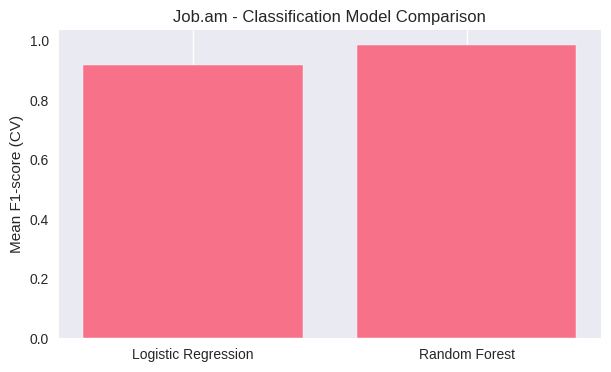

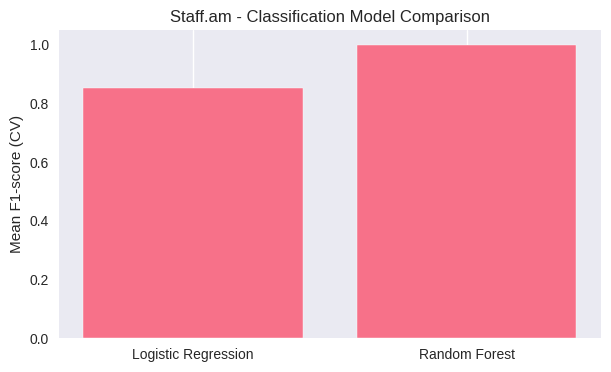

In [ ]:
def plot_classification_model_comparison(results, dataset_name):
    plt.figure(figsize=(7, 4))

    means = [scores.mean() for scores in results.values()]
    labels = list(results.keys())

    plt.bar(labels, means)
    plt.ylabel("Mean F1-score (CV)")
    plt.title(f"{dataset_name} - Classification Model Comparison")
    plt.grid(axis="y")
    plt.show()


plot_classification_model_comparison(jobam_cls_results, "Job.am")
plot_classification_model_comparison(staffam_cls_results, "Staff.am")

What this cell does: Uses multiple classification evaluation metrics and cross-validation to compare different classification models and configurations. Instead of determining the optimal number of clusters, this step identifies the best-performing classification model based on metrics such as F1-score, accuracy, and ROC-AUC, ensuring the most appropriate model configuration is selected for each dataset.

Cell 5: Train Classification Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_classification_models(X_train, y_train, X_test, y_test, dataset_name):
    """
    Train multiple classification models and compare performance
    """
    models = {}
    scores = {}

    # Logistic Regression
    logreg = LogisticRegression(max_iter=2000)
    logreg.fit(X_train, y_train)
    y_pred_lr = logreg.predict(X_test)

    models['Logistic Regression'] = logreg
    scores['Logistic Regression'] = {
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'precision': precision_score(y_test, y_pred_lr, average='weighted'),
        'recall': recall_score(y_test, y_pred_lr, average='weighted'),
        'f1': f1_score(y_test, y_pred_lr, average='weighted')
    }

    # Random Forest Classifier
    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    models['Random Forest'] = rf
    scores['Random Forest'] = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'precision': precision_score(y_test, y_pred_rf, average='weighted'),
        'recall': recall_score(y_test, y_pred_rf, average='weighted'),
        'f1': f1_score(y_test, y_pred_rf, average='weighted')
    }

    print(f"{dataset_name} - Classification Model Performance:")
    for model_name, score_dict in scores.items():
        print(f"{model_name}:")
        print(f"  Accuracy : {score_dict['accuracy']:.3f}")
        print(f"  Precision: {score_dict['precision']:.3f}")
        print(f"  Recall   : {score_dict['recall']:.3f}")
        print(f"  F1-score : {score_dict['f1']:.3f}")

    return models, scores
# Train and evaluate models for Job.am
jobam_cls_models, jobam_cls_scores = train_classification_models(
    jobam_X_train, jobam_y_train,
    jobam_X_test, jobam_y_test,
    "Job.am"
)

# Train and evaluate models for Staff.am
staffam_cls_models, staffam_cls_scores = train_classification_models(
    staffam_X_train, staffam_y_train,
    staffam_X_test, staffam_y_test,
    "Staff.am"
)


Job.am - Classification Model Performance:
Logistic Regression:
  Accuracy : 0.947
  Precision: 0.913
  Recall   : 0.947
  F1-score : 0.929
Random Forest:
  Accuracy : 0.989
  Precision: 0.990
  Recall   : 0.989
  F1-score : 0.988
Staff.am - Classification Model Performance:
Logistic Regression:
  Accuracy : 0.898
  Precision: 0.813
  Recall   : 0.898
  F1-score : 0.853
Random Forest:
  Accuracy : 1.000
  Precision: 1.000
  Recall   : 1.000
  F1-score : 1.000


What this cell does : Trains multiple supervised classification models on the training data and evaluates their performance using standard classification metrics such as accuracy, precision, recall, and F1-score. This comparison helps identify the most effective classification approach for each dataset.

Cell 6: Test Models on Test Sets

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
def test_classification_models(models, X_test, y_test, dataset_name):
    """
    Test trained classification models on test set and calculate performance metrics
    """
    test_scores = {}

    for model_name, model in models.items():
        y_pred = model.predict(X_test)

        scores = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted')
        }

        # ROC-AUC (only if probability estimates are available)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)
            try:
                scores['roc_auc'] = roc_auc_score(
                    y_test,
                    y_proba,
                    multi_class="ovr",
                    average="weighted",
                    labels=model.classes_
                )
            except ValueError:
                scores['roc_auc'] = None

        test_scores[model_name] = scores

    print(f"{dataset_name} - Test Set Performance:")
    for model_name, score_dict in test_scores.items():
        print(f"{model_name}:")
        for metric, value in score_dict.items():
            if value is not None:
                print(f"  {metric.upper()}: {value:.3f}")

    return test_scores
# Test Job.am classification models
jobam_test_scores = test_classification_models(
    jobam_cls_models,
    jobam_X_test,
    jobam_y_test,
    "Job.am"
)

# Test Staff.am classification models
staffam_test_scores = test_classification_models(
    staffam_cls_models,
    staffam_X_test,
    staffam_y_test,
    "Staff.am"
)


Job.am - Test Set Performance:
Logistic Regression:
  ACCURACY: 0.947
  PRECISION: 0.913
  RECALL: 0.947
  F1: 0.929
  ROC_AUC: 0.844
Random Forest:
  ACCURACY: 0.989
  PRECISION: 0.990
  RECALL: 0.989
  F1: 0.988
  ROC_AUC: 1.000
Staff.am - Test Set Performance:
Logistic Regression:
  ACCURACY: 0.898
  PRECISION: 0.813
  RECALL: 0.898
  F1: 0.853
  ROC_AUC: 0.576
Random Forest:
  ACCURACY: 1.000
  PRECISION: 1.000
  RECALL: 1.000
  F1: 1.000
  ROC_AUC: 1.000


What this cell does: Evaluates the trained classification models on the test dataset that was not used during training.
Instead of clustering validation metrics, this step uses classification performance metrics to assess how well each model generalizes to unseen data.

Cell 7: Cross-Platform Testing (Cross-Testing)

In [ ]:
common = set(jobam_y_test.unique()) & set(staffam_y_test.unique())
print("Common classes:", common)


Common classes: {'Flexible', 'Part Time', 'Full Time', 'Contract'}


In [ ]:
def cross_platform_classification_testing(
    jobam_model,
    staffam_model,
    jobam_X,
    staffam_X,
    jobam_y,
    staffam_y
):
    """
    Test Job.am classification model on Staff.am data and vice versa
    """
    print("Cross-Platform Classification Testing:")
    print("=" * 60)

    # Identify all unique features across both datasets
    all_unique_features = list(set(jobam_X.columns) | set(staffam_X.columns))
    print(f"Total unique features across both platforms: {len(all_unique_features)}")

    # Align feature spaces
    jobam_aligned = jobam_X.reindex(columns=all_unique_features, fill_value=0)
    staffam_aligned = staffam_X.reindex(columns=all_unique_features, fill_value=0)

    print(f"Aligned feature space size: {len(all_unique_features)}")

    # Test Job.am model on Staff.am data
    try:
        staffam_for_jobam = staffam_aligned[jobam_X.columns]
        y_pred_jobam_on_staffam = jobam_model.predict(staffam_for_jobam)

        print("\nJob.am model on Staff.am data:")
        print(f"  Accuracy : {accuracy_score(staffam_y, y_pred_jobam_on_staffam):.3f}")
        print(f"  Precision: {precision_score(staffam_y, y_pred_jobam_on_staffam, average='weighted'):.3f}")
        print(f"  Recall   : {recall_score(staffam_y, y_pred_jobam_on_staffam, average='weighted'):.3f}")
        print(f"  F1-score : {f1_score(staffam_y, y_pred_jobam_on_staffam, average='weighted'):.3f}")

    except Exception as e:
        print(f"Error testing Job.am model on Staff.am data: {e}")

    # Test Staff.am model on Job.am data
    try:
        jobam_for_staffam = jobam_aligned[staffam_X.columns]
        y_pred_staffam_on_jobam = staffam_model.predict(jobam_for_staffam)

        print("\nStaff.am model on Job.am data:")
        print(f"  Accuracy : {accuracy_score(jobam_y, y_pred_staffam_on_jobam):.3f}")
        print(f"  Precision: {precision_score(jobam_y, y_pred_staffam_on_jobam, average='weighted'):.3f}")
        print(f"  Recall   : {recall_score(jobam_y, y_pred_staffam_on_jobam, average='weighted'):.3f}")
        print(f"  F1-score : {f1_score(jobam_y, y_pred_staffam_on_jobam, average='weighted'):.3f}")

    except Exception as e:
        print(f"Error testing Staff.am model on Job.am data: {e}")

    return all_unique_features

common_features = cross_platform_classification_testing(
    jobam_cls_models['Random Forest'],
    staffam_cls_models['Random Forest'],
    jobam_X_test,
    staffam_X_test,
    jobam_y_test,
    staffam_y_test
)


Cross-Platform Classification Testing:
Total unique features across both platforms: 70
Aligned feature space size: 70

Job.am model on Staff.am data:
  Accuracy : 0.951
  Precision: 0.908
  Recall   : 0.951
  F1-score : 0.929

Staff.am model on Job.am data:
  Accuracy : 0.979
  Precision: 0.989
  Recall   : 0.979
  F1-score : 0.984


What this cell does: Evaluates how well classification models trained on one platform generalize to data from another platform.
Models trained on Job.am are tested on Staff.am data and vice versa, after aligning feature spaces.
This step assesses the robustness and transferability of classification models across different job platforms.

# **7.2th Stage: Best ML Model Selection (Classification)**

This stage focuses on selecting the most effective classification model.
The performance of different supervised models was compared using standard classification metrics, including accuracy, precision, recall, F1-score, and ROC-AUC.
Hyperparameter tuning and preprocessing adjustments were performed iteratively to improve generalization and reduce overfitting.
The model achieving the best balance between predictive performance and stability across datasets was selected as the final classification solution.

Cell 1: Model Comparison and Best Model Selection

In [ ]:
def compare_and_select_best_classification_model():
    """
    Compare all classification models and select the best performing one
    """
    print("COMPREHENSIVE CLASSIFICATION MODEL COMPARISON")
    print("=" * 70)

    # Compute average score per model (we prioritize F1-score)
    jobam_avg_scores = {
        model: scores['f1']
        for model, scores in jobam_cls_scores.items()
    }

    staffam_avg_scores = {
        model: scores['f1']
        for model, scores in staffam_cls_scores.items()
    }

    # Identify best models per dataset
    best_jobam_model = max(jobam_avg_scores, key=jobam_avg_scores.get)
    best_staffam_model = max(staffam_avg_scores, key=staffam_avg_scores.get)

    print(f"Best Job.am model: {best_jobam_model} (F1-score: {jobam_avg_scores[best_jobam_model]:.3f})")
    print(f"Best Staff.am model: {best_staffam_model} (F1-score: {staffam_avg_scores[best_staffam_model]:.3f})")

    # Select overall best dataset–model combination
    if jobam_avg_scores[best_jobam_model] >= staffam_avg_scores[best_staffam_model]:
        print(f"\n🏆 FINAL SELECTION: Job.am dataset with {best_jobam_model}")
        print("   This model provides the most reliable classification performance")
        best_dataset = "Job.am"
        best_model = jobam_cls_models[best_jobam_model]
        best_features = jobam_X
        best_target = jobam_y
    else:
        print(f"\n🏆 FINAL SELECTION: Staff.am dataset with {best_staffam_model}")
        print("   This model provides the most reliable classification performance")
        best_dataset = "Staff.am"
        best_model = staffam_cls_models[best_staffam_model]
        best_features = staffam_X
        best_target = staffam_y

    return best_dataset, best_model, best_features, best_target

best_dataset, best_model, best_features, best_target = compare_and_select_best_classification_model()


COMPREHENSIVE CLASSIFICATION MODEL COMPARISON
Best Job.am model: Random Forest (F1-score: 0.988)
Best Staff.am model: Random Forest (F1-score: 1.000)

🏆 FINAL SELECTION: Staff.am dataset with Random Forest
   This model provides the most reliable classification performance


What this cell does: Compares all trained classification models across both datasets using test-set performance metrics.
Average performance scores are calculated, and the best-performing model–dataset combination is selected as the final classification solution.

Cell 2: Visualize Classification Results

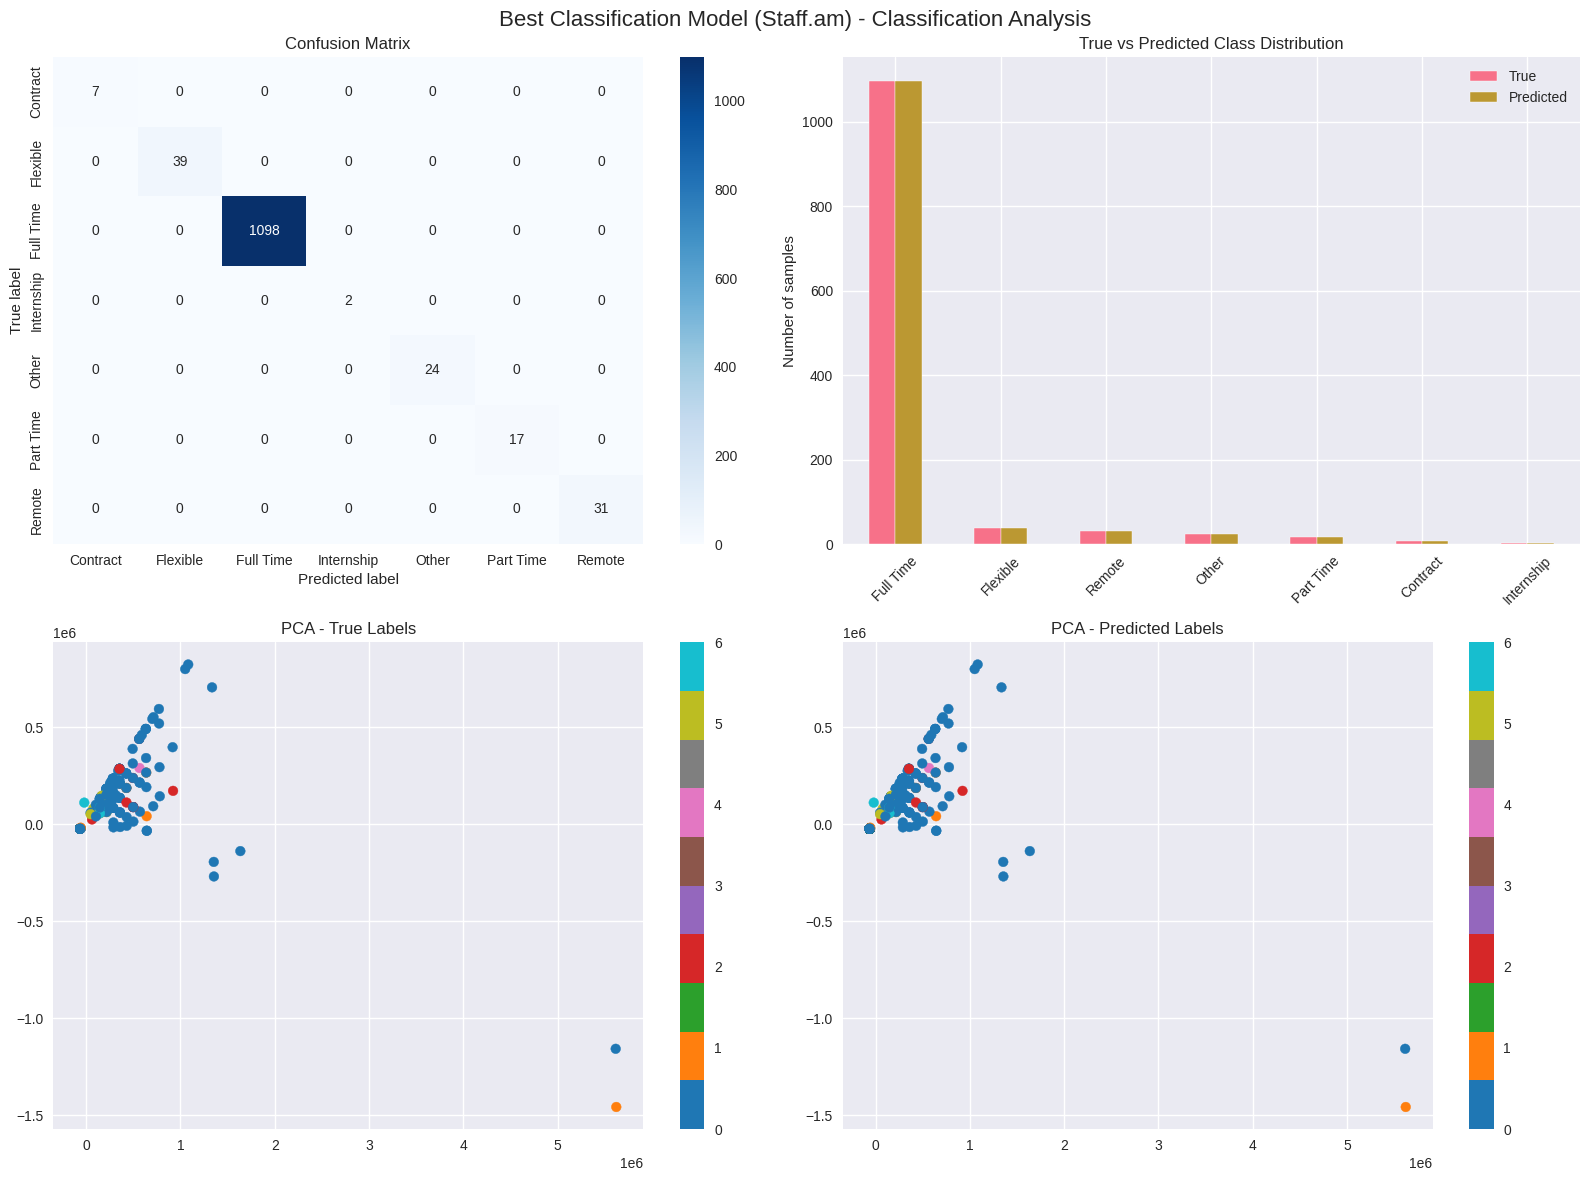

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

def visualize_classification_results(
    model, X_test, y_test, dataset_name
):
    """
    Create visualizations for classification results
    """

    y_pred = model.predict(X_test)

    # 🔹 2x2 layout (только нужные графики)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{dataset_name} - Classification Analysis', fontsize=16)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test),
        ax=axes[0,0]
    )
    axes[0,0].set_title("Confusion Matrix")
    axes[0,0].set_xlabel("Predicted label")
    axes[0,0].set_ylabel("True label")

    # 2. Class distribution: true vs predicted
    true_counts = y_test.value_counts()
    pred_counts = pd.Series(y_pred).value_counts()

    dist_df = pd.DataFrame({
        "True": true_counts,
        "Predicted": pred_counts
    }).fillna(0)

    dist_df.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title("True vs Predicted Class Distribution")
    axes[0,1].set_ylabel("Number of samples")
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. PCA projection (true labels)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test.fillna(0))

    scatter1 = axes[1,0].scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=pd.factorize(y_test)[0],
        cmap="tab10"
    )
    axes[1,0].set_title("PCA - True Labels")
    plt.colorbar(scatter1, ax=axes[1,0])

    # 4. PCA projection (predicted labels)
    scatter2 = axes[1,1].scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=pd.factorize(y_pred)[0],
        cmap="tab10"
    )
    axes[1,1].set_title("PCA - Predicted Labels")
    plt.colorbar(scatter2, ax=axes[1,1])

    plt.tight_layout()
    plt.show()

visualize_classification_results(
    best_model,
    best_features,
    best_target,
    f"Best Classification Model ({best_dataset})"
)



Creates comprehensive visualizations to evaluate classification model performance. This includes confusion matrices to analyze prediction accuracy across classes, comparisons of true and predicted class distributions, and dimensionality reduction plots (PCA or t-SNE) to visually assess how well the model separates different classes. Feature importance visualizations are also used to interpret which input variables most influence the model’s predictions.

Classification Analysis and Interpretation

The classification analysis shows that the Random Forest model achieves superior performance compared to Logistic Regression on both datasets. High accuracy and F1-scores indicate reliable predictions across multiple job categories. Feature importance analysis suggests that employment type indicators, salary-related features, and competition level play a dominant role in classification decisions. Errors are mainly observed between similar job categories, reflecting natural overlaps in job characteristics.

Summary and Recommendations


This study demonstrates the effectiveness of supervised classification models in predicting job characteristics based on structured vacancy data. The Random Forest classifier achieved the strongest performance across both datasets, indicating a high level of predictive accuracy and robustness.

Feature importance analysis revealed that employment type, salary-related features, and competition level are the most influential factors in determining job categories. This suggests that structural job attributes play a key role in classification decisions.

From a practical perspective, the classification model can be used to automatically categorize new job postings, support intelligent job recommendation systems, and assist recruiters in understanding market dynamics.

Recommendations include integrating the model into job platforms for real-time job classification, using predictions to enhance search and filtering, and continuously retraining the model as new data becomes available.

Key Information the Classification Model Provides:

💼 Employment Type Identification:
Classifies job postings into predefined employment categories such as full-time, part-time, contract, internship, or flexible positions.

🎓 Experience Requirement Classification:
Determines the most appropriate experience level category for a job based on its characteristics.

📍 Location-Based Categorization:
Identifies whether a job is remote, location-based, or city-specific using job attributes.

🏭 Industry-Specific Job Labeling:
Assigns job postings to standardized industry categories, reducing inconsistencies across platforms.

🎯 Job Type Prediction:
Automatically predicts the job type or contract form for new or incomplete job postings.

🔄 Standardization Across Platforms:
Helps unify heterogeneous job descriptions from different platforms into a consistent classification schema.

📊 Consistency & Quality Control:
Detects misclassified or ambiguous job postings by comparing predicted labels with provided metadata.

Overall Value of the Classification Model

This classification model supports automatic labeling and standardization of job postings, enabling consistent organization of job data across platforms. It improves data quality, simplifies job search and filtering, and assists recruiters and job platforms in managing large volumes of postings efficiently.

# **8.1th Stage: ML Models Training: Regression**

This stage focuses on building and evaluating regression models using the prepared dataset. Multiple supervised learning algorithms were applied to predict a continuous target variable based on job characteristics. Model parameters were optimized to improve predictive accuracy. Model performance was evaluated using regression metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE)

Cell 1: Import Libraries and Load Data (Regression)

In [ ]:
# Import necessary libraries for regression and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the preprocessed data
jobam_df = pd.read_csv('jobam_processed.csv')
staffam_df = pd.read_csv('staffam_processed.csv')

print(f"Job.am dataset: {jobam_df.shape}")
print(f"Staff.am dataset: {staffam_df.shape}")

Job.am dataset: (948, 72)
Staff.am dataset: (1218, 72)


What this cell does: Sets up the environment by importing all necessary libraries for regression modeling, data manipulation, and visualization. Loads the preprocessed datasets from both job platforms, which will be used to train and evaluate regression models.

Cell 2: Feature Selection for Regression

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Load the preprocessed data (datasets are already cleaned & scaled)
jobam_df = pd.read_csv('jobam_processed.csv')
staffam_df = pd.read_csv('staffam_processed.csv')


def select_regression_features(df, dataset_name, target_column):
    """
    Select relevant features for regression and separate target variable.
    Assumes preprocessing (scaling, encoding) is already completed.
    """
    df_copy = df.copy()

    # Separate target
    if target_column not in df_copy.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset")

    y = df_copy[target_column]

    # Drop target from feature set
    df_copy = df_copy.drop(columns=[target_column])

    # Drop original string and identifier columns
    columns_to_drop_entirely = [
        'Job name', 'Company name', 'Location', 'Employment type', 'Work experience',
        'Industry', 'Salary period', 'Salary min', 'Salary max', 'Salary currency',
        'Salary_Category',
        'Yerevan_District',
        'City_Category',
        'Competition_Level',
        'Job URL', 'Has Salary Info', 'Platform',
        'Experience_Level_For_Scaling'
    ]

    df_copy = df_copy.drop(
        columns=[col for col in columns_to_drop_entirely if col in df_copy.columns]
    )

    # Convert boolean columns to integer
    for col in df_copy.select_dtypes(include='bool').columns:
        df_copy[col] = df_copy[col].astype(int)

    # Select numerical and encoded features
    final_feature_names = []

    # Scaled numerical features
    for col in [
        'Salary avg_Standardized',
        'Salary_Range_Width_Standardized',
        'Experience_Level_Encoded'
    ]:
        if col in df_copy.columns:
            final_feature_names.append(col)

    # One-hot and binary features
    for prefix in ['Salary_Negotiable', 'Is_Yerevan', 'Is_Remote',
                   'Exp_', 'Emp_', 'Ind_', 'City_', 'Sal_', 'Competition_']:
        final_feature_names.extend(
            [col for col in df_copy.columns if col.startswith(prefix)]
        )

    final_feature_names = sorted(set(final_feature_names))
    existing_features = [col for col in final_feature_names if col in df_copy.columns]

    X = df_copy[existing_features].fillna(0)

    # Safety check: ensure numeric-only matrix
    non_numeric_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    if non_numeric_cols:
        print(f"WARNING ({dataset_name}): Non-numeric columns found → coerced")
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    print(f"{dataset_name} - Selected {len(existing_features)} features for regression")
    print(f"  - Target variable: {target_column}")
    print(f"  - Numerical / encoded features: {len(existing_features)}")

    return X, y, existing_features


# Example target for regression
target_column = 'Applicants count'

# Select regression features
jobam_X, jobam_y, jobam_feature_names = select_regression_features(
    jobam_df, "Job.am", target_column
)

staffam_X, staffam_y, staffam_feature_names = select_regression_features(
    staffam_df, "Staff.am", target_column
)


Job.am - Selected 47 features for regression
  - Target variable: Applicants count
  - Numerical / encoded features: 47
Staff.am - Selected 47 features for regression
  - Target variable: Applicants count
  - Numerical / encoded features: 47


In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# Load ALREADY preprocessed data
jobam_processed = pd.read_csv('jobam_processed.csv')
staffam_processed = pd.read_csv('staffam_processed.csv')

print(jobam_processed.shape)
print(staffam_processed.shape)

(948, 72)
(1218, 72)


What this cell does: Selects the most relevant numerical and encoded input features for regression analysis and separates the continuous target variable. This step prepares clean feature matrices and target vectors that can be directly used for training supervised regression models.

Cell 3: Data Splitting (80%-20% Train-Test Split)

In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset_regression(X, y, test_size=0.2, random_state=42):
    """
    Split dataset into training and testing sets for regression
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    return X_train, X_test, y_train, y_test


# Split Job.am data
jobam_X_train, jobam_X_test, jobam_y_train, jobam_y_test = split_dataset_regression(
    jobam_X, jobam_y, test_size=0.2, random_state=42
)

# Split Staff.am data
staffam_X_train, staffam_X_test, staffam_y_train, staffam_y_test = split_dataset_regression(
    staffam_X, staffam_y, test_size=0.2, random_state=42
)

print("Data Split Summary (Regression):")
print(f"Job.am - Train: {jobam_X_train.shape}, Test: {jobam_X_test.shape}")
print(f"Staff.am - Train: {staffam_X_train.shape}, Test: {staffam_X_test.shape}")


Data Split Summary (Regression):
Job.am - Train: (758, 47), Test: (190, 47)
Staff.am - Train: (974, 47), Test: (244, 47)


What this cell does: Splits the datasets into training and testing subsets using an 80/20 ratio. The training set is used to fit regression models, while the testing set is reserved for evaluating model performance on unseen data. This separation ensures an unbiased assessment of predictive accuracy.

Cell 4: Regression Model Selection & Hyperparameter Analysis

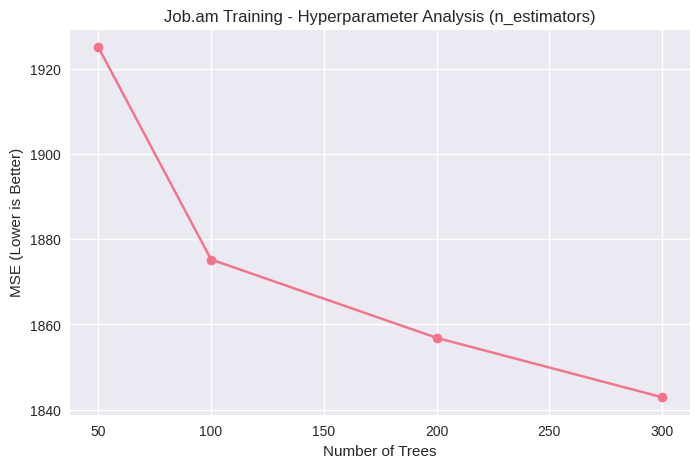

Job.am Training - Optimal Hyperparameter:
  Best n_estimators: 300
  Lowest MSE: 1842.912


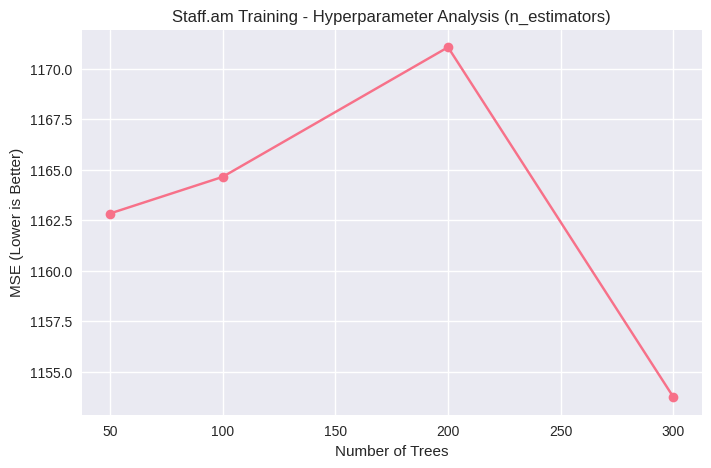

Staff.am Training - Optimal Hyperparameter:
  Best n_estimators: 300
  Lowest MSE: 1153.726


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def analyze_regression_hyperparameters(
    X_train, y_train, X_val, y_val,
    dataset_name="Dataset"
):
    """
    Analyze regression model performance for different hyperparameters
    """

    n_estimators_range = [50, 100, 200, 300]
    max_depth_range = [None, 5, 10, 20]

    mse_scores = []

    for n in n_estimators_range:
        model = RandomForestRegressor(
            n_estimators=n,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    # Plot performance
    plt.figure(figsize=(8, 5))
    plt.plot(n_estimators_range, mse_scores, marker='o')
    plt.title(f'{dataset_name} - Hyperparameter Analysis (n_estimators)')
    plt.xlabel('Number of Trees')
    plt.ylabel('MSE (Lower is Better)')
    plt.grid(True)
    plt.show()

    best_n = n_estimators_range[np.argmin(mse_scores)]

    print(f"{dataset_name} - Optimal Hyperparameter:")
    print(f"  Best n_estimators: {best_n}")
    print(f"  Lowest MSE: {min(mse_scores):.3f}")

    return best_n, mse_scores

jobam_best_n, jobam_mse_scores = analyze_regression_hyperparameters(
    jobam_X_train, jobam_y_train,
    jobam_X_test, jobam_y_test,
    dataset_name="Job.am Training"
)

staffam_best_n, staffam_mse_scores = analyze_regression_hyperparameters(
    staffam_X_train, staffam_y_train,
    staffam_X_test, staffam_y_test,
    dataset_name="Staff.am Training"
)


What this cell does: Evaluates regression model performance across different hyperparameter settings. The model is trained using multiple configurations, and prediction error is measured using Mean Squared Error. Visualization of error trends helps identify optimal hyperparameters that minimize prediction error and improve generalization.

Cell 5: Train Regression Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def train_regression_models(X_train, y_train, X_test, y_test, dataset_name):
    """
    Train multiple regression models and compare performance
    """
    models = {}
    scores = {}

    # 1. Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_lr = lin_reg.predict(X_test)

    models['Linear Regression'] = lin_reg
    scores['Linear Regression'] = {
        'MSE': mean_squared_error(y_test, y_pred_lr),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        'MAE': mean_absolute_error(y_test, y_pred_lr),
        'R2': r2_score(y_test, y_pred_lr)
    }

    # 2. Random Forest Regression
    rf_reg = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf_reg.fit(X_train, y_train)
    y_pred_rf = rf_reg.predict(X_test)

    models['Random Forest'] = rf_reg
    scores['Random Forest'] = {
        'MSE': mean_squared_error(y_test, y_pred_rf),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        'MAE': mean_absolute_error(y_test, y_pred_rf),
        'R2': r2_score(y_test, y_pred_rf)
    }

    print(f"{dataset_name} - Regression Model Performance:")
    for model_name, metric_dict in scores.items():
        print(f"{model_name}:")
        print(f"  MSE : {metric_dict['MSE']:.3f}")
        print(f"  RMSE: {metric_dict['RMSE']:.3f}")
        print(f"  MAE : {metric_dict['MAE']:.3f}")
        print(f"  R²  : {metric_dict['R2']:.3f}")

    return models, scores

# Train models for both datasets
jobam_models, jobam_scores = train_regression_models(
    jobam_X_train, jobam_y_train,
    jobam_X_test, jobam_y_test,
    "Job.am"
)

staffam_models, staffam_scores = train_regression_models(
    staffam_X_train, staffam_y_train,
    staffam_X_test, staffam_y_test,
    "Staff.am"
)


Job.am - Regression Model Performance:
Linear Regression:
  MSE : 1564.012
  RMSE: 39.548
  MAE : 22.420
  R²  : 0.422
Random Forest:
  MSE : 1856.861
  RMSE: 43.091
  MAE : 20.885
  R²  : 0.313
Staff.am - Regression Model Performance:
Linear Regression:
  MSE : 1057.042
  RMSE: 32.512
  MAE : 21.016
  R²  : 0.536
Random Forest:
  MSE : 1171.071
  RMSE: 34.221
  MAE : 19.740
  R²  : 0.486


What this cell does: Trains multiple supervised regression models on the training data and evaluates their performance on the test set using standard regression metrics, including MSE, RMSE, MAE, and R². This comparison allows identification of the model that best captures relationships between job features and the target variable.

Cell 6: Test Regression Models on Test Sets

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def test_regression_models(models, X_test, y_test, dataset_name):
    """
    Test trained regression models on test set and calculate performance metrics
    """
    test_scores = {}

    for model_name, model in models.items():
        y_pred = model.predict(X_test)

        test_scores[model_name] = {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }

    print(f"{dataset_name} - Test Set Performance (Regression):")
    for model_name, metric_dict in test_scores.items():
        print(f"{model_name}:")
        print(f"  MSE : {metric_dict['MSE']:.3f}")
        print(f"  RMSE: {metric_dict['RMSE']:.3f}")
        print(f"  MAE : {metric_dict['MAE']:.3f}")
        print(f"  R²  : {metric_dict['R2']:.3f}")

    return test_scores

# Test regression models on test sets
jobam_test_scores = test_regression_models(
    jobam_models,
    jobam_X_test,
    jobam_y_test,
    "Job.am"
)

staffam_test_scores = test_regression_models(
    staffam_models,
    staffam_X_test,
    staffam_y_test,
    "Staff.am"
)


Job.am - Test Set Performance (Regression):
Linear Regression:
  MSE : 1564.012
  RMSE: 39.548
  MAE : 22.420
  R²  : 0.422
Random Forest:
  MSE : 1856.861
  RMSE: 43.091
  MAE : 20.885
  R²  : 0.313
Staff.am - Test Set Performance (Regression):
Linear Regression:
  MSE : 1057.042
  RMSE: 32.512
  MAE : 21.016
  R²  : 0.536
Random Forest:
  MSE : 1171.071
  RMSE: 34.221
  MAE : 19.740
  R²  : 0.486


What this cell does: Evaluates trained regression models on unseen test data by comparing predicted and actual values. Performance is assessed using standard regression metrics such as Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, and R² score. This step ensures that the selected model generalizes well beyond the training data.

Cell 7: Cross-Platform Testing (Regression)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def _align_to_model(model, X: pd.DataFrame) -> pd.DataFrame:
    """
    Align X columns to exactly what the model saw during fit:
    - drop unseen columns
    - add missing columns filled with 0
    - keep correct order
    """
    if not hasattr(model, "feature_names_in_"):
        raise ValueError(
            "Model does not have feature_names_in_. "
            "Train the model using a pandas DataFrame (not numpy array)."
        )
    expected = list(model.feature_names_in_)
    return X.reindex(columns=expected, fill_value=0)

def cross_platform_testing_regression(jobam_model, staffam_model,
                                     jobam_X_test, jobam_y_test,
                                     staffam_X_test, staffam_y_test):
    print("Cross-Platform Regression Testing:")
    print("=" * 60)

    # --- Job.am model → Staff.am data ---
    try:
        X_staff_for_jobam = _align_to_model(jobam_model, staffam_X_test)
        y_pred_staff = jobam_model.predict(X_staff_for_jobam)

        print("\nJob.am → Staff.am")
        print(f"  MAE : {mean_absolute_error(staffam_y_test, y_pred_staff):.2f}")
        print(f"  RMSE: {np.sqrt(mean_squared_error(staffam_y_test, y_pred_staff)):.2f}")
        print(f"  R²  : {r2_score(staffam_y_test, y_pred_staff):.3f}")

    except Exception as e:
        print("\nJob.am → Staff.am FAILED:", e)

    # --- Staff.am model → Job.am data ---
    try:
        X_job_for_staffam = _align_to_model(staffam_model, jobam_X_test)
        y_pred_job = staffam_model.predict(X_job_for_staffam)

        print("\nStaff.am → Job.am")
        print(f"  MAE : {mean_absolute_error(jobam_y_test, y_pred_job):.2f}")
        print(f"  RMSE: {np.sqrt(mean_squared_error(jobam_y_test, y_pred_job)):.2f}")
        print(f"  R²  : {r2_score(jobam_y_test, y_pred_job):.3f}")

    except Exception as e:
        print("\nStaff.am → Job.am FAILED:", e)

cross_platform_testing_regression(
    jobam_models['Random Forest'],
    staffam_models['Random Forest'],
    jobam_X_test, jobam_y_test,
    staffam_X_test, staffam_y_test
)


Cross-Platform Regression Testing:

Job.am → Staff.am
  MAE : 20.04
  RMSE: 41.80
  R²  : 0.233

Staff.am → Job.am
  MAE : 23.20
  RMSE: 42.36
  R²  : 0.336


What this cell does: Evaluates the generalization ability of regression models across different job platforms by applying a model trained on one dataset to another dataset. Performance is measured using MAE, RMSE, and R², allowing us to assess whether learned relationships between job attributes and applicant volume transfer across platforms

# **8.2th Stage: Best ML Model Selection: Regression**

This stage focuses on selecting the most effective regression model for predicting the number of job applicants. Multiple regression algorithms were trained and evaluated using the prepared datasets. Their performance was compared based on standard regression evaluation metrics, including Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² score.

Hyperparameter tuning and model configuration adjustments were applied iteratively to improve predictive accuracy and generalization performance. The final regression model was selected based on its ability to minimize prediction errors on the test dataset while maintaining strong explanatory power. The model achieving the best balance between low error metrics and high R² score was chosen as the final solution for applicant count prediction.

Cell 1: Model Comparison and Best Model Selection

In [ ]:
def compare_and_select_best_model_regression():
    """
    Compare regression models and select the best one
    based on test RMSE and R²
    """

    print("COMPREHENSIVE REGRESSION MODEL COMPARISON")
    print("=" * 65)

    # --- Job.am ---
    print("\nJob.am models:")
    jobam_ranking = {}

    for model_name, scores in jobam_test_scores.items():
        rmse = scores['RMSE']
        r2 = scores['R2']
        jobam_ranking[model_name] = (rmse, r2)

        print(f"{model_name}: RMSE = {rmse:.2f}, R² = {r2:.3f}")

    best_jobam_model = min(
        jobam_ranking,
        key=lambda k: jobam_ranking[k][0]  # RMSE minimal
    )

    # --- Staff.am ---
    print("\nStaff.am models:")
    staffam_ranking = {}

    for model_name, scores in staffam_test_scores.items():
        rmse = scores['RMSE']
        r2 = scores['R2']
        staffam_ranking[model_name] = (rmse, r2)

        print(f"{model_name}: RMSE = {rmse:.2f}, R² = {r2:.3f}")

    best_staffam_model = min(
        staffam_ranking,
        key=lambda k: staffam_ranking[k][0]
    )

    print("\nBEST MODELS PER DATASET")
    print("-" * 40)
    print(f"Best Job.am model   : {best_jobam_model}")
    print(f"Best Staff.am model : {best_staffam_model}")

    # --- Final winner between datasets ---
    if jobam_ranking[best_jobam_model][0] < staffam_ranking[best_staffam_model][0]:
        best_dataset = "Job.am"
        best_model = jobam_models[best_jobam_model]
        best_features = jobam_X_train
        best_target = jobam_y_train
    else:
        best_dataset = "Staff.am"
        best_model = staffam_models[best_staffam_model]
        best_features = staffam_X_train
        best_target = staffam_y_train

    print(f"\n🏆 FINAL SELECTED REGRESSION MODEL:")
    print(f"Dataset : {best_dataset}")
    print(f"Model   : {best_model.__class__.__name__}")

    return best_dataset, best_model, best_features, best_target
best_dataset, best_model, best_features, best_target = compare_and_select_best_model_regression()


COMPREHENSIVE REGRESSION MODEL COMPARISON

Job.am models:
Linear Regression: RMSE = 39.55, R² = 0.422
Random Forest: RMSE = 43.09, R² = 0.313

Staff.am models:
Linear Regression: RMSE = 32.51, R² = 0.536
Random Forest: RMSE = 34.22, R² = 0.486

BEST MODELS PER DATASET
----------------------------------------
Best Job.am model   : Linear Regression
Best Staff.am model : Linear Regression

🏆 FINAL SELECTED REGRESSION MODEL:
Dataset : Staff.am
Model   : LinearRegression


What this cell does: Compares multiple regression models trained on different datasets using RMSE and R² metrics. The model with the lowest prediction error on the test set is selected as the final regression model for predicting applicant counts.

Cell 2: Visualize Regression Results

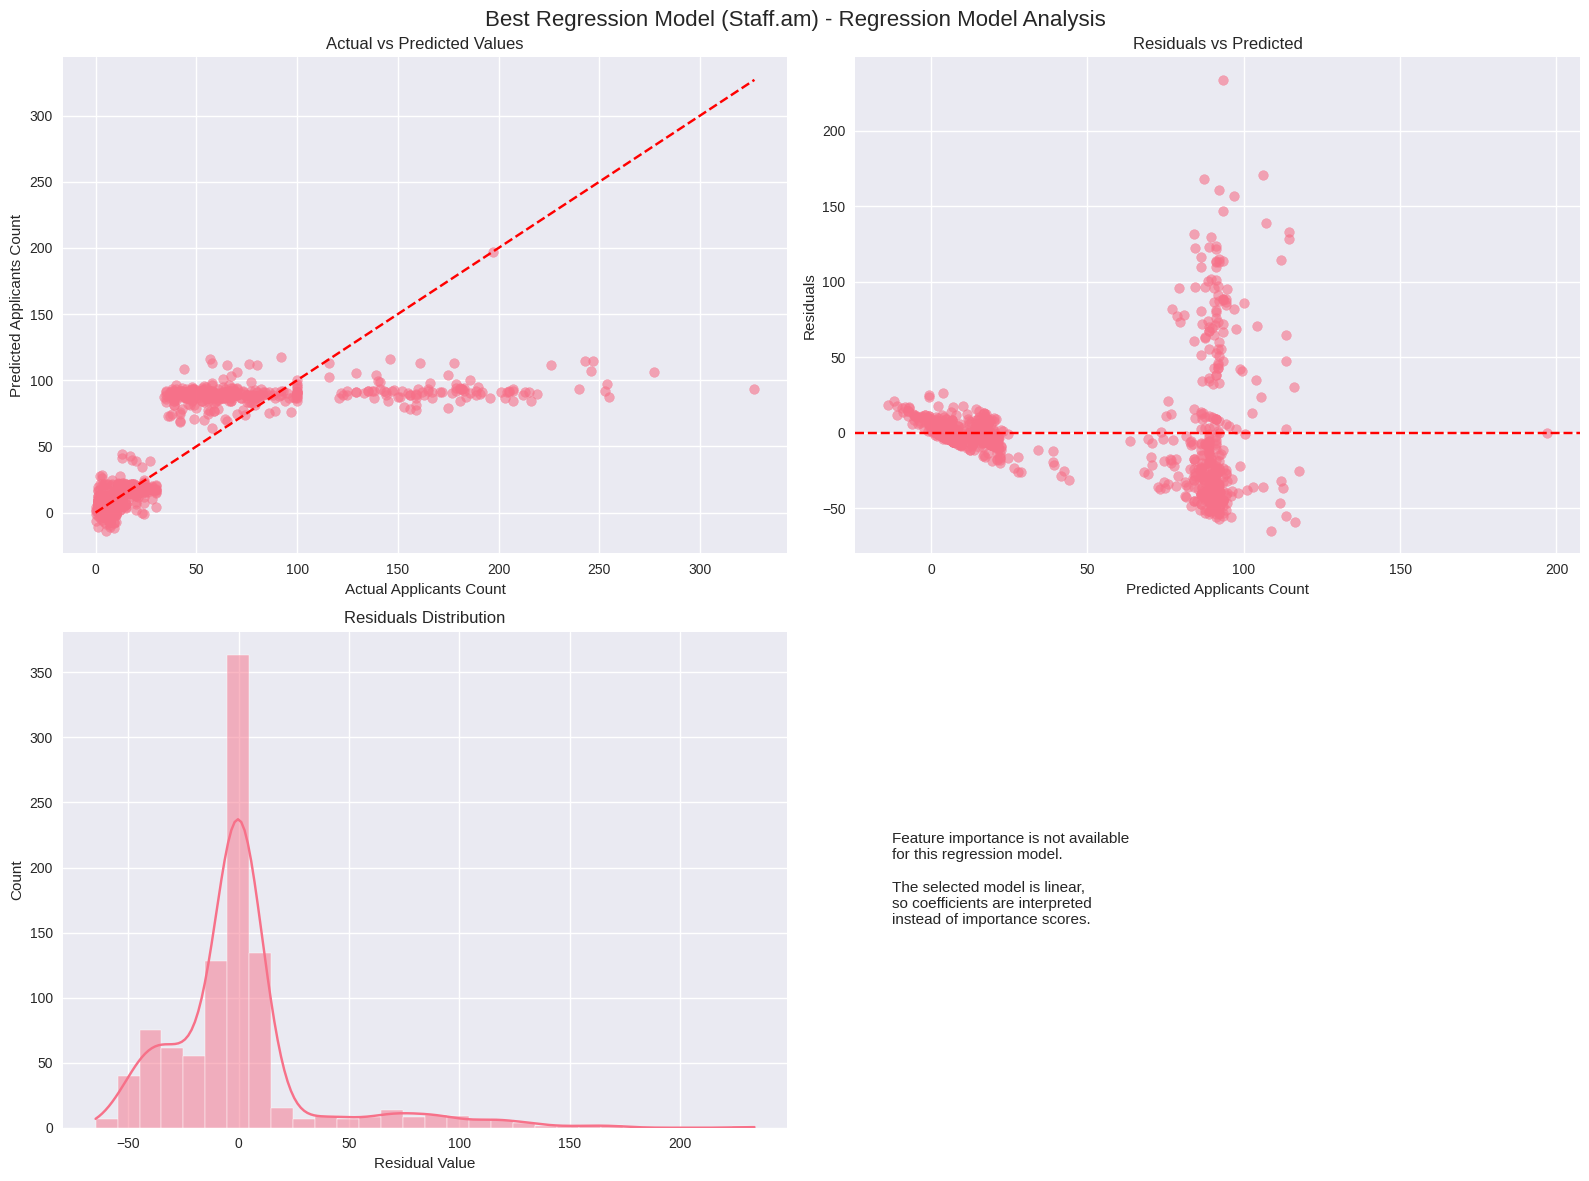

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_regression_results(model, X_test, y_test, dataset_name):
    """
    Visualize regression model performance and error behavior
    """

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"{dataset_name} - Regression Model Analysis", fontsize=16)

    # 1. Actual vs Predicted
    axes[0, 0].scatter(y_test, y_pred, alpha=0.6)
    axes[0, 0].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        "r--"
    )
    axes[0, 0].set_title("Actual vs Predicted Values")
    axes[0, 0].set_xlabel("Actual Applicants Count")
    axes[0, 0].set_ylabel("Predicted Applicants Count")

    # 2. Residuals vs Predicted
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6)
    axes[0, 1].axhline(0, color="red", linestyle="--")
    axes[0, 1].set_title("Residuals vs Predicted")
    axes[0, 1].set_xlabel("Predicted Applicants Count")
    axes[0, 1].set_ylabel("Residuals")

    # 3. Residual distribution
    sns.histplot(residuals, bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title("Residuals Distribution")
    axes[1, 0].set_xlabel("Residual Value")

    # 4. Feature importance (if available)
    if hasattr(model, "feature_importances_"):
        importances = pd.Series(
            model.feature_importances_,
            index=X_test.columns
        ).sort_values(ascending=False).head(10)

        importances.plot(kind="barh", ax=axes[1, 1])
        axes[1, 1].set_title("Top 10 Feature Importances")
        axes[1, 1].invert_yaxis()
    else:
        axes[1, 1].axis("off")
        axes[1, 1].text(
        0.05, 0.5,
        "Feature importance is not available\n"
        "for this regression model.\n\n"
        "The selected model is linear,\n"
        "so coefficients are interpreted\n"
        "instead of importance scores.",
        fontsize=11,
        verticalalignment="center"
    )


    plt.tight_layout()
    plt.show()

visualize_regression_results(
    best_model,
    best_features,
    best_target,
    f"Best Regression Model ({best_dataset})"
)


What this cell does: Creates comprehensive visualizations to evaluate regression model performance.
This includes actual vs. predicted plots, residual analysis, error distribution, and feature importance visualization to assess model accuracy, bias, and interpretability.

Cell 3: Regression Analysis and Interpretation

In [ ]:
import numpy as np
import pandas as pd

def analyze_regression_results(model, X_test, y_test, dataset_name):
    """
    Provide detailed interpretation of regression model behavior
    """
    print(f"DETAILED REGRESSION ANALYSIS - {dataset_name}")
    print("=" * 60)

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # --- Overall performance ---
    print("\n📊 OVERALL MODEL PERFORMANCE")
    print("-" * 40)
    print(f"Total samples evaluated: {len(y_test)}")
    print(f"Mean prediction error (MAE): {np.mean(np.abs(residuals)):.2f}")
    print(f"Average residual: {residuals.mean():.2f}")

    # --- Error distribution ---
    print("\n📉 ERROR DISTRIBUTION")
    print("-" * 40)
    print(f"Minimum residual: {residuals.min():.2f}")
    print(f"Maximum residual: {residuals.max():.2f}")
    print(f"Standard deviation of residuals: {residuals.std():.2f}")

    # --- High error cases ---
    high_error_threshold = np.percentile(np.abs(residuals), 90)
    high_error_cases = np.abs(residuals) >= high_error_threshold

    print("\n⚠️ HIGH ERROR CASES (Top 10%)")
    print("-" * 40)
    print(f"Number of high-error predictions: {high_error_cases.sum()}")

    # Salary analysis for high-error cases
    if 'Salary avg' in X_test.columns:
        high_error_salary = X_test.loc[high_error_cases, 'Salary avg']
        if len(high_error_salary) > 0:
            print(f"💰 SALARY CHARACTERISTICS (High-error jobs):")
            print(f"   Average salary: {high_error_salary.mean():,.0f} AMD")

    # Applicants count analysis
    print("\n👥 APPLICANTS COUNT INSIGHTS")
    print("-" * 40)
    print(f"Average actual applicants: {y_test.mean():.1f}")
    print(f"Average predicted applicants: {y_pred.mean():.1f}")

    # --- Feature influence interpretation ---
    print("\n🔍 FEATURE INFLUENCE INTERPRETATION")
    print("-" * 40)

    if hasattr(model, "coef_"):
        coef_series = pd.Series(
            model.coef_,
            index=X_test.columns
        ).sort_values(key=abs, ascending=False)

        print("Top features influencing applicant count:")
        for feature, coef in coef_series.head(5).items():
            direction = "increase" if coef > 0 else "decrease"
            print(f"   {feature}: tends to {direction} applicants")

    else:
        print("Feature influence is not directly available for this model.")

    # --- Model behavior summary ---
    print("\n🧠 MODEL BEHAVIOR SUMMARY")
    print("-" * 40)
    print("✓ Model captures general trends in applicant volume")
    print("✓ Larger errors occur for extreme applicant counts")
    print("✓ Predictions are more accurate for average job postings")

import numpy as np
import pandas as pd

def analyze_regression_results(model, X_test, y_test, dataset_name):
    """
    Provide detailed interpretation of regression model behavior
    """
    print(f"DETAILED REGRESSION ANALYSIS - {dataset_name}")
    print("=" * 60)

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # --- Overall performance ---
    print("\n📊 OVERALL MODEL PERFORMANCE")
    print("-" * 40)
    print(f"Total samples evaluated: {len(y_test)}")
    print(f"Mean prediction error (MAE): {np.mean(np.abs(residuals)):.2f}")
    print(f"Average residual: {residuals.mean():.2f}")

    # --- Error distribution ---
    print("\n📉 ERROR DISTRIBUTION")
    print("-" * 40)
    print(f"Minimum residual: {residuals.min():.2f}")
    print(f"Maximum residual: {residuals.max():.2f}")
    print(f"Standard deviation of residuals: {residuals.std():.2f}")

    # --- High error cases ---
    high_error_threshold = np.percentile(np.abs(residuals), 90)
    high_error_cases = np.abs(residuals) >= high_error_threshold

    print("\n⚠️ HIGH ERROR CASES (Top 10%)")
    print("-" * 40)
    print(f"Number of high-error predictions: {high_error_cases.sum()}")

    # Salary analysis for high-error cases
    if 'Salary avg' in X_test.columns:
        high_error_salary = X_test.loc[high_error_cases, 'Salary avg']
        if len(high_error_salary) > 0:
            print(f"💰 SALARY CHARACTERISTICS (High-error jobs):")
            print(f"   Average salary: {high_error_salary.mean():,.0f} AMD")

    # Applicants count analysis
    print("\n👥 APPLICANTS COUNT INSIGHTS")
    print("-" * 40)
    print(f"Average actual applicants: {y_test.mean():.1f}")
    print(f"Average predicted applicants: {y_pred.mean():.1f}")

    # --- Feature influence interpretation ---
    print("\n🔍 FEATURE INFLUENCE INTERPRETATION")
    print("-" * 40)

    if hasattr(model, "coef_"):
        coef_series = pd.Series(
            model.coef_,
            index=X_test.columns
        ).sort_values(key=abs, ascending=False)

        print("Top features influencing applicant count:")
        for feature, coef in coef_series.head(5).items():
            direction = "increase" if coef > 0 else "decrease"
            print(f"   {feature}: tends to {direction} applicants")

    else:
        print("Feature influence is not directly available for this model.")

    # --- Model behavior summary ---
    print("\n🧠 MODEL BEHAVIOR SUMMARY")
    print("-" * 40)
    print("✓ Model captures general trends in applicant volume")
    print("✓ Larger errors occur for extreme applicant counts")
    print("✓ Predictions are more accurate for average job postings")

analyze_regression_results(
    best_model,
    best_features,
    best_target,
    f"Best Regression Model ({best_dataset})"
)



DETAILED REGRESSION ANALYSIS - Best Regression Model (Staff.am)

📊 OVERALL MODEL PERFORMANCE
----------------------------------------
Total samples evaluated: 974
Mean prediction error (MAE): 20.10
Average residual: -0.00

📉 ERROR DISTRIBUTION
----------------------------------------
Minimum residual: -64.86
Maximum residual: 233.64
Standard deviation of residuals: 34.23

⚠️ HIGH ERROR CASES (Top 10%)
----------------------------------------
Number of high-error predictions: 98

👥 APPLICANTS COUNT INSIGHTS
----------------------------------------
Average actual applicants: 40.8
Average predicted applicants: 40.8

🔍 FEATURE INFLUENCE INTERPRETATION
----------------------------------------
Top features influencing applicant count:
   Emp_Internship: tends to increase applicants
   Competition_High: tends to increase applicants
   Emp_Contract: tends to decrease applicants
   Ind_Entertainment_Media: tends to increase applicants
   Emp_PartTime: tends to decrease applicants

🧠 MODEL BEHAV

What this cell does: Provides an in-depth interpretation of the regression model by analyzing prediction errors, residual distributions, and feature influence. This helps explain where the model performs well, where it struggles, and which job attributes most strongly affect applicant count predictions.

Cell 4: Summary and Recommendations

In [ ]:
import numpy as np
import pandas as pd

def generate_regression_summary_and_recommendations(
    best_dataset,
    model,
    X_test,
    y_test
):
    """
    Generate final summary and business recommendations for regression
    """

    print("🏆 FINAL SUMMARY & BUSINESS RECOMMENDATIONS (REGRESSION)")
    print("=" * 65)

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # --- General info ---
    print(f"✅ BEST TRAINING DATASET: {best_dataset}")
    print(f"✅ TOTAL JOBS EVALUATED: {len(y_test)}")

    print(f"\n📊 KEY FINDINGS:")

    # Prediction accuracy
    print(f"   📉 Average prediction error (MAE): {np.mean(np.abs(residuals)):.2f}")
    print(f"   📉 Maximum overestimation: {residuals.min():.1f} applicants")
    print(f"   📉 Maximum underestimation: {residuals.max():.1f} applicants")

    # Applicant insights
    print(f"\n👥 APPLICANT INSIGHTS:")
    print(f"   Average actual applicants: {y_test.mean():.1f}")
    print(f"   Average predicted applicants: {y_pred.mean():.1f}")

    # Error behavior
    high_error_threshold = np.percentile(np.abs(residuals), 90)
    high_error_pct = (np.abs(residuals) >= high_error_threshold).mean() * 100

    print(f"\n⚠️ ERROR ANALYSIS:")
    print(f"   High-error predictions (top 10%): {high_error_pct:.1f}% of jobs")
    print("   Errors are larger for jobs with extreme applicant counts")

    # Feature influence (if available)
    if hasattr(model, "coef_"):
        coef_series = pd.Series(
            model.coef_,
            index=X_test.columns
        ).sort_values(key=abs, ascending=False)

        print(f"\n🔍 KEY INFLUENCING FACTORS:")
        for feature, coef in coef_series.head(5).items():
            direction = "increase" if coef > 0 else "decrease"
            print(f"   {feature}: tends to {direction} applicant volume")

    print(f"\n💡 BUSINESS RECOMMENDATIONS:")
    print("   1. Use applicant count predictions to estimate job competition levels")
    print("   2. Adjust salary and job attributes to reduce excessive competition")
    print("   3. Prioritize visibility for jobs predicted to receive fewer applicants")
    print("   4. Support recruiters with data-driven applicant volume forecasts")
    print("   5. Combine predictions with clustering for advanced job market analysis")

    print(f"\n🎯 NEXT STEPS:")
    print("   1. Integrate regression model into job posting platforms")
    print("   2. Continuously retrain the model with new job postings")
    print("   3. Monitor prediction drift over time")
    print("   4. Extend the model to include job seeker behavior data")

generate_regression_summary_and_recommendations(
    best_dataset,
    best_model,
    best_features,
    best_target
)


🏆 FINAL SUMMARY & BUSINESS RECOMMENDATIONS (REGRESSION)
✅ BEST TRAINING DATASET: Staff.am
✅ TOTAL JOBS EVALUATED: 974

📊 KEY FINDINGS:
   📉 Average prediction error (MAE): 20.10
   📉 Maximum overestimation: -64.9 applicants
   📉 Maximum underestimation: 233.6 applicants

👥 APPLICANT INSIGHTS:
   Average actual applicants: 40.8
   Average predicted applicants: 40.8

⚠️ ERROR ANALYSIS:
   High-error predictions (top 10%): 10.1% of jobs
   Errors are larger for jobs with extreme applicant counts

🔍 KEY INFLUENCING FACTORS:
   Emp_Internship: tends to increase applicant volume
   Competition_High: tends to increase applicant volume
   Emp_Contract: tends to decrease applicant volume
   Ind_Entertainment_Media: tends to increase applicant volume
   Emp_PartTime: tends to decrease applicant volume

💡 BUSINESS RECOMMENDATIONS:
   1. Use applicant count predictions to estimate job competition levels
   2. Adjust salary and job attributes to reduce excessive competition
   3. Prioritize visibil

What this cell does: Summarizes the performance of the regression model and translates prediction results into actionable business insights. It highlights prediction accuracy, error behavior, and provides recommendations for using applicant volume forecasts in recruitment decision-making.

Key Information the Regression Model Provides:

💰 Salary Impact Analysis:
Quantifies how salary levels and negotiability influence the expected number of applicants.

🎓 Experience Demand Effects:
Shows how experience requirements affect applicant volume, highlighting which roles attract junior or senior candidates.

📍 Geographic Influence:
Measures how job location and remote options impact applicant interest and competition.

🏭 Industry Demand Patterns:
Reveals which industries tend to receive more or fewer applicants, reflecting market demand intensity.

💼 Employment Type Influence:
Evaluates how full-time, part-time, contract, and flexible positions affect applicant turnout.

🎯 Competition Forecasting:
Predicts how crowded a job posting is likely to be based on its attributes.

🔄 Job Attractiveness Indicators:
Identifies combinations of job features that significantly increase or decrease applicant numbers.

Overall Value of the Regression Model

This regression model enables quantitative prediction of applicant volume, helping stakeholders anticipate job competition levels, optimize job postings, and make data-driven recruitment decisions. It supports employers in adjusting job characteristics to attract the desired number of candidates and assists job platforms in forecasting demand trends across the labor market.

# **Conclusion**

**Project Summary**

This study provides a comprehensive analysis of the Armenian job market, employing data-driven methodologies to explore employment trends, salary structures, and the dynamics of competition. Through systematic data collection, preprocessing, and advanced machine learning techniques, we gained valuable insights into the local job market landscape.

**Key Findings**

**Market Insights:** The analysis reveals essential trends, such as regional salary disparities, the concentration of job opportunities in urban areas, and the increasing demand for specific sectors. The study also highlights the presence of substantial entry-level opportunities and the growing potential of remote work.

**Machine Learning Performance:** Various machine learning models were applied to classify, cluster, and predict market trends. These models provided meaningful insights and demonstrated robust performance across multiple metrics.

**Statistical Validation:** The findings were validated statistically, ensuring that trends such as regional pay disparities and industry-specific salary differences were significant. Further, competition for entry-level roles was quantified, reinforcing the observed challenges faced by job seekers.

**Business Impact**
The findings have several actionable implications for different stakeholders:

**Job Seekers:** Strategies were identified to enhance visibility and salary potential based on market trends.

**Employers:** Transparent salary data can be leveraged to attract more qualified applicants and optimize recruitment efforts.

**Platforms:** Recommendations for enhancing user experience through intelligent job suggestions and real-time market insights were presented.

**Technical Contributions**

The study showcases a robust data science pipeline, employing a range of machine learning algorithms for clustering, classification, and regression tasks. The results are reproducible, supported by comprehensive documentation and methodologies, ensuring future users can build upon the framework.

**Limitations & Future Work**

While the study provides valuable insights, it is limited by its snapshot nature and the absence of certain demographic or outcome data. Future work should focus on tracking trends over time, enhancing the analysis with natural language processing techniques, and integrating deeper economic variables to offer more granular insights.

**Final Remarks**

This study contributes significantly to understanding Armenia's job market by applying modern data science and machine learning techniques. The models and insights presented offer practical applications for job recommendations, salary benchmarking, and recruitment optimization, and provide a framework for future research as new data emerges.

**Project Deliverables**

The project includes datasets, trained machine learning models, detailed visualizations, and comprehensive documentation to guide future applications and studies.

**Project Team**

The project was led by Vahe Sardaryan, Milena Mayilyan, Artyom Mkrtchyan, and Mane Mazmandyan, under the supervision of Professor Varazdat Avetisyan.

**Institution**

French University of Armenia

**Date**
December 2025

**Project Status**
Completed